###Overview

This notebook trains a Mamba model for the UAV class.\
It uses only the samples taken from UAV files (training and validation).\
The model is trained on all sample durations and so we prepare a dataloader that mixes batches of different durations.\
The training class does the training while evaluating the results on the validation samples (of different lengths).\
Notes:
- The training uses an early stopping mechanism where we stop if the validation results have not improved for over "early_stopping" parameter in the configuration.
- The best model parameters are saved, along with the training history. It is possible to load and continue training for a model by configuring 'continued' to True and incrementig 'run' in the training configuration.
- A warm up training with a high learning rate is also implemented.
- Training has an 'evaluation_length' parameter for determining the part of the seuence for which we evaluate performance. I used the last 3 seconds of each sample.
- Since we have different scales between different inputs and different samples, and we want to give them all the same weight in the loss function, we use the 'scale' of the samples to normalize the predictions and lables before going into the loss function. The scale is the 'local Std' calculated for each parameter in preprocessing.
- The model parameters and the time are encoded into a string for the file saving path for identification.

### Imports and loading

In [ ]:
# imports

import io
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
import seaborn as sns
import random

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,AdamW
from torch.optim.lr_scheduler import LinearLR, MultiStepLR

!pip install einops
# from __future__ import annotations
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *
from mamba_model import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 357.3 kB/s eta 0:00:00
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [ ]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

### Model

In [ ]:
def prepare_mixed_dataloader(all_data, batch_size, shuffle = True):
  #shuffled once inside each duration group and then batches are shuffled among durations
  all_batches = []
  for dur, (samples, samples_filenames, dt, scales) in all_data.items():
    dur_vec = [dur]*len(samples)
    if len(samples) > 0:
      data = list(zip(samples, dt, scales, dur_vec))
      dl = DataLoader(data, batch_size = batch_size, shuffle = shuffle)
      for batch in dl:
        all_batches.append(batch)
  if shuffle:
    random.shuffle(all_batches)
  return all_batches

In [ ]:
# save_path = './Samples/mamba_samples_testing0_' + samples_config['subfolder'] + '_all_samples'
# with open(save_path , 'rb') as f:
#   # train_samples, test_samples, train_samples_filenames, test_samples_filenames, train_dt, test_dt, train_scales, test_scales = pickle.load(f)
#   (all_train_data, all_vel_data, all_test_data) = pickle.load(f)

In [ ]:
# train_batches = prepare_mixed_dataloader(all_train_data, 2)
# sample, dt, scale = train_batches[0]

# print(sample.shape)
# print(dt.shape)
# print(scale.shape)

torch.Size([2, 750, 8])
torch.Size([2, 750])
torch.Size([2, 8])


### Training class

In [ ]:
class Training(object):

  def __init__(self, model, config):
    self.config = config
    self.sample_durations = config['sample_durations']
    self.evaluation_durations = config['eval_sample_durations']
    self.device = config['device']
    self.model = model.to(self.config['device'])
    self.model_path = config['model_path']
    lr = config['optimizer_parameter']['lr']
    config['optimizer_parameter']['lr'] = 0.1
    self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
    self.scheduler = MultiStepLR(self.optimizer, milestones=[8], gamma=lr/0.1)
    # self.scheduler = LinearLR(self.optimizer, start_factor=0.05/lr, end_factor=1, total_iters=20)
    self.criterion = config['criterion'].to(self.device)
    self.epoch_offset = 0
    self.training_time = 0
    self.evaluation_length = int(config['evaluation_time']/config['delta'])

  def train(self, train_data, eval_data):
    self.dl_train = train_data
    self.dl_eval = eval_data
    self.eval_history = {d:[] for d in self.evaluation_durations}
    self.eval_loss_history = []
    self.train_loss_history = []
    self.best_results = {d:None for d in self.evaluation_durations}

    if self.config['continued']:
      self.load_model() #loads model state from a previous run

    epochs_without_improvement = 0
    best_loss = None
    train_start = time()

    for epoch in range(self.epoch_offset, self.config['n_epochs'] + self.epoch_offset):
      # train
      self.train_epoch()
      #evaluate
      self.evaluate_epoch(self.dl_eval)
      self.scheduler.step()
      self.eval_loss_history.append(self.epoch_eval_loss/len(self.dl_eval))
      for d in self.evaluation_durations:
        if len(self.eval_results[d]) > 0: # this in case some class doesn't have test samples that are long enough for this d
          self.eval_history[d].append(sum(self.eval_results[d])/len(self.eval_results[d]))
        else:
          self.eval_history[d].append(0)

      if self.config['verbose']:
        print(f'epoch {epoch}: train loss = {self.train_loss_history[-1]}, eval loss = {self.eval_loss_history[-1]}')
      #check for early stopping
      if not best_loss or self.eval_history[10][-1] < best_loss:
        best_loss = self.eval_history[10][-1]
        best_train_loss = self.train_loss_history[-1]
        best_eval_loss = self.eval_loss_history[-1]
        self.best_results = {d:self.eval_history[d][-1] for d in self.evaluation_durations}

        epochs_without_improvement = 0
        #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
        best_model = copy.deepcopy(self.model.state_dict())
      else:
        epochs_without_improvement += 1

      if epochs_without_improvement == self.config['early_stopping']:
        if self.config['verbose']:
            print('\nEarly stoping after {} epochs. eval loss did not imporve for more than {} epochs'.format(epoch, self.config['early_stopping']))
        break

    self.training_time = self.training_time + time() - train_start

    # load best model and best performance and save
    self.model.load_state_dict(best_model)

    losslogger = {'train_loss': self.train_loss_history, 'eval_loss': self.eval_loss_history, 'eval_history': self.eval_history}
    state = {'epoch': epoch - epochs_without_improvement + 1, 'state_dict': best_model,
                'optimizer': self.optimizer.state_dict(), 'losslogger': losslogger, 'training_time': self.training_time}
    torch.save(state, self.model_path)

    if self.config['verbose']:
        print('\nFinished Training:')
        print('Best metrics are:')
        print(f'Best loss = {best_loss}')
        print(f'Best train loss = {best_train_loss}')
        print(f'Best eval loss = {best_eval_loss}')
        # print('Evaluation LogLoss = '.format(best_loss))
        for d, best in self.best_results.items():
            print(f'Best {d}sec eval = {best}')

        # print(f'Best 5sec eval = {best_5sec}')
        # print(f'Best 10sec eval= {best_10sec}')
        # print(f'Best 30sec eval= {best_30sec}')
        # print(f'Best 60sec eval= {best_60sec}')

  def train_epoch(self):
    self.epoch_train_loss   = 0
    self.model.train() # train mode
    for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
      self.train_batch(batch)
    self.train_loss_history.append(self.epoch_train_loss/len(self.dl_train))


  def train_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)

    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)
    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)
    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    loss = self.criterion(scaled_predictions, scaled_labels)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.epoch_train_loss += loss.item()

  def evaluate_epoch(self, dl_eval):
    self.eval_results = {d:[] for d in self.evaluation_durations}
    self.epoch_eval_loss = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        self.eval_batch(batch)

  def eval_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)
    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)

    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)

    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    criterion = nn.MSELoss(reduction='none').to(self.device)
    eval_loss = criterion(scaled_predictions, scaled_labels)
    self.eval_results[int(dur[0])].append((eval_loss[:, -self.evaluation_length:, :].mean()).cpu())
    self.epoch_eval_loss += eval_loss.mean().item()

  def load_model(self):
    prev_model = self.model_path[:-1] + str(self.config['run']-1)
    if os.path.exists(prev_model) and not os.path.exists(self.model_path):
      state = torch.load(prev_model)
      self.model.load_state_dict(state['state_dict'])
      self.optimizer.load_state_dict(state['optimizer'])
      self.epoch_offset = state['epoch']
      self.train_loss_history = state['losslogger']['train_loss']
      self.eval_loss_history = state['losslogger']['eval_loss']
      self.eval_history = state['losslogger']['eval_history']
      self.training_time = state['training_time']
    else:
      raise ValueError('No previous model found')

In [ ]:
def plot_training_summary(training_model):
  epochs = np.arange(len(training_model.train_loss_history)) + 1
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(epochs, training_model.train_loss_history, 'r', label = 'train loss')
  ax1.plot(epochs, training_model.eval_loss_history, 'orange', label = 'eval loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  palette = plt.get_cmap('tab20')
  colors = [palette(i) for i in range(len(training_model.evaluation_durations))]
  for d, color in zip(training_model.evaluation_durations, colors):
    plt.yscale("log")
    ax2.plot(epochs, training_model.eval_history[d], color = color, label = d)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Error')
  ax2.legend()

In [ ]:
def conf2str(mamba_config, training_config):
  #used to encode the run parameters to a string for identification
  conf_str = 'dm' + str(mamba_config['d_model']) \
  +'nl' + str(mamba_config['n_layer']) \
  +'ds' + str(mamba_config['d_state']) \
  +'dc' + str(mamba_config['d_conv']) \
  +'rs' + str(mamba_config['model_random_state']) \
  +'bs' + str(training_config['batch_size']) \
  +'op' + training_config['optimizer_name'] \
  +'lr' + str(training_config['optimizer_parameter']['lr'])\
  +'r' + str(training_config['run'])

  return conf_str

## Experiments

In [ ]:
samples_config = {
    'subfolder' : 'airplane',
    'delta' : 0.04,
    'sample_durations' : [5, 10, 30, 60],
    'eval_sample_durations' : [5, 10, 15, 20, 25, 30],
    'sample_duration' : 10,
    'skip_duration' : 15,
    'min_samples' : 10
}

In [ ]:
save_path = './Samples/mamba_samples_' + samples_config['subfolder'] + '_skip' + str(samples_config['skip_duration']) + '_split0.2' + '_all_samples'
with open(save_path , 'rb') as f:
  (all_train_data, all_val_data, all_test_data) = pickle.load(f)

(test_samples, test_filenames, test_dt, test_scales) = all_test_data[5]

In [ ]:
record_columns = ['datetime', 'Best Result @5', 'Best Result @10', 'Best Result @20', 'Learning Rate','Batch Size','Layers','d_state','Model Path', 'Test Files', 'Mamba Config', 'Training Config', 'Train Loss History', 'Evaluation Loss History', 'Eval History', 'Best Results']
exp_record = pd.DataFrame(columns = record_columns)

100%|██████████| 13/13 [00:01<00:00,  9.61it/s]


epoch 0: train loss = 4488925.62993421, eval loss = 1419282.0212965745


100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


epoch 1: train loss = 4086691.200657895, eval loss = 1252783.6535268931


100%|██████████| 13/13 [00:01<00:00, 10.10it/s]


epoch 2: train loss = 3702856.789473684, eval loss = 1101360.3779484676


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


epoch 3: train loss = 3329397.3552631577, eval loss = 965505.5569974459


100%|██████████| 13/13 [00:01<00:00,  9.94it/s]


epoch 4: train loss = 2986408.8898026315, eval loss = 840819.1410945012


100%|██████████| 13/13 [00:01<00:00,  9.86it/s]


epoch 5: train loss = 2646511.1134868423, eval loss = 733289.0678335336


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


epoch 6: train loss = 2358653.3873355263, eval loss = 645869.8828500601


100%|██████████| 13/13 [00:01<00:00, 10.01it/s]


epoch 7: train loss = 2165167.0690789474, eval loss = 567148.072678786


100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


epoch 8: train loss = 1984930.9284539474, eval loss = 562095.5869516226


100%|██████████| 13/13 [00:01<00:00,  9.72it/s]


epoch 9: train loss = 1935364.6143092106, eval loss = 556724.4739332933


100%|██████████| 13/13 [00:01<00:00,  7.11it/s]


epoch 10: train loss = 1899352.7335526317, eval loss = 543918.1884765625


100%|██████████| 13/13 [00:01<00:00,  9.78it/s]


epoch 11: train loss = 1870016.6710526317, eval loss = 533965.3415715144


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


epoch 12: train loss = 1842520.5838815789, eval loss = 524394.4673978365


100%|██████████| 13/13 [00:01<00:00, 10.07it/s]


epoch 13: train loss = 1816301.9588815789, eval loss = 516226.39490685094


100%|██████████| 13/13 [00:01<00:00,  9.87it/s]


epoch 14: train loss = 1790553.4399671052, eval loss = 508409.38356370194


100%|██████████| 13/13 [00:01<00:00,  9.99it/s]


epoch 15: train loss = 1764783.574424342, eval loss = 501332.8621544471


100%|██████████| 13/13 [00:01<00:00, 10.07it/s]


epoch 16: train loss = 1738922.8182565789, eval loss = 493932.4786658654


100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


epoch 17: train loss = 1713345.4658717106, eval loss = 486164.9493689904


100%|██████████| 13/13 [00:01<00:00,  9.96it/s]


epoch 18: train loss = 1687830.2043585526, eval loss = 478825.2596905048


100%|██████████| 13/13 [00:01<00:00, 10.12it/s]


epoch 19: train loss = 1662145.1476151317, eval loss = 471825.9492938702


100%|██████████| 13/13 [00:01<00:00,  9.72it/s]


epoch 20: train loss = 1637078.6472039474, eval loss = 465893.50653545675


100%|██████████| 13/13 [00:01<00:00,  9.93it/s]


epoch 21: train loss = 1612015.457236842, eval loss = 459549.1065204327


100%|██████████| 13/13 [00:01<00:00,  9.69it/s]


epoch 22: train loss = 1588638.863486842, eval loss = 454647.13303786056


100%|██████████| 13/13 [00:01<00:00, 10.13it/s]


epoch 23: train loss = 1565217.7376644737, eval loss = 447700.0053335336


100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


epoch 24: train loss = 1542344.2265625, eval loss = 440506.30919471156


100%|██████████| 13/13 [00:01<00:00,  9.76it/s]


epoch 25: train loss = 1520237.9169407894, eval loss = 436123.33458533656


100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


epoch 26: train loss = 1498051.7738486843, eval loss = 431182.4529747596


100%|██████████| 13/13 [00:01<00:00, 10.09it/s]


epoch 27: train loss = 1475921.3486842106, eval loss = 426763.7061298077


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 28: train loss = 1453699.5444078948, eval loss = 422613.27771935094


100%|██████████| 13/13 [00:01<00:00,  9.66it/s]


epoch 29: train loss = 1431938.8898026317, eval loss = 418234.68622295675


100%|██████████| 13/13 [00:01<00:00,  9.84it/s]


epoch 30: train loss = 1410709.1122532894, eval loss = 413530.1326622596


100%|██████████| 13/13 [00:01<00:00,  9.99it/s]


epoch 31: train loss = 1389944.0328947369, eval loss = 408664.6073467548


100%|██████████| 13/13 [00:01<00:00,  9.94it/s]


epoch 32: train loss = 1368864.0875822369, eval loss = 405732.1518179086


100%|██████████| 13/13 [00:01<00:00,  9.61it/s]


epoch 33: train loss = 1348510.730263158, eval loss = 400990.5076622596


100%|██████████| 13/13 [00:01<00:00,  9.75it/s]


epoch 34: train loss = 1328467.261924342, eval loss = 395821.80626502406


100%|██████████| 13/13 [00:02<00:00,  6.23it/s]


epoch 35: train loss = 1309489.3236019737, eval loss = 390660.57008713944


100%|██████████| 13/13 [00:01<00:00,  9.74it/s]


epoch 36: train loss = 1289679.0024671052, eval loss = 386461.70350060094


100%|██████████| 13/13 [00:01<00:00,  6.74it/s]


epoch 37: train loss = 1270014.0731907894, eval loss = 381712.75030048075


100%|██████████| 13/13 [00:01<00:00,  9.88it/s]


epoch 38: train loss = 1250946.4169407894, eval loss = 379083.2157451923


100%|██████████| 13/13 [00:01<00:00, 10.18it/s]


epoch 39: train loss = 1232488.9440789474, eval loss = 374013.44756610575


100%|██████████| 13/13 [00:01<00:00,  9.80it/s]


epoch 40: train loss = 1214790.7018914474, eval loss = 369782.01344651444


100%|██████████| 13/13 [00:01<00:00,  9.88it/s]


epoch 41: train loss = 1196656.0279605263, eval loss = 365382.2768179086


100%|██████████| 13/13 [00:01<00:00,  7.73it/s]


epoch 42: train loss = 1177527.4823190789, eval loss = 361297.43220402644


100%|██████████| 13/13 [00:01<00:00,  9.71it/s]


epoch 43: train loss = 1160295.886513158, eval loss = 358494.96525691106


100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


epoch 44: train loss = 1142271.5213815789, eval loss = 353933.11701847956


100%|██████████| 13/13 [00:01<00:00,  9.96it/s]


epoch 45: train loss = 1124910.4013157894, eval loss = 349891.7065993089


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


epoch 46: train loss = 1107635.0563322369, eval loss = 345353.54298753006


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


epoch 47: train loss = 1091507.6426809211, eval loss = 346396.076566256


100%|██████████| 13/13 [00:01<00:00,  9.29it/s]


epoch 48: train loss = 1074510.9950657894, eval loss = 337392.0729792668


100%|██████████| 13/13 [00:01<00:00,  9.67it/s]


epoch 49: train loss = 1057823.3375822369, eval loss = 335118.9123159555


100%|██████████| 13/13 [00:01<00:00,  9.80it/s]


epoch 50: train loss = 1041372.6772203947, eval loss = 333904.5647160457


100%|██████████| 13/13 [00:01<00:00,  9.68it/s]


epoch 51: train loss = 1025232.2018914474, eval loss = 328285.6931152344


100%|██████████| 13/13 [00:01<00:00,  9.93it/s]


epoch 52: train loss = 1009720.9300986842, eval loss = 325061.42578125


100%|██████████| 13/13 [00:02<00:00,  4.79it/s]


epoch 53: train loss = 994238.6032072369, eval loss = 323753.59221003606


100%|██████████| 13/13 [00:01<00:00,  9.98it/s]


epoch 54: train loss = 980629.7023026316, eval loss = 313780.2039888822


100%|██████████| 13/13 [00:01<00:00,  9.64it/s]


epoch 55: train loss = 966832.1981907894, eval loss = 319042.70380108175


100%|██████████| 13/13 [00:01<00:00,  9.74it/s]


epoch 56: train loss = 950147.5686677631, eval loss = 314536.98377403844


100%|██████████| 13/13 [00:01<00:00,  9.89it/s]


epoch 57: train loss = 935296.521381579, eval loss = 312476.36279296875


100%|██████████| 13/13 [00:01<00:00,  9.89it/s]


epoch 58: train loss = 920714.4819078947, eval loss = 309878.84326171875


100%|██████████| 13/13 [00:01<00:00,  9.87it/s]


epoch 59: train loss = 905854.1994243421, eval loss = 308629.55994591344


100%|██████████| 13/13 [00:01<00:00, 10.01it/s]


epoch 60: train loss = 891301.9856085526, eval loss = 306804.9021935096


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 61: train loss = 877213.5256990131, eval loss = 306328.08323317306


100%|██████████| 13/13 [00:01<00:00,  9.81it/s]


epoch 62: train loss = 863439.775287829, eval loss = 304231.654296875


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


epoch 63: train loss = 850015.8369654606, eval loss = 303420.7451923077


100%|██████████| 13/13 [00:01<00:00,  9.83it/s]


epoch 64: train loss = 836759.5004111842, eval loss = 301217.6376201923


100%|██████████| 13/13 [00:01<00:00,  8.02it/s]


epoch 65: train loss = 825421.8153782894, eval loss = 304940.73858173075


100%|██████████| 13/13 [00:01<00:00,  9.93it/s]


epoch 66: train loss = 813201.1044407894, eval loss = 311630.81715745194


100%|██████████| 13/13 [00:01<00:00,  9.74it/s]


epoch 67: train loss = 797982.2537006579, eval loss = 301711.72686298075


100%|██████████| 13/13 [00:01<00:00,  9.97it/s]


epoch 68: train loss = 784811.8737664474, eval loss = 302572.57947716344


100%|██████████| 13/13 [00:01<00:00,  9.99it/s]


epoch 69: train loss = 772235.0442023026, eval loss = 299188.7524038461


100%|██████████| 13/13 [00:01<00:00,  9.63it/s]


epoch 70: train loss = 759730.216899671, eval loss = 295824.7560096154


100%|██████████| 13/13 [00:01<00:00,  9.80it/s]


epoch 71: train loss = 749257.7103207237, eval loss = 296271.6463341346


100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


epoch 72: train loss = 738270.1708470394, eval loss = 302351.68780048075


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


epoch 73: train loss = 724748.1638569079, eval loss = 298922.48993389425


100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


epoch 74: train loss = 712634.8170230263, eval loss = 293898.9364483173


100%|██████████| 13/13 [00:01<00:00,  9.85it/s]


epoch 75: train loss = 701258.5670230263, eval loss = 291048.08330829325


100%|██████████| 13/13 [00:01<00:00,  9.78it/s]


epoch 76: train loss = 689764.2687088816, eval loss = 289440.34637920675


100%|██████████| 13/13 [00:01<00:00,  9.72it/s]


epoch 77: train loss = 678916.6694078947, eval loss = 286819.1870492789


100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


epoch 78: train loss = 667909.3449835526, eval loss = 285665.80303485575


100%|██████████| 13/13 [00:01<00:00,  9.75it/s]


epoch 79: train loss = 657589.1591282894, eval loss = 284560.0811298077


100%|██████████| 13/13 [00:01<00:00,  9.96it/s]


epoch 80: train loss = 646871.1315789474, eval loss = 284529.4119591346


100%|██████████| 13/13 [00:01<00:00,  7.40it/s]


epoch 81: train loss = 636474.986225329, eval loss = 285263.58368389425


100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


epoch 82: train loss = 626079.2650082237, eval loss = 283001.8745492789


100%|██████████| 13/13 [00:01<00:00,  6.67it/s]


epoch 83: train loss = 616122.2530838816, eval loss = 283644.4161658654


100%|██████████| 13/13 [00:01<00:00,  9.57it/s]


epoch 84: train loss = 606097.4196134869, eval loss = 282150.935546875


100%|██████████| 13/13 [00:01<00:00,  9.64it/s]


epoch 85: train loss = 596561.9420230263, eval loss = 282939.2456430289


100%|██████████| 13/13 [00:01<00:00,  9.64it/s]


epoch 86: train loss = 586868.3462171053, eval loss = 281596.2576622596


100%|██████████| 13/13 [00:01<00:00,  9.91it/s]


epoch 87: train loss = 577634.814555921, eval loss = 282215.64528245194


100%|██████████| 13/13 [00:01<00:00,  9.99it/s]


epoch 88: train loss = 568299.421875, eval loss = 281408.19996995194


100%|██████████| 13/13 [00:01<00:00,  9.69it/s]


epoch 89: train loss = 559316.3270970394, eval loss = 282601.98212139425


100%|██████████| 13/13 [00:01<00:00,  8.03it/s]


epoch 90: train loss = 550147.7216282894, eval loss = 282947.6709735577


100%|██████████| 13/13 [00:01<00:00,  9.63it/s]


epoch 91: train loss = 541102.8178453947, eval loss = 283166.75075120194


100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


epoch 92: train loss = 532080.6761924342, eval loss = 283244.13115985575


100%|██████████| 13/13 [00:01<00:00, 10.19it/s]


epoch 93: train loss = 523512.61513157893, eval loss = 285149.974609375


100%|██████████| 13/13 [00:01<00:00,  7.53it/s]


epoch 94: train loss = 515311.0102796053, eval loss = 286881.38161057694


100%|██████████| 13/13 [00:01<00:00,  9.78it/s]


epoch 95: train loss = 507159.4251644737, eval loss = 287911.40459735575


100%|██████████| 13/13 [00:01<00:00,  9.95it/s]


epoch 96: train loss = 498468.11986019736, eval loss = 286797.1899038461


100%|██████████| 13/13 [00:01<00:00,  9.63it/s]


epoch 97: train loss = 490327.0927220395, eval loss = 287066.72911658656


100%|██████████| 13/13 [00:01<00:00,  9.76it/s]


epoch 98: train loss = 482461.18544407893, eval loss = 287382.8556189904


100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


epoch 99: train loss = 474610.06866776315, eval loss = 288355.39453125


100%|██████████| 13/13 [00:01<00:00,  9.80it/s]


epoch 100: train loss = 467077.46669407893, eval loss = 288024.3135516827


100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


epoch 101: train loss = 459618.4477796053, eval loss = 289410.9502704327


100%|██████████| 13/13 [00:01<00:00,  9.78it/s]


epoch 102: train loss = 453024.6278782895, eval loss = 287202.88146033656


100%|██████████| 13/13 [00:01<00:00,  9.64it/s]


epoch 103: train loss = 445606.61122532893, eval loss = 291212.80889423075


100%|██████████| 13/13 [00:01<00:00,  9.87it/s]


epoch 104: train loss = 438101.9115953947, eval loss = 291875.70928485575


100%|██████████| 13/13 [00:01<00:00,  9.93it/s]


epoch 105: train loss = 431135.7119654605, eval loss = 290648.59630408656


100%|██████████| 13/13 [00:01<00:00,  9.71it/s]


epoch 106: train loss = 424328.3774671053, eval loss = 288208.04296875

Early stoping after 106 epochs. eval loss did not imporve for more than 20 epochs

Finished Training:
Best metrics are:
Best loss = 200991.5
Best train loss = 586868.3462171053
Best eval loss = 281596.2576622596
Best 5sec eval = 571493.3125
Best 10sec eval = 200991.5
Best 15sec eval = 202202.375
Best 20sec eval = 238842.46875
Best 25sec eval = 141095.3125
Best 30sec eval = 68710.125


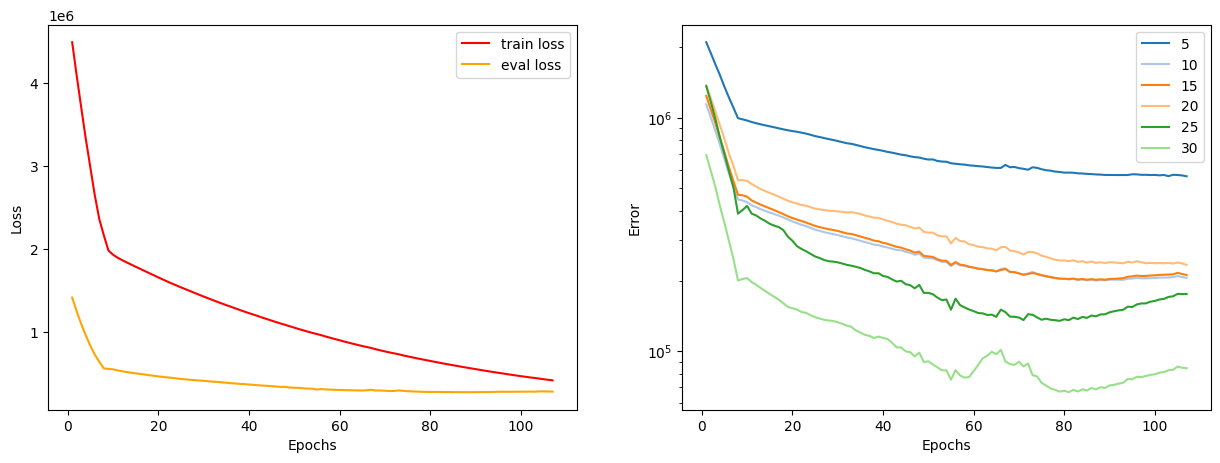

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 2, 'd_state' : 32, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 400, 'early_stopping' : 20, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"05/11/2024, 12:27:26",251889,206321,353713,0.05,32,1,32,./Models/mamba_model_airplane_dm8nl1ds32dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 32, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4482801.40131579, 4030353.052631579, 3608927....","[1818064.764423077, 1547408.173076923, 1313323...","{5: [tensor(1908564.8750), tensor(1626443.), t...","{5: tensor(251889.8750), 10: tensor(206321.296..."
1,"05/11/2024, 12:38:43",571493,200991,238842,0.01,32,2,32,./Models/mamba_model_airplane_dm8nl2ds32dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 32, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4488925.62993421, 4086691.200657895, 3702856....","[1419282.0212965745, 1252783.6535268931, 11013...","{5: [tensor(2104463.2500), tensor(1890390.), t...","{5: tensor(571493.3125), 10: tensor(200991.500..."


In [ ]:
# date_time_ = str(date_time).replace("/","_")
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder']  + date_time_

with open(results_path , 'wb') as f:
  pickle.dump(exp_record, f)

100%|██████████| 13/13 [00:01<00:00,  9.69it/s]


epoch 0: train loss = 4167401.966282895, eval loss = 1156171.3317307692


100%|██████████| 13/13 [00:01<00:00,  9.53it/s]


epoch 1: train loss = 3774465.2976973685, eval loss = 1002759.4519230769


100%|██████████| 13/13 [00:01<00:00,  9.85it/s]


epoch 2: train loss = 3426332.380756579, eval loss = 876456.9891826923


100%|██████████| 13/13 [00:01<00:00,  9.39it/s]


epoch 3: train loss = 3094877.869243421, eval loss = 783962.5252403846


100%|██████████| 13/13 [00:01<00:00,  9.28it/s]


epoch 4: train loss = 2791499.1903782897, eval loss = 670024.2367788461


100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


epoch 5: train loss = 2503101.3030427634, eval loss = 615825.8365384615


100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


epoch 6: train loss = 2289822.9893092103, eval loss = 530930.8401442308


100%|██████████| 13/13 [00:01<00:00,  9.23it/s]


epoch 7: train loss = 2044357.9194078948, eval loss = 445745.3846153846


100%|██████████| 13/13 [00:01<00:00,  9.34it/s]


epoch 8: train loss = 1896074.4782072369, eval loss = 442863.39182692306


100%|██████████| 13/13 [00:01<00:00,  9.16it/s]


epoch 9: train loss = 1860613.824013158, eval loss = 436886.95432692306


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 10: train loss = 1832094.0933388157, eval loss = 429535.13401442306


100%|██████████| 13/13 [00:01<00:00,  9.09it/s]


epoch 11: train loss = 1806770.7939967106, eval loss = 420337.6111778846


100%|██████████| 13/13 [00:01<00:00,  9.44it/s]


epoch 12: train loss = 1782876.6685855263, eval loss = 415808.7524038461


100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


epoch 13: train loss = 1758916.4642269737, eval loss = 411015.1274038461


100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


epoch 14: train loss = 1747531.1554276317, eval loss = 411942.71754807694


100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


epoch 15: train loss = 1750240.9342105263, eval loss = 398570.8413461539


100%|██████████| 13/13 [00:01<00:00,  9.06it/s]


epoch 16: train loss = 1692629.8379934211, eval loss = 389210.1189903846


100%|██████████| 13/13 [00:01<00:00,  9.22it/s]


epoch 17: train loss = 1667950.4013157894, eval loss = 383405.5342548077


100%|██████████| 13/13 [00:01<00:00,  9.16it/s]


epoch 18: train loss = 1644470.0879934211, eval loss = 377986.20252403844


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


epoch 19: train loss = 1622616.0694901317, eval loss = 370817.9717548077


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


epoch 20: train loss = 1602997.7134046052, eval loss = 363053.1778846154


100%|██████████| 13/13 [00:01<00:00,  9.23it/s]


epoch 21: train loss = 1576729.3416940789, eval loss = 360541.9789663461


100%|██████████| 13/13 [00:01<00:00,  9.19it/s]


epoch 22: train loss = 1555568.1377467106, eval loss = 360278.63942307694


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 23: train loss = 1526160.1270559211, eval loss = 354886.9891826923


100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


epoch 24: train loss = 1502943.0608552631, eval loss = 353040.85096153844


100%|██████████| 13/13 [00:02<00:00,  6.37it/s]


epoch 25: train loss = 1481257.754111842, eval loss = 344793.4501201923


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 26: train loss = 1462710.5875822369, eval loss = 340899.6328125


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 27: train loss = 1452962.2121710526, eval loss = 336085.39122596156


100%|██████████| 13/13 [00:01<00:00,  9.26it/s]


epoch 28: train loss = 1424613.6669407894, eval loss = 329120.85997596156


100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


epoch 29: train loss = 1408250.7039473683, eval loss = 326675.4795673077


100%|██████████| 13/13 [00:01<00:00,  9.41it/s]


epoch 30: train loss = 1393453.2121710526, eval loss = 344875.71995192306


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 31: train loss = 1383651.6237664474, eval loss = 320797.76201923075


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 32: train loss = 1393108.8963815789, eval loss = 304892.00120192306


100%|██████████| 13/13 [00:01<00:00,  6.83it/s]


epoch 33: train loss = 1333166.7709703948, eval loss = 307989.03545673075


100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


epoch 34: train loss = 1318940.8153782894, eval loss = 298948.0576923077


100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


epoch 35: train loss = 1309145.4712171052, eval loss = 302434.3341346154


100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


epoch 36: train loss = 1282058.9535361843, eval loss = 289553.5907451923


100%|██████████| 13/13 [00:01<00:00,  9.47it/s]


epoch 37: train loss = 1269800.581825658, eval loss = 295576.9014423077


100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


epoch 38: train loss = 1244301.0230263157, eval loss = 281908.95372596156


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


epoch 39: train loss = 1229784.6965460526, eval loss = 290885.4350961539


100%|██████████| 13/13 [00:01<00:00,  9.24it/s]


epoch 40: train loss = 1209732.605263158, eval loss = 277352.4867788461


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


epoch 41: train loss = 1195893.2549342106, eval loss = 284838.5955528846


100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


epoch 42: train loss = 1175657.1776315789, eval loss = 273385.61989182694


100%|██████████| 13/13 [00:02<00:00,  5.32it/s]


epoch 43: train loss = 1161517.8470394737, eval loss = 278275.1454326923


100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


epoch 44: train loss = 1141957.2027138157, eval loss = 267929.9522235577


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


epoch 45: train loss = 1127657.613486842, eval loss = 275223.0372596154


100%|██████████| 13/13 [00:01<00:00,  9.17it/s]


epoch 46: train loss = 1109421.0826480263, eval loss = 264538.3819110577


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


epoch 47: train loss = 1095313.9658717106, eval loss = 270663.8927283654


100%|██████████| 13/13 [00:01<00:00,  9.06it/s]


epoch 48: train loss = 1077591.8852796052, eval loss = 259652.4110576923


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 49: train loss = 1063730.2824835526, eval loss = 267428.0919471154


100%|██████████| 13/13 [00:01<00:00,  9.16it/s]


epoch 50: train loss = 1046943.7532894737, eval loss = 254948.14783653847


100%|██████████| 13/13 [00:01<00:00,  7.48it/s]


epoch 51: train loss = 1032734.4851973684, eval loss = 260999.4483173077


100%|██████████| 13/13 [00:01<00:00,  6.57it/s]


epoch 52: train loss = 1016816.755756579, eval loss = 248491.66796875


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 53: train loss = 1003426.0497532894, eval loss = 257683.6328125


100%|██████████| 13/13 [00:01<00:00,  9.49it/s]


epoch 54: train loss = 988566.3462171053, eval loss = 245353.1063701923


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


epoch 55: train loss = 975282.4272203947, eval loss = 255371.55228365384


100%|██████████| 13/13 [00:01<00:00,  9.53it/s]


epoch 56: train loss = 959253.1805098684, eval loss = 239989.34314903847


100%|██████████| 13/13 [00:01<00:00,  9.57it/s]


epoch 57: train loss = 946589.1772203947, eval loss = 248319.63431490384


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 58: train loss = 930941.9868421053, eval loss = 228224.26802884616


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


epoch 59: train loss = 918597.2828947369, eval loss = 237506.44801682694


100%|██████████| 13/13 [00:01<00:00,  8.38it/s]


epoch 60: train loss = 902709.4560032894, eval loss = 223514.7022235577


100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


epoch 61: train loss = 890109.5431743421, eval loss = 226710.06460336538


100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


epoch 62: train loss = 876291.3638980263, eval loss = 218715.12620192306


100%|██████████| 13/13 [00:01<00:00,  9.26it/s]


epoch 63: train loss = 864603.849506579, eval loss = 222359.72025240384


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


epoch 64: train loss = 850755.3322368421, eval loss = 220898.03455528847


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 65: train loss = 837779.640625, eval loss = 220526.57662259616


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


epoch 66: train loss = 824510.0707236842, eval loss = 217966.0946514423


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 67: train loss = 812518.6722861842, eval loss = 215661.55348557694


100%|██████████| 13/13 [00:01<00:00,  8.02it/s]


epoch 68: train loss = 799609.0690789474, eval loss = 216643.2764423077


100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


epoch 69: train loss = 788048.3289473684, eval loss = 216381.68990384616


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 70: train loss = 775026.2709703947, eval loss = 220451.09495192306


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


epoch 71: train loss = 762923.3168174342, eval loss = 215775.12139423078


100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


epoch 72: train loss = 750877.4839638158, eval loss = 219223.96604567306


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


epoch 73: train loss = 739831.685649671, eval loss = 216332.32662259616


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


epoch 74: train loss = 727762.7997532894, eval loss = 219896.36838942306


100%|██████████| 13/13 [00:01<00:00,  9.43it/s]


epoch 75: train loss = 716644.3904194079, eval loss = 215551.12770432694


100%|██████████| 13/13 [00:01<00:00,  7.78it/s]


epoch 76: train loss = 705566.4210526316, eval loss = 218992.02734375


100%|██████████| 13/13 [00:02<00:00,  6.35it/s]


epoch 77: train loss = 694834.2956414474, eval loss = 216456.67217548078


100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


epoch 78: train loss = 684008.3310032894, eval loss = 218284.28936298078


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 79: train loss = 673709.4099506579, eval loss = 216140.56490384616


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


epoch 80: train loss = 663355.4350328947, eval loss = 217254.28185096153


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


epoch 81: train loss = 653459.0717516447, eval loss = 216710.57542067306


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


epoch 82: train loss = 643394.2685032894, eval loss = 216879.48948317306


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


epoch 83: train loss = 633830.1453536184, eval loss = 217221.05078125


100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


epoch 84: train loss = 624091.9280427631, eval loss = 216588.99248798078


100%|██████████| 13/13 [00:02<00:00,  6.11it/s]


epoch 85: train loss = 614981.2913240131, eval loss = 217074.22085336538


100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


epoch 86: train loss = 605567.0892269737, eval loss = 215801.67157451922


100%|██████████| 13/13 [00:01<00:00,  9.35it/s]


epoch 87: train loss = 596782.2312911184, eval loss = 216805.13161057694


100%|██████████| 13/13 [00:01<00:00,  9.39it/s]


epoch 88: train loss = 587670.4617598684, eval loss = 216160.12710336538


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


epoch 89: train loss = 579131.5713404606, eval loss = 216580.40685096153


100%|██████████| 13/13 [00:01<00:00,  9.39it/s]


epoch 90: train loss = 570324.2974917763, eval loss = 215041.78064903847


100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


epoch 91: train loss = 562155.5357730263, eval loss = 217713.1102764423


100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


epoch 92: train loss = 553393.0941611842, eval loss = 215842.64603365384


100%|██████████| 13/13 [00:02<00:00,  6.44it/s]


epoch 93: train loss = 545474.540912829, eval loss = 217787.17127403847


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 94: train loss = 537102.6784539474, eval loss = 216799.53936298078


100%|██████████| 13/13 [00:01<00:00,  9.05it/s]


epoch 95: train loss = 529293.7798108553, eval loss = 220522.4287860577


100%|██████████| 13/13 [00:01<00:00,  9.06it/s]


epoch 96: train loss = 521147.56805098685, eval loss = 218972.42998798078


100%|██████████| 13/13 [00:01<00:00,  9.09it/s]


epoch 97: train loss = 513503.1048519737, eval loss = 222702.7178485577


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 98: train loss = 505620.15625, eval loss = 218995.52734375


100%|██████████| 13/13 [00:01<00:00,  9.12it/s]


epoch 99: train loss = 498301.9695723684, eval loss = 223083.1649639423


100%|██████████| 13/13 [00:01<00:00,  6.87it/s]


epoch 100: train loss = 490838.38671875, eval loss = 219879.38010817306


100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


epoch 101: train loss = 483652.18236019736, eval loss = 224791.55588942306


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


epoch 102: train loss = 476466.9763569079, eval loss = 220518.8055889423


100%|██████████| 13/13 [00:01<00:00,  9.49it/s]


epoch 103: train loss = 469560.8081825658, eval loss = 225799.11658653847


100%|██████████| 13/13 [00:01<00:00,  9.28it/s]


epoch 104: train loss = 462601.0888157895, eval loss = 217964.75570913462


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


epoch 105: train loss = 455866.40069901315, eval loss = 224821.34945913462


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 106: train loss = 449263.77076480264, eval loss = 220745.42232572116


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 107: train loss = 442593.89453125, eval loss = 226209.91165865384


100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


epoch 108: train loss = 435928.46258223685, eval loss = 221732.2881610577


100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


epoch 109: train loss = 429525.54173519736, eval loss = 226441.97115384616


100%|██████████| 13/13 [00:01<00:00,  9.63it/s]


epoch 110: train loss = 423409.98704769736, eval loss = 221998.27178485578


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 111: train loss = 417248.3947368421, eval loss = 228293.18930288462


100%|██████████| 13/13 [00:01<00:00,  9.62it/s]


epoch 112: train loss = 410948.14226973685, eval loss = 223693.6786358173


100%|██████████| 13/13 [00:01<00:00,  9.54it/s]


epoch 113: train loss = 405043.3663651316, eval loss = 225906.2626201923


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 114: train loss = 399516.48704769736, eval loss = 223044.7489483173


100%|██████████| 13/13 [00:01<00:00,  9.31it/s]


epoch 115: train loss = 393898.90810032893, eval loss = 230021.24399038462


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


epoch 116: train loss = 387712.50616776315, eval loss = 225883.92518028847


100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


epoch 117: train loss = 382161.1755756579, eval loss = 228168.13671875


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


epoch 118: train loss = 377038.7055921053, eval loss = 224615.20132211538


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


epoch 119: train loss = 371695.2140213816, eval loss = 231963.52313701922


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 120: train loss = 366007.62664473685, eval loss = 228781.32166466347


100%|██████████| 13/13 [00:01<00:00,  9.25it/s]


epoch 121: train loss = 360975.1805098684, eval loss = 227576.40054086538


100%|██████████| 13/13 [00:01<00:00,  9.36it/s]


epoch 122: train loss = 356590.31907894736, eval loss = 223689.08743990384


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 123: train loss = 351710.8969983553, eval loss = 231600.07046274038


100%|██████████| 13/13 [00:01<00:00,  8.08it/s]


epoch 124: train loss = 346293.09971217107, eval loss = 229386.40760216347


100%|██████████| 13/13 [00:02<00:00,  6.26it/s]


epoch 125: train loss = 340734.0581825658, eval loss = 231174.83383413462


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


epoch 126: train loss = 336121.5115131579, eval loss = 225688.18103966347


100%|██████████| 13/13 [00:01<00:00,  9.46it/s]


epoch 127: train loss = 331533.04872532893, eval loss = 233465.865234375


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


epoch 128: train loss = 326601.45518092107, eval loss = 229411.57076322116


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 129: train loss = 322403.6929481908, eval loss = 231426.61944110578


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


epoch 130: train loss = 318879.7020970395, eval loss = 226796.4971454327


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 131: train loss = 315376.6259251645, eval loss = 233799.31715745194


100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


epoch 132: train loss = 309543.291015625, eval loss = 236878.10306490384


100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


epoch 133: train loss = 307065.1976768092, eval loss = 233575.91271033653


100%|██████████| 13/13 [00:01<00:00,  9.08it/s]


epoch 134: train loss = 306389.8257606908, eval loss = 228424.78981370194


100%|██████████| 13/13 [00:01<00:00,  9.25it/s]


epoch 135: train loss = 299055.3412828947, eval loss = 239076.04447115384


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 136: train loss = 294156.04307154607, eval loss = 235648.74729567306


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


epoch 137: train loss = 290117.23601973685, eval loss = 238291.28185096153


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


epoch 138: train loss = 285743.1798930921, eval loss = 240519.96604567306


100%|██████████| 13/13 [00:01<00:00,  9.29it/s]


epoch 139: train loss = 282333.32103207236, eval loss = 230161.41135817306


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


epoch 140: train loss = 278080.9517886513, eval loss = 226079.27133413462


100%|██████████| 13/13 [00:02<00:00,  6.30it/s]


epoch 141: train loss = 273603.2482524671, eval loss = 232102.92593149038


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


epoch 142: train loss = 270322.5970394737, eval loss = 213519.66286057694


100%|██████████| 13/13 [00:01<00:00,  9.30it/s]


epoch 143: train loss = 266547.3800370066, eval loss = 224349.12319711538


100%|██████████| 13/13 [00:01<00:00,  9.44it/s]


epoch 144: train loss = 262811.849609375, eval loss = 205291.31850961538


100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


epoch 145: train loss = 259403.73581414475, eval loss = 225883.171875


100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


epoch 146: train loss = 255774.61749588815, eval loss = 193957.15504807694


100%|██████████| 13/13 [00:01<00:00,  9.51it/s]


epoch 147: train loss = 252589.94613486843, eval loss = 215797.72235576922


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


epoch 148: train loss = 249038.59755345396, eval loss = 184783.81069711538


100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


epoch 149: train loss = 246068.57339638157, eval loss = 219229.05814302884


100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


epoch 150: train loss = 242499.2847450658, eval loss = 182922.17518028847


100%|██████████| 13/13 [00:01<00:00,  9.51it/s]


epoch 151: train loss = 239905.1206825658, eval loss = 207466.71454326922


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 152: train loss = 236480.400390625, eval loss = 183098.78004807694


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


epoch 153: train loss = 233694.82123766447, eval loss = 205765.123046875


100%|██████████| 13/13 [00:01<00:00,  9.54it/s]


epoch 154: train loss = 230454.46381578947, eval loss = 183171.8897235577


100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


epoch 155: train loss = 227635.92660361843, eval loss = 195415.21424278847


100%|██████████| 13/13 [00:01<00:00,  9.36it/s]


epoch 156: train loss = 224735.73622532896, eval loss = 184374.2977764423


100%|██████████| 13/13 [00:01<00:00,  9.42it/s]


epoch 157: train loss = 222579.89597039475, eval loss = 186725.8643329327


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


epoch 158: train loss = 219535.34991776315, eval loss = 184556.36944110578


100%|██████████| 13/13 [00:02<00:00,  6.29it/s]


epoch 159: train loss = 216798.28412828947, eval loss = 176826.74068509616


100%|██████████| 13/13 [00:01<00:00,  9.61it/s]


epoch 160: train loss = 214087.65182976975, eval loss = 185059.39858774038


100%|██████████| 13/13 [00:01<00:00,  9.41it/s]


epoch 161: train loss = 211950.20343338815, eval loss = 168452.57842548078


100%|██████████| 13/13 [00:01<00:00,  9.62it/s]


epoch 162: train loss = 209039.3205180921, eval loss = 182870.78432992788


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 163: train loss = 206274.04173519736, eval loss = 160086.67705829328


100%|██████████| 13/13 [00:01<00:00,  9.32it/s]


epoch 164: train loss = 203517.41097861843, eval loss = 180020.9815204327


100%|██████████| 13/13 [00:01<00:00,  9.46it/s]


epoch 165: train loss = 201494.05921052632, eval loss = 155567.11253004806


100%|██████████| 13/13 [00:01<00:00,  9.28it/s]


epoch 166: train loss = 198554.17567845396, eval loss = 173138.65707632212


100%|██████████| 13/13 [00:01<00:00,  6.63it/s]


epoch 167: train loss = 196014.50328947368, eval loss = 150987.486328125


100%|██████████| 13/13 [00:01<00:00,  8.32it/s]


epoch 168: train loss = 193367.6695106908, eval loss = 170767.92007211538


100%|██████████| 13/13 [00:01<00:00,  9.61it/s]


epoch 169: train loss = 191621.59488075657, eval loss = 144363.3935546875


100%|██████████| 13/13 [00:01<00:00,  9.43it/s]


epoch 170: train loss = 188869.61101973685, eval loss = 168736.7294170673


100%|██████████| 13/13 [00:01<00:00,  9.44it/s]


epoch 171: train loss = 187278.64751233553, eval loss = 141025.71875


100%|██████████| 13/13 [00:01<00:00,  9.80it/s]


epoch 172: train loss = 184609.96823601975, eval loss = 161628.8163311298


100%|██████████| 13/13 [00:01<00:00,  9.25it/s]


epoch 173: train loss = 182508.09930098685, eval loss = 136858.29469651444


100%|██████████| 13/13 [00:01<00:00,  9.50it/s]


epoch 174: train loss = 179504.39422286185, eval loss = 161471.85366586538


100%|██████████| 13/13 [00:01<00:00,  7.80it/s]


epoch 175: train loss = 177228.35145970396, eval loss = 134123.98324819712


100%|██████████| 13/13 [00:02<00:00,  6.25it/s]


epoch 176: train loss = 174372.20826480264, eval loss = 153834.48091947116


100%|██████████| 13/13 [00:01<00:00,  9.63it/s]


epoch 177: train loss = 172682.82956414475, eval loss = 126559.61944110577


100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


epoch 178: train loss = 170025.92197779604, eval loss = 150773.24166165866


100%|██████████| 13/13 [00:01<00:00,  9.41it/s]


epoch 179: train loss = 168510.8083881579, eval loss = 122008.14070012019


100%|██████████| 13/13 [00:01<00:00,  9.51it/s]


epoch 180: train loss = 165934.35947779604, eval loss = 147757.65609975962


100%|██████████| 13/13 [00:01<00:00,  9.54it/s]


epoch 181: train loss = 164432.04605263157, eval loss = 123347.08706430289


100%|██████████| 13/13 [00:01<00:00,  9.26it/s]


epoch 182: train loss = 161685.80736019736, eval loss = 133720.35629507212


100%|██████████| 13/13 [00:01<00:00,  8.44it/s]


epoch 183: train loss = 159591.5609580592, eval loss = 115645.12372295673


100%|██████████| 13/13 [00:02<00:00,  6.24it/s]


epoch 184: train loss = 157271.24917763157, eval loss = 124282.65497295673


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


epoch 185: train loss = 155044.77138157896, eval loss = 112678.77801983173


100%|██████████| 13/13 [00:01<00:00,  9.29it/s]


epoch 186: train loss = 152742.76449424343, eval loss = 118639.98813100961


100%|██████████| 13/13 [00:01<00:00,  8.90it/s]


epoch 187: train loss = 150533.15265213815, eval loss = 111415.80003004808


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


epoch 188: train loss = 148613.98776726975, eval loss = 119041.68239182692


100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


epoch 189: train loss = 146746.27158717104, eval loss = 115466.73602764423


100%|██████████| 13/13 [00:01<00:00,  9.40it/s]


epoch 190: train loss = 144932.232421875, eval loss = 115870.56535456731


100%|██████████| 13/13 [00:01<00:00,  9.52it/s]


epoch 191: train loss = 142183.560546875, eval loss = 110092.90970552884


100%|██████████| 13/13 [00:01<00:00,  6.64it/s]


epoch 192: train loss = 140347.09107730264, eval loss = 104802.78650841347


100%|██████████| 13/13 [00:01<00:00,  7.43it/s]


epoch 193: train loss = 138277.24465460525, eval loss = 104752.43051382211


100%|██████████| 13/13 [00:01<00:00,  9.24it/s]


epoch 194: train loss = 136069.4370888158, eval loss = 99944.88671875


100%|██████████| 13/13 [00:01<00:00,  9.19it/s]


epoch 195: train loss = 134220.58203125, eval loss = 107850.02591646634


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 196: train loss = 132771.8478618421, eval loss = 114285.85501802884


100%|██████████| 13/13 [00:01<00:00,  9.50it/s]


epoch 197: train loss = 131534.892578125, eval loss = 100498.15129206731


100%|██████████| 13/13 [00:01<00:00,  9.16it/s]


epoch 198: train loss = 129031.09292763157, eval loss = 97009.52681790866


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


epoch 199: train loss = 126907.04430509868, eval loss = 99297.85096153847


100%|██████████| 13/13 [00:02<00:00,  5.60it/s]


epoch 200: train loss = 125743.14247532895, eval loss = 95582.86222956731


100%|██████████| 13/13 [00:02<00:00,  6.37it/s]


epoch 201: train loss = 123526.96525493421, eval loss = 98625.29845252403


100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


epoch 202: train loss = 121875.76788651316, eval loss = 96306.77208533653


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


epoch 203: train loss = 119846.0720600329, eval loss = 95116.79920372597


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


epoch 204: train loss = 118707.25246710527, eval loss = 95561.14618389423


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 205: train loss = 116659.13219572368, eval loss = 94373.32887620192


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 206: train loss = 115004.50729851973, eval loss = 94557.34743088942


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 207: train loss = 113009.6767578125, eval loss = 91139.78831129808


100%|██████████| 13/13 [00:01<00:00,  7.85it/s]


epoch 208: train loss = 111829.36420641448, eval loss = 92852.74444110577


100%|██████████| 13/13 [00:02<00:00,  6.07it/s]


epoch 209: train loss = 109878.49722450657, eval loss = 92762.94035456731


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


epoch 210: train loss = 108523.42994449013, eval loss = 92137.98407451923


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


epoch 211: train loss = 106666.73977179277, eval loss = 88421.46198918269


100%|██████████| 13/13 [00:01<00:00,  9.19it/s]


epoch 212: train loss = 105318.36143092105, eval loss = 87077.4374624399


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


epoch 213: train loss = 103490.42680921052, eval loss = 88155.61410757211


100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


epoch 214: train loss = 102223.67567845395, eval loss = 87264.60760967548


100%|██████████| 13/13 [00:01<00:00,  9.42it/s]


epoch 215: train loss = 100598.00925164473, eval loss = 86591.7733999399


100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


epoch 216: train loss = 99321.81265419407, eval loss = 84747.20229867789


100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


epoch 217: train loss = 97606.42151521382, eval loss = 86672.24928635817


100%|██████████| 13/13 [00:01<00:00,  8.94it/s]


epoch 218: train loss = 96480.73735608552, eval loss = 85315.02666766827


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 219: train loss = 94941.45790501645, eval loss = 84303.5849609375


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


epoch 220: train loss = 93858.8583984375, eval loss = 82291.31959885817


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 221: train loss = 92516.6472553454, eval loss = 82300.61827674278


100%|██████████| 13/13 [00:01<00:00,  8.22it/s]


epoch 222: train loss = 91157.44808799343, eval loss = 81172.48035606972


100%|██████████| 13/13 [00:02<00:00,  6.22it/s]


epoch 223: train loss = 89270.52796052632, eval loss = 87027.19989483173


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


epoch 224: train loss = 88211.04091282895, eval loss = 85514.76998197116


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


epoch 225: train loss = 86849.63209292763, eval loss = 80253.50676081731


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 226: train loss = 85718.49722450657, eval loss = 81405.77385066106


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


epoch 227: train loss = 84166.48370682566, eval loss = 79030.72990534856


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 228: train loss = 83570.07015830593, eval loss = 80324.91293569711


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


epoch 229: train loss = 82431.25154194079, eval loss = 85063.22119140625


100%|██████████| 13/13 [00:02<00:00,  6.40it/s]


epoch 230: train loss = 82030.9773334704, eval loss = 86125.82115760216


100%|██████████| 13/13 [00:01<00:00,  8.19it/s]


epoch 231: train loss = 81068.98504317434, eval loss = 75731.0107046274


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


epoch 232: train loss = 79969.07257401316, eval loss = 77518.07534555289


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


epoch 233: train loss = 78758.65049342105, eval loss = 79114.38555438702


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


epoch 234: train loss = 80057.77487664473, eval loss = 76032.49738957331


100%|██████████| 13/13 [00:01<00:00,  9.30it/s]


epoch 235: train loss = 87422.05864514802, eval loss = 97181.65144230769


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


epoch 236: train loss = 86085.47615131579, eval loss = 98232.10434194711


100%|██████████| 13/13 [00:01<00:00,  7.59it/s]


epoch 237: train loss = 87965.51809210527, eval loss = 93842.54852764423


100%|██████████| 13/13 [00:02<00:00,  6.10it/s]


epoch 238: train loss = 93003.49537417763, eval loss = 85504.17578125


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 239: train loss = 82409.54636101973, eval loss = 97593.23167067308


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


epoch 240: train loss = 75548.00035978618, eval loss = 99157.32023737981


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


epoch 241: train loss = 72476.13096217105, eval loss = 78337.57895132211


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


epoch 242: train loss = 70372.36585115132, eval loss = 80475.97919170673


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


epoch 243: train loss = 68561.07098067434, eval loss = 79764.27478966347


100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


epoch 244: train loss = 66851.68893914473, eval loss = 78947.42405348558


100%|██████████| 13/13 [00:02<00:00,  6.28it/s]


epoch 245: train loss = 65788.51007401316, eval loss = 78102.83165564903


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 246: train loss = 64876.69269120066, eval loss = 79345.79717548077


100%|██████████| 13/13 [00:01<00:00,  9.05it/s]


epoch 247: train loss = 63884.43991570724, eval loss = 76796.20274939903


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


epoch 248: train loss = 62782.46489514803, eval loss = 77613.69178185097


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 249: train loss = 61579.51891447369, eval loss = 74486.39295372597


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 250: train loss = 60583.78654399671, eval loss = 75958.85475510817


100%|██████████| 13/13 [00:01<00:00,  9.19it/s]


epoch 251: train loss = 59650.76228412829, eval loss = 74856.25390625


100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


epoch 252: train loss = 58810.03885690789, eval loss = 76148.78312800481


100%|██████████| 13/13 [00:01<00:00,  6.74it/s]


epoch 253: train loss = 58166.51690995066, eval loss = 73831.63318810097


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 254: train loss = 57345.38712993421, eval loss = 75531.73091947116


100%|██████████| 13/13 [00:01<00:00,  8.98it/s]


epoch 255: train loss = 56999.03063322369, eval loss = 72557.93130258414


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 256: train loss = 56374.38651315789, eval loss = 75654.37188251202


100%|██████████| 13/13 [00:01<00:00,  9.25it/s]


epoch 257: train loss = 56265.24177631579, eval loss = 71185.44054236778


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 258: train loss = 56775.10115131579, eval loss = 78752.80299729567


100%|██████████| 13/13 [00:01<00:00,  9.19it/s]


epoch 259: train loss = 57459.33408717105, eval loss = 71841.25071364183


100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


epoch 260: train loss = 56998.76870888158, eval loss = 74135.88994891827


100%|██████████| 13/13 [00:01<00:00,  6.65it/s]


epoch 261: train loss = 55170.11986019737, eval loss = 72856.74083533653


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 262: train loss = 52618.42413651316, eval loss = 69819.58075420673


100%|██████████| 13/13 [00:01<00:00,  9.34it/s]


epoch 263: train loss = 51189.92696340461, eval loss = 70105.7275015024


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 264: train loss = 49990.98869243421, eval loss = 69038.62454927884


100%|██████████| 13/13 [00:01<00:00,  8.98it/s]


epoch 265: train loss = 48663.18683182566, eval loss = 68866.86579777644


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


epoch 266: train loss = 47786.97404399671, eval loss = 68501.4033203125


100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


epoch 267: train loss = 46831.00909745066, eval loss = 67970.24725811298


100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


epoch 268: train loss = 46147.62561677631, eval loss = 67556.99106069711


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


epoch 269: train loss = 45355.84004934211, eval loss = 67413.86068960336


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 270: train loss = 44855.32642886513, eval loss = 67234.50345552884


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 271: train loss = 44189.83418996711, eval loss = 67442.03928786058


100%|██████████| 13/13 [00:01<00:00,  9.57it/s]


epoch 272: train loss = 43860.39591899671, eval loss = 66930.18674879808


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 273: train loss = 43022.48103412829, eval loss = 67061.68149038461


100%|██████████| 13/13 [00:01<00:00,  9.28it/s]


epoch 274: train loss = 42477.49876644737, eval loss = 65806.23471304086


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


epoch 275: train loss = 41857.39242393092, eval loss = 67158.59187199519


100%|██████████| 13/13 [00:02<00:00,  6.22it/s]


epoch 276: train loss = 41492.93349095395, eval loss = 65487.08740234375


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 277: train loss = 41146.96504934211, eval loss = 67868.30419921875


100%|██████████| 13/13 [00:01<00:00,  9.43it/s]


epoch 278: train loss = 41014.14473684211, eval loss = 65127.92724609375


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


epoch 279: train loss = 40854.19145764803, eval loss = 68410.1494516226


100%|██████████| 13/13 [00:01<00:00,  9.24it/s]


epoch 280: train loss = 40543.10197368421, eval loss = 64016.471980168266


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 281: train loss = 40190.01053659539, eval loss = 67307.6123422476


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


epoch 282: train loss = 39865.8798828125, eval loss = 63593.95579176683


100%|██████████| 13/13 [00:01<00:00,  7.50it/s]


epoch 283: train loss = 39257.54826274671, eval loss = 65930.2998422476


100%|██████████| 13/13 [00:02<00:00,  6.03it/s]


epoch 284: train loss = 39149.22424958881, eval loss = 65095.43374399038


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


epoch 285: train loss = 39048.07272820724, eval loss = 65440.86110276442


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 286: train loss = 38917.61641652961, eval loss = 69398.57264122597


100%|██████████| 13/13 [00:01<00:00,  9.16it/s]


epoch 287: train loss = 38846.94520970395, eval loss = 65182.75525841346


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


epoch 288: train loss = 37816.20754523026, eval loss = 67507.90940504808


100%|██████████| 13/13 [00:01<00:00,  9.08it/s]


epoch 289: train loss = 36350.31512129934, eval loss = 64155.58713942308


100%|██████████| 13/13 [00:01<00:00,  7.87it/s]


epoch 290: train loss = 35129.04893092105, eval loss = 64403.599909855766


100%|██████████| 13/13 [00:02<00:00,  6.13it/s]


epoch 291: train loss = 34660.87721011513, eval loss = 63768.519831730766


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 292: train loss = 33980.39098478619, eval loss = 63285.98204627404


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


epoch 293: train loss = 33640.05021587171, eval loss = 63753.50307992788


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 294: train loss = 33193.85572574013, eval loss = 62792.10922475962


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 295: train loss = 32828.00020559211, eval loss = 64106.92555588942


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


epoch 296: train loss = 32589.209858141447, eval loss = 63140.92660757212


100%|██████████| 13/13 [00:01<00:00,  8.01it/s]


epoch 297: train loss = 32238.022923519737, eval loss = 64515.88014573317


100%|██████████| 13/13 [00:02<00:00,  6.32it/s]


epoch 298: train loss = 32049.695672286183, eval loss = 62850.474421574516


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


epoch 299: train loss = 31718.613949424343, eval loss = 63998.798903245195


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


epoch 300: train loss = 31423.696083470393, eval loss = 61388.1328125


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 301: train loss = 30985.930561266447, eval loss = 63577.996657151445


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


epoch 302: train loss = 30762.319207442433, eval loss = 60614.222468449516


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


epoch 303: train loss = 30629.623252467107, eval loss = 64071.136042668266


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 304: train loss = 30469.89915707237, eval loss = 60233.29649939904


100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


epoch 305: train loss = 30502.03782894737, eval loss = 64181.65549879808


100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


epoch 306: train loss = 30452.71499794408, eval loss = 59903.405836838945


100%|██████████| 13/13 [00:01<00:00,  8.98it/s]


epoch 307: train loss = 30210.756733141447, eval loss = 63785.178034855766


100%|██████████| 13/13 [00:01<00:00,  9.20it/s]


epoch 308: train loss = 30111.55833675987, eval loss = 59985.348182091344


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


epoch 309: train loss = 29801.59010074013, eval loss = 63249.95350060096


100%|██████████| 13/13 [00:01<00:00,  9.17it/s]


epoch 310: train loss = 29555.49455180921, eval loss = 61234.2294921875


100%|██████████| 13/13 [00:01<00:00,  9.05it/s]


epoch 311: train loss = 29189.941714638157, eval loss = 62412.17566856971


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


epoch 312: train loss = 28936.08120888158, eval loss = 63189.540452223555


100%|██████████| 13/13 [00:02<00:00,  6.37it/s]


epoch 313: train loss = 28727.30021587171, eval loss = 61061.220177283656


100%|██████████| 13/13 [00:01<00:00,  7.62it/s]


epoch 314: train loss = 28747.625, eval loss = 65885.23527644231


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


epoch 315: train loss = 28783.171361019737, eval loss = 60253.51832932692


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


epoch 316: train loss = 28805.266909950657, eval loss = 65486.102463942305


100%|██████████| 13/13 [00:01<00:00,  9.17it/s]


epoch 317: train loss = 28497.102410567433, eval loss = 60075.27257361779


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


epoch 318: train loss = 27835.898411800987, eval loss = 61560.372258112984


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 319: train loss = 27289.86800986842, eval loss = 59733.359375


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


epoch 320: train loss = 26615.932488692433, eval loss = 59798.72693810096


100%|██████████| 13/13 [00:02<00:00,  6.17it/s]


epoch 321: train loss = 26481.09578022204, eval loss = 60150.92604417067


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


epoch 322: train loss = 26283.141807154607, eval loss = 59198.13536658654


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 323: train loss = 26158.00675884046, eval loss = 60403.769230769234


100%|██████████| 13/13 [00:01<00:00,  9.06it/s]


epoch 324: train loss = 25942.99876644737, eval loss = 58952.844689002406


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


epoch 325: train loss = 25923.491570723683, eval loss = 60514.853553185094


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


epoch 326: train loss = 25666.04605263158, eval loss = 58839.303147536055


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


epoch 327: train loss = 25790.536646792763, eval loss = 61120.012657752406


100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


epoch 328: train loss = 25571.410850123357, eval loss = 58810.796574519234


100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


epoch 329: train loss = 25758.13990542763, eval loss = 62161.86095252404


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 330: train loss = 25743.489283511513, eval loss = 58861.05581430288


100%|██████████| 13/13 [00:01<00:00,  8.33it/s]


epoch 331: train loss = 26133.27760074013, eval loss = 62819.01209435096


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 332: train loss = 25920.512489720393, eval loss = 57576.177696814906


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 333: train loss = 25912.676809210527, eval loss = 63426.456618088945


100%|██████████| 13/13 [00:01<00:00,  9.13it/s]


epoch 334: train loss = 25575.814427425987, eval loss = 58777.86020132212


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


epoch 335: train loss = 25470.785181949013, eval loss = 62353.922400841344


100%|██████████| 13/13 [00:02<00:00,  6.48it/s]


epoch 336: train loss = 25288.049110814143, eval loss = 58427.98046875


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


epoch 337: train loss = 25152.656198601973, eval loss = 60124.65966796875


100%|██████████| 13/13 [00:01<00:00,  9.28it/s]


epoch 338: train loss = 25060.555201480263, eval loss = 58002.48133263221


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 339: train loss = 24785.52993935033, eval loss = 60617.083984375


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


epoch 340: train loss = 24961.859092310857, eval loss = 59205.50281700721


100%|██████████| 13/13 [00:01<00:00,  9.25it/s]


epoch 341: train loss = 24731.219906455593, eval loss = 58429.347844050484


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


epoch 342: train loss = 25395.69166324013, eval loss = 60796.82628455529


100%|██████████| 13/13 [00:01<00:00,  7.68it/s]


epoch 343: train loss = 25151.87338096217, eval loss = 57763.777306189906


100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


epoch 344: train loss = 24993.445620888157, eval loss = 62401.089655949516


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


epoch 345: train loss = 24764.68953022204, eval loss = 56937.89731069712


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


epoch 346: train loss = 24793.39573910362, eval loss = 59976.192833533656


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


epoch 347: train loss = 24214.723761307567, eval loss = 57489.537109375


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


epoch 348: train loss = 23917.838199013157, eval loss = 59415.449744591344


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


epoch 349: train loss = 23608.25447162829, eval loss = 58013.811823918266


100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


epoch 350: train loss = 23469.721576891447, eval loss = 58853.823692908656


100%|██████████| 13/13 [00:02<00:00,  6.33it/s]


epoch 351: train loss = 23286.564915707237, eval loss = 57677.849571814906


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


epoch 352: train loss = 23296.279605263157, eval loss = 59204.24624399038


100%|██████████| 13/13 [00:01<00:00,  6.51it/s]


epoch 353: train loss = 23125.410850123357, eval loss = 56929.958533653844


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 354: train loss = 23268.87744140625, eval loss = 60037.22667518029


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


epoch 355: train loss = 23070.278834292763, eval loss = 56509.88352614183


100%|██████████| 13/13 [00:01<00:00,  8.90it/s]


epoch 356: train loss = 22979.06787109375, eval loss = 59228.24083533654


100%|██████████| 13/13 [00:01<00:00,  8.55it/s]


epoch 357: train loss = 22878.86988589638, eval loss = 56900.894568810094


100%|██████████| 13/13 [00:02<00:00,  6.10it/s]


epoch 358: train loss = 23035.003109580593, eval loss = 59783.94839242788


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 359: train loss = 22862.632863898027, eval loss = 56289.955078125


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 360: train loss = 22857.990696957237, eval loss = 59326.85400390625


100%|██████████| 13/13 [00:01<00:00,  8.90it/s]


epoch 361: train loss = 22751.532329358553, eval loss = 56347.745417668266


100%|██████████| 13/13 [00:01<00:00,  9.24it/s]


epoch 362: train loss = 22893.350483141447, eval loss = 59701.98715444712


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


epoch 363: train loss = 22772.35228207237, eval loss = 56221.68408203125


100%|██████████| 13/13 [00:01<00:00,  9.38it/s]


epoch 364: train loss = 22926.980777138157, eval loss = 59797.321739783656


100%|██████████| 13/13 [00:01<00:00,  8.44it/s]


epoch 365: train loss = 22797.689915707237, eval loss = 56397.18359375


100%|██████████| 13/13 [00:02<00:00,  6.33it/s]


epoch 366: train loss = 22940.81689453125, eval loss = 60081.14670973558


100%|██████████| 13/13 [00:01<00:00,  9.12it/s]


epoch 367: train loss = 22841.06453022204, eval loss = 56273.47036508413


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


epoch 368: train loss = 22958.16740337171, eval loss = 59951.55138221154


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 369: train loss = 22923.15902549342, eval loss = 55954.00037560096


100%|██████████| 13/13 [00:01<00:00,  9.17it/s]


epoch 370: train loss = 23087.553017064143, eval loss = 59827.89088792067


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 371: train loss = 23036.325246710527, eval loss = 55496.89794921875


100%|██████████| 13/13 [00:01<00:00,  9.03it/s]


epoch 372: train loss = 23058.873406661183, eval loss = 60205.978440504805


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


epoch 373: train loss = 22930.992727179277, eval loss = 56377.641789362984


100%|██████████| 13/13 [00:02<00:00,  6.45it/s]


epoch 374: train loss = 22750.607319078947, eval loss = 59823.66184645433


100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


epoch 375: train loss = 22568.839252672697, eval loss = 55993.35400390625


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 376: train loss = 22602.4404296875, eval loss = 59368.98595252404


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 377: train loss = 22383.353001644737, eval loss = 56118.13852163462


100%|██████████| 13/13 [00:01<00:00,  9.19it/s]


epoch 378: train loss = 22131.637900904607, eval loss = 58254.048828125


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


epoch 379: train loss = 21990.42799136513, eval loss = 56236.33725210337


100%|██████████| 13/13 [00:01<00:00,  9.11it/s]


epoch 380: train loss = 22075.82046669408, eval loss = 58720.726637620195


100%|██████████| 13/13 [00:01<00:00,  7.84it/s]


epoch 381: train loss = 21806.140830592107, eval loss = 56013.41811899038


100%|██████████| 13/13 [00:02<00:00,  5.78it/s]


epoch 382: train loss = 21731.335911800987, eval loss = 58095.809645432695


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 383: train loss = 21638.834087171053, eval loss = 56347.82373046875


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 384: train loss = 21713.433054070723, eval loss = 58380.92067307692


100%|██████████| 13/13 [00:01<00:00,  8.90it/s]


epoch 385: train loss = 21616.840794613487, eval loss = 56562.59390024038


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


epoch 386: train loss = 21549.575555098683, eval loss = 58402.246394230766


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


epoch 387: train loss = 21502.776547080593, eval loss = 56223.939753605766


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


epoch 388: train loss = 21554.504600123357, eval loss = 59373.29856520433


100%|██████████| 13/13 [00:02<00:00,  6.41it/s]


epoch 389: train loss = 21426.091694078947, eval loss = 56492.01333383413


100%|██████████| 13/13 [00:01<00:00,  7.55it/s]


epoch 390: train loss = 21344.294716282893, eval loss = 58912.48399939904


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 391: train loss = 21292.44880756579, eval loss = 56326.26047926683


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 392: train loss = 21360.35328433388, eval loss = 59861.26675180288


100%|██████████| 13/13 [00:01<00:00,  9.10it/s]


epoch 393: train loss = 21178.563039679277, eval loss = 56767.01645132212


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


epoch 394: train loss = 21264.737844366777, eval loss = 59789.209510216344


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


epoch 395: train loss = 21133.46589740954, eval loss = 56865.26968149038


100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


epoch 396: train loss = 21208.873355263157, eval loss = 59603.889347956734


100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


epoch 397: train loss = 20995.476536800987, eval loss = 56999.935997596156


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


epoch 398: train loss = 20999.944207442433, eval loss = 59536.835899939906


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 399: train loss = 20911.880396792763, eval loss = 57375.254845252406


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


epoch 400: train loss = 20912.600149054277, eval loss = 59112.38949819712


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 401: train loss = 20937.64126747533, eval loss = 57466.42709585337


100%|██████████| 13/13 [00:01<00:00,  9.08it/s]


epoch 402: train loss = 21100.86842105263, eval loss = 57868.3837890625


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


epoch 403: train loss = 21673.636590254933, eval loss = 57432.306640625


100%|██████████| 13/13 [00:02<00:00,  6.28it/s]


epoch 404: train loss = 22903.893349095393, eval loss = 58585.25026292067


100%|██████████| 13/13 [00:01<00:00,  7.64it/s]


epoch 405: train loss = 22611.294562088817, eval loss = 55826.55044320913


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 406: train loss = 21463.02659847862, eval loss = 56588.954026442305


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


epoch 407: train loss = 21236.067973889803, eval loss = 55391.527381310094


100%|██████████| 13/13 [00:01<00:00,  9.30it/s]


epoch 408: train loss = 22219.06982421875, eval loss = 55350.06715745192


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


epoch 409: train loss = 21837.218647203947, eval loss = 56843.424879807695


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


epoch 410: train loss = 21312.261281866777, eval loss = 56009.65805288462


100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


epoch 411: train loss = 20756.91958778783, eval loss = 55599.00619741587


100%|██████████| 13/13 [00:01<00:00,  6.67it/s]


epoch 412: train loss = 20567.52017372533, eval loss = 55716.281437800484


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 413: train loss = 20452.676655016447, eval loss = 55861.322340745195


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


epoch 414: train loss = 20372.055792557567, eval loss = 55435.32200270433


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 415: train loss = 20307.364052220393, eval loss = 56549.932316706734


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 416: train loss = 20222.728618421053, eval loss = 56092.288987379805


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 417: train loss = 20200.577431126643, eval loss = 56919.090369591344


100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


epoch 418: train loss = 20141.862767269737, eval loss = 56391.88247445913


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


epoch 419: train loss = 20178.41627261513, eval loss = 57411.74815955529


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 420: train loss = 20121.228464226973, eval loss = 56850.109074519234


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


epoch 421: train loss = 20141.414036800987, eval loss = 58391.73790564904


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


epoch 422: train loss = 20040.47355571546, eval loss = 56361.9931640625


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


epoch 423: train loss = 20474.39671566612, eval loss = 55443.693171574516


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 424: train loss = 24568.622584292763, eval loss = 54583.29225510817


100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


epoch 425: train loss = 27610.481959292763, eval loss = 63336.448317307695


100%|██████████| 13/13 [00:01<00:00,  6.63it/s]


epoch 426: train loss = 25116.68318256579, eval loss = 53651.6318359375


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


epoch 427: train loss = 24942.915244654607, eval loss = 66916.64115084134


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


epoch 428: train loss = 23721.755242598683, eval loss = 49850.76686448317


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 429: train loss = 21959.720266241777, eval loss = 52473.56039663462


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


epoch 430: train loss = 21153.597604851973, eval loss = 51473.41015625


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


epoch 431: train loss = 20624.824604235197, eval loss = 51547.929161658656


100%|██████████| 13/13 [00:01<00:00,  7.36it/s]


epoch 432: train loss = 20671.04176089638, eval loss = 53029.232609675484


100%|██████████| 13/13 [00:02<00:00,  5.95it/s]


epoch 433: train loss = 20410.209909539473, eval loss = 51776.07605919471


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


epoch 434: train loss = 20281.57414165296, eval loss = 54134.95691856971


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


epoch 435: train loss = 20070.88386615954, eval loss = 51858.459510216344


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


epoch 436: train loss = 19881.56404194079, eval loss = 54023.072340745195


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 437: train loss = 19777.811343544407, eval loss = 51972.868464543266


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


epoch 438: train loss = 19779.91951069079, eval loss = 54863.1796875


100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


epoch 439: train loss = 19844.204949629933, eval loss = 52424.04274338942


100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


epoch 440: train loss = 19602.930766858553, eval loss = 54335.636906550484


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


epoch 441: train loss = 19619.507992393093, eval loss = 53291.084397536055


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


epoch 442: train loss = 19461.431357935857, eval loss = 53300.33755258413


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


epoch 443: train loss = 19529.130576685857, eval loss = 55817.211613581734


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


epoch 444: train loss = 19401.077842310857, eval loss = 53238.94689002404


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


epoch 445: train loss = 19436.27189555921, eval loss = 55289.282789963945


100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


epoch 446: train loss = 19343.419305098683, eval loss = 52770.78151292067


100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


epoch 447: train loss = 19190.495168585527, eval loss = 54668.598332331734


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


epoch 448: train loss = 19024.013671875, eval loss = 54313.290339543266


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


epoch 449: train loss = 18986.002981085527, eval loss = 53528.269981971156


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


epoch 450: train loss = 18976.767963610197, eval loss = 54155.63731971154


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


epoch 451: train loss = 19025.07054379112, eval loss = 53980.223069411055


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


epoch 452: train loss = 18983.600406044407, eval loss = 55692.322566105766


100%|██████████| 13/13 [00:01<00:00,  6.51it/s]


epoch 453: train loss = 18981.48900082237, eval loss = 53157.148475060094


100%|██████████| 13/13 [00:01<00:00,  7.01it/s]


epoch 454: train loss = 18886.26547080592, eval loss = 55486.90440955529


100%|██████████| 13/13 [00:01<00:00,  9.08it/s]


epoch 455: train loss = 18846.804893092107, eval loss = 52748.068885216344


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


epoch 456: train loss = 18860.21476665296, eval loss = 54370.991173377406


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


epoch 457: train loss = 18989.888132195723, eval loss = 54352.67555588942


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


epoch 458: train loss = 18698.912057976973, eval loss = 54099.97152944712


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


epoch 459: train loss = 18532.799072265625, eval loss = 53501.20740685096


100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


epoch 460: train loss = 18689.393194901317, eval loss = 53031.70815805288


100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


epoch 461: train loss = 19932.744127775495, eval loss = 51337.133225661055


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


epoch 462: train loss = 21457.017822265625, eval loss = 56650.25612229567


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 463: train loss = 19793.24673622533, eval loss = 55625.91421274038


100%|██████████| 13/13 [00:01<00:00,  9.18it/s]


epoch 464: train loss = 19988.498432360197, eval loss = 52774.315129206734


100%|██████████| 13/13 [00:01<00:00,  9.05it/s]


epoch 465: train loss = 19466.540707236843, eval loss = 49802.192345252406


100%|██████████| 13/13 [00:01<00:00,  8.90it/s]


epoch 466: train loss = 19617.00902035362, eval loss = 58720.176570012016


100%|██████████| 13/13 [00:01<00:00,  7.65it/s]


epoch 467: train loss = 19623.205360814143, eval loss = 47186.637244591344


100%|██████████| 13/13 [00:02<00:00,  6.05it/s]


epoch 468: train loss = 19608.1923828125, eval loss = 55547.739783653844


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


epoch 469: train loss = 19365.146689967107, eval loss = 47665.73952073317


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


epoch 470: train loss = 19355.36595394737, eval loss = 55554.40467247596


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 471: train loss = 19319.70947265625, eval loss = 47892.037522536055


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


epoch 472: train loss = 19209.874691611843, eval loss = 57306.34829477163


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


epoch 473: train loss = 19596.13597347862, eval loss = 48114.76539963942


100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


epoch 474: train loss = 19137.592310855263, eval loss = 53256.12669020433


100%|██████████| 13/13 [00:02<00:00,  6.06it/s]


epoch 475: train loss = 19059.12947162829, eval loss = 51703.85719651442


100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


epoch 476: train loss = 18822.110557154607, eval loss = 54058.78917518029


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


epoch 477: train loss = 19153.576004831415, eval loss = 52046.47682542067


100%|██████████| 13/13 [00:01<00:00,  8.92it/s]


epoch 478: train loss = 19047.898527446545, eval loss = 52283.174616887016


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


epoch 479: train loss = 19446.75912314967, eval loss = 53495.740046574516


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 480: train loss = 19037.641652960527, eval loss = 54428.008338341344


100%|██████████| 13/13 [00:01<00:00,  7.82it/s]


epoch 481: train loss = 19498.14576480263, eval loss = 53988.91331129808


100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


epoch 482: train loss = 19408.746222245067, eval loss = 48507.03504356971


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


epoch 483: train loss = 19398.485891241777, eval loss = 51449.580153245195


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


epoch 484: train loss = 18776.183722245067, eval loss = 49596.45323768029


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 485: train loss = 18656.92650082237, eval loss = 52071.224797175484


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


epoch 486: train loss = 18358.15023643092, eval loss = 48544.00011268029


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


epoch 487: train loss = 18365.284231085527, eval loss = 50594.673039362984


100%|██████████| 13/13 [00:01<00:00,  7.52it/s]


epoch 488: train loss = 18058.79904656661, eval loss = 52727.908240685094


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


epoch 489: train loss = 17941.11707185444, eval loss = 50202.369704026445


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


epoch 490: train loss = 17865.49597810444, eval loss = 48346.78440504808


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 491: train loss = 18106.64779502467, eval loss = 49520.297175480766


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


epoch 492: train loss = 17730.44966848273, eval loss = 50588.896033653844


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


epoch 493: train loss = 17537.84111585115, eval loss = 49347.229942908656


100%|██████████| 13/13 [00:01<00:00,  9.00it/s]


epoch 494: train loss = 17513.804070723683, eval loss = 49529.717360276445


100%|██████████| 13/13 [00:01<00:00,  7.40it/s]


epoch 495: train loss = 17625.74191766036, eval loss = 48394.178786057695


100%|██████████| 13/13 [00:02<00:00,  6.16it/s]


epoch 496: train loss = 17571.915553042763, eval loss = 50044.06907301683


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


epoch 497: train loss = 17522.97777035362, eval loss = 49086.547551081734


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


epoch 498: train loss = 17224.995554070723, eval loss = 50982.826171875


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


epoch 499: train loss = 17105.68681897615, eval loss = 48179.63166691707


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


epoch 500: train loss = 16974.827469675165, eval loss = 48058.3115234375


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


epoch 501: train loss = 17024.158704255755, eval loss = 50219.788499098555


100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


epoch 502: train loss = 16814.430162931745, eval loss = 47803.064378004805


100%|██████████| 13/13 [00:02<00:00,  6.09it/s]


epoch 503: train loss = 16710.202354029607, eval loss = 48223.52458308293


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


epoch 504: train loss = 16688.828330592107, eval loss = 46450.62678410457


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


epoch 505: train loss = 16645.169973273027, eval loss = 48268.055908203125


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


epoch 506: train loss = 16604.798031455593, eval loss = 47829.82660381611


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


epoch 507: train loss = 16470.65756064967, eval loss = 47918.4721491887


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 508: train loss = 16472.001978824013, eval loss = 46686.295335036055


100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


epoch 509: train loss = 16434.920500102795, eval loss = 48129.524601862984


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


epoch 510: train loss = 16358.947972347862, eval loss = 47221.267991286055


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


epoch 511: train loss = 16241.141126130757, eval loss = 47325.13172325721


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


epoch 512: train loss = 16242.09709087171, eval loss = 47568.050217848555


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 513: train loss = 16362.679918791118, eval loss = 51335.73403695913


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


epoch 514: train loss = 16788.561086554277, eval loss = 49217.400146484375


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


epoch 515: train loss = 16901.019248560857, eval loss = 43840.44589468149


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


epoch 516: train loss = 18147.355597245067, eval loss = 45745.903019831734


100%|██████████| 13/13 [00:02<00:00,  5.92it/s]


epoch 517: train loss = 17432.79195363898, eval loss = 46775.54773888221


100%|██████████| 13/13 [00:01<00:00,  9.02it/s]


epoch 518: train loss = 16652.535336143093, eval loss = 43542.193547175484


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 519: train loss = 16233.418649773848, eval loss = 45869.779860276445


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 520: train loss = 16426.81869346217, eval loss = 42845.86176006611


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


epoch 521: train loss = 18296.211592824835, eval loss = 41117.914475661055


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]


epoch 522: train loss = 19141.130461040295, eval loss = 48026.46929462139


100%|██████████| 13/13 [00:02<00:00,  6.48it/s]


epoch 523: train loss = 17793.802001953125, eval loss = 44014.544884314906


100%|██████████| 13/13 [00:01<00:00,  7.60it/s]


epoch 524: train loss = 18165.064504523027, eval loss = 56196.43252328726


100%|██████████| 13/13 [00:02<00:00,  6.09it/s]


epoch 525: train loss = 18695.3056640625, eval loss = 55843.70415790264


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


epoch 526: train loss = 19427.79128546464, eval loss = 39163.663217397836


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


epoch 527: train loss = 21965.686831825657, eval loss = 44867.428297776445


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 528: train loss = 19316.80851665296, eval loss = 41603.09564678486


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


epoch 529: train loss = 17777.37800678454, eval loss = 47480.00206580529


100%|██████████| 13/13 [00:01<00:00,  8.85it/s]


epoch 530: train loss = 17665.720034950657, eval loss = 42740.90598707933


100%|██████████| 13/13 [00:01<00:00,  7.67it/s]


epoch 531: train loss = 17578.23618678043, eval loss = 45225.40993088942


100%|██████████| 13/13 [00:02<00:00,  6.19it/s]


epoch 532: train loss = 17841.294716282893, eval loss = 44294.545335036055


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


epoch 533: train loss = 17839.363075657893, eval loss = 47884.693434495195


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


epoch 534: train loss = 17605.704409950657, eval loss = 44659.168532151445


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


epoch 535: train loss = 17258.625385485197, eval loss = 46742.96305964543


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


epoch 536: train loss = 16830.97974917763, eval loss = 42487.242487980766


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 537: train loss = 16293.468775699013, eval loss = 45409.68103966346


100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


epoch 538: train loss = 16040.023154810855, eval loss = 42792.49603740986


100%|██████████| 13/13 [00:02<00:00,  6.13it/s]


epoch 539: train loss = 15786.621646278783, eval loss = 47006.83717698317


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


epoch 540: train loss = 15683.67529296875, eval loss = 44659.30348557692


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 541: train loss = 15570.164782072368, eval loss = 47378.586350661055


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 542: train loss = 15478.39054790296, eval loss = 44490.385779747594


100%|██████████| 13/13 [00:01<00:00,  9.14it/s]


epoch 543: train loss = 15414.227564761513, eval loss = 47295.71521935096


100%|██████████| 13/13 [00:01<00:00,  9.07it/s]


epoch 544: train loss = 15353.868857935855, eval loss = 44374.144775390625


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


epoch 545: train loss = 15299.494821648848, eval loss = 45588.14378004808


100%|██████████| 13/13 [00:01<00:00,  7.55it/s]


epoch 546: train loss = 15289.087787828947, eval loss = 44677.080754206734


100%|██████████| 13/13 [00:02<00:00,  6.26it/s]


epoch 547: train loss = 15258.574514288652, eval loss = 45112.219426081734


100%|██████████| 13/13 [00:01<00:00,  8.84it/s]


epoch 548: train loss = 15294.864925986842, eval loss = 45591.42953725962


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


epoch 549: train loss = 15343.990247224507, eval loss = 47230.197340745195


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


epoch 550: train loss = 15462.735004625822, eval loss = 46600.688345102164


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 551: train loss = 15709.095947265625, eval loss = 56137.751596304086


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


epoch 552: train loss = 15701.747057462993, eval loss = 50818.75813176082


100%|██████████| 13/13 [00:01<00:00,  6.51it/s]


epoch 553: train loss = 16191.715756064967, eval loss = 54291.38953575721


100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


epoch 554: train loss = 16123.34822162829, eval loss = 47768.99615009014


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


epoch 555: train loss = 16451.232177734375, eval loss = 48706.1010554387


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 556: train loss = 16163.587697882402, eval loss = 45119.96523813101


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


epoch 557: train loss = 16155.981381064967, eval loss = 50907.32281024639


100%|██████████| 13/13 [00:01<00:00,  8.55it/s]


epoch 558: train loss = 15778.725817228618, eval loss = 47242.50184044471


100%|██████████| 13/13 [00:01<00:00,  8.44it/s]


epoch 559: train loss = 15619.40872995477, eval loss = 49919.43832632212


100%|██████████| 13/13 [00:01<00:00,  7.21it/s]


epoch 560: train loss = 15306.66947214227, eval loss = 43837.02353140024


100%|██████████| 13/13 [00:02<00:00,  5.71it/s]


epoch 561: train loss = 15095.955823396382, eval loss = 44676.151930588945


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 562: train loss = 14978.403089021382, eval loss = 45561.699951171875


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


epoch 563: train loss = 14918.324128803453, eval loss = 45136.45806415264


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


epoch 564: train loss = 14836.912803248355, eval loss = 45034.08516751803


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


epoch 565: train loss = 14820.323344983553, eval loss = 46820.67210036058


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


epoch 566: train loss = 14741.192447060033, eval loss = 45426.17268254207


100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


epoch 567: train loss = 14810.960025185033, eval loss = 50825.826735276445


100%|██████████| 13/13 [00:02<00:00,  6.36it/s]


epoch 568: train loss = 14702.206889905428, eval loss = 45036.54672475962


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 569: train loss = 14854.06828227796, eval loss = 53345.35233248197


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


epoch 570: train loss = 14736.62683747944, eval loss = 45730.55414287861


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 571: train loss = 14998.114553351152, eval loss = 52522.53739107572


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


epoch 572: train loss = 14865.531584087172, eval loss = 45748.56890399639


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


epoch 573: train loss = 15120.754535875822, eval loss = 52260.329627403844


100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


epoch 574: train loss = 15043.297710217928, eval loss = 45803.407677283656


100%|██████████| 13/13 [00:02<00:00,  6.40it/s]


epoch 575: train loss = 15502.537340666118, eval loss = 45231.047983022836


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 576: train loss = 15176.810868112665, eval loss = 52222.75060096154


100%|██████████| 13/13 [00:01<00:00,  7.73it/s]


epoch 577: train loss = 15180.984542043585, eval loss = 51262.039738581734


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


epoch 578: train loss = 14981.61234323602, eval loss = 41620.94792292668


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 579: train loss = 15314.510022615132, eval loss = 44138.07085712139


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


epoch 580: train loss = 14958.398758737665, eval loss = 37829.31014310397


100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


epoch 581: train loss = 14573.893220600328, eval loss = 41019.63372333233


100%|██████████| 13/13 [00:02<00:00,  5.77it/s]


epoch 582: train loss = 14328.160952919408, eval loss = 40087.255558894234


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


epoch 583: train loss = 14376.226009971217, eval loss = 42378.15976186899


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


epoch 584: train loss = 14525.588892886513, eval loss = 39168.93002554087


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


epoch 585: train loss = 14695.869359066612, eval loss = 38733.167349008414


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


epoch 586: train loss = 14467.528680098685, eval loss = 37717.59067007212


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


epoch 587: train loss = 14412.802477384868, eval loss = 38711.28018892728


100%|██████████| 13/13 [00:01<00:00,  6.60it/s]


epoch 588: train loss = 14390.141897101152, eval loss = 38975.90268179087


100%|██████████| 13/13 [00:02<00:00,  6.45it/s]


epoch 589: train loss = 14736.950092516447, eval loss = 45568.96353853666


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


epoch 590: train loss = 14719.942280016447, eval loss = 37028.061711237984


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 591: train loss = 15331.494577508223, eval loss = 38699.274000901445


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


epoch 592: train loss = 14977.159642269737, eval loss = 36027.601806640625


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 593: train loss = 17263.771651418585, eval loss = 34066.886643629805


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


epoch 594: train loss = 19581.944515830593, eval loss = 43663.51297701322


100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


epoch 595: train loss = 16893.107935855263, eval loss = 40452.07748647837


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


epoch 596: train loss = 15511.976331208882, eval loss = 37344.822397085336


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


epoch 597: train loss = 14857.183568050987, eval loss = 36042.233586237984


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


epoch 598: train loss = 14665.898116262335, eval loss = 35866.481482872594


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


epoch 599: train loss = 14658.413111636513, eval loss = 34735.852576622594


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


epoch 600: train loss = 14501.374306126645, eval loss = 34565.49261944111


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


epoch 601: train loss = 14437.486418071547, eval loss = 34220.87240835337


100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


epoch 602: train loss = 14105.902472245065, eval loss = 34672.89751727764


100%|██████████| 13/13 [00:02<00:00,  5.22it/s]


epoch 603: train loss = 13944.480815686678, eval loss = 33803.22673152043


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


epoch 604: train loss = 13666.023668791118, eval loss = 34042.00086388221


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


epoch 605: train loss = 13563.81066252056, eval loss = 33517.550161508414


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


epoch 606: train loss = 13448.819837068257, eval loss = 33964.8230074369


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


epoch 607: train loss = 13362.48279451069, eval loss = 33120.722440279445


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


epoch 608: train loss = 13315.042628238076, eval loss = 34143.502854567305


100%|██████████| 13/13 [00:01<00:00,  9.08it/s]


epoch 609: train loss = 13228.37458881579, eval loss = 33561.83843524639


100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


epoch 610: train loss = 13138.334389134458, eval loss = 33849.14252178486


100%|██████████| 13/13 [00:01<00:00,  7.45it/s]


epoch 611: train loss = 13134.608411287007, eval loss = 34648.0787916917


100%|██████████| 13/13 [00:01<00:00,  9.06it/s]


epoch 612: train loss = 13073.529502467105, eval loss = 34044.620567908656


100%|██████████| 13/13 [00:01<00:00,  9.27it/s]


epoch 613: train loss = 13120.395398591694, eval loss = 34744.99629094051


100%|██████████| 13/13 [00:01<00:00,  8.90it/s]


epoch 614: train loss = 12976.385305304277, eval loss = 34179.213162935695


100%|██████████| 13/13 [00:01<00:00,  9.31it/s]


epoch 615: train loss = 12847.971461245888, eval loss = 34336.93794133113


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


epoch 616: train loss = 12764.896490799752, eval loss = 34155.69143442007


100%|██████████| 13/13 [00:01<00:00,  8.13it/s]


epoch 617: train loss = 12727.706215306333, eval loss = 34607.0817213792


100%|██████████| 13/13 [00:02<00:00,  6.29it/s]


epoch 618: train loss = 12683.696706671464, eval loss = 34488.77594463642


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


epoch 619: train loss = 12652.722643400493, eval loss = 34800.4946476863


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 620: train loss = 12586.903686523438, eval loss = 34542.64530123197


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 621: train loss = 12529.582268965873, eval loss = 34779.52404785156


100%|██████████| 13/13 [00:01<00:00,  8.07it/s]


epoch 622: train loss = 12481.507594058388, eval loss = 34758.227435772234


100%|██████████| 13/13 [00:01<00:00,  8.39it/s]


epoch 623: train loss = 12464.304559004935, eval loss = 35322.845665564906


100%|██████████| 13/13 [00:02<00:00,  6.10it/s]


epoch 624: train loss = 12493.79171592311, eval loss = 35050.49256310096


100%|██████████| 13/13 [00:02<00:00,  6.42it/s]


epoch 625: train loss = 12514.976517526728, eval loss = 35417.21200796274


100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


epoch 626: train loss = 12399.031969572368, eval loss = 34922.778771033656


100%|██████████| 13/13 [00:01<00:00,  8.33it/s]


epoch 627: train loss = 12324.32457211143, eval loss = 35502.83486703726


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


epoch 628: train loss = 12268.597810444078, eval loss = 35860.28145658053


100%|██████████| 13/13 [00:01<00:00,  8.35it/s]


epoch 629: train loss = 12285.16216719778, eval loss = 35711.33318622295


100%|██████████| 13/13 [00:01<00:00,  7.49it/s]


epoch 630: train loss = 12259.749877929688, eval loss = 35809.99186823918


100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


epoch 631: train loss = 12189.041613127056, eval loss = 35670.75181227464


100%|██████████| 13/13 [00:01<00:00,  8.30it/s]


epoch 632: train loss = 12140.428389699835, eval loss = 35724.27355018029


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


epoch 633: train loss = 12057.16595780222, eval loss = 36126.070096529445


100%|██████████| 13/13 [00:01<00:00,  7.77it/s]


epoch 634: train loss = 11991.467426500822, eval loss = 36043.03601074219


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


epoch 635: train loss = 11998.47312525699, eval loss = 35982.72361403245


100%|██████████| 13/13 [00:01<00:00,  7.57it/s]


epoch 636: train loss = 11945.265824167353, eval loss = 35972.18689903846


100%|██████████| 13/13 [00:02<00:00,  6.01it/s]


epoch 637: train loss = 11949.921592310855, eval loss = 36186.96520996094


100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


epoch 638: train loss = 11951.79122764186, eval loss = 35718.48520132212


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


epoch 639: train loss = 11898.845285516036, eval loss = 35863.75752140926


100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


epoch 640: train loss = 11773.021574321547, eval loss = 36097.4407395583


100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


epoch 641: train loss = 11798.44900673314, eval loss = 36552.62127216045


100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


epoch 642: train loss = 11901.183664422286, eval loss = 35963.97239332933


100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


epoch 643: train loss = 13010.062056692022, eval loss = 35754.138540414664


100%|██████████| 13/13 [00:01<00:00,  8.10it/s]


epoch 644: train loss = 14278.217934056333, eval loss = 34517.387563852164


100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


epoch 645: train loss = 12446.701750102797, eval loss = 35652.445415790266


100%|██████████| 13/13 [00:01<00:00,  8.34it/s]


epoch 646: train loss = 12219.62800678454, eval loss = 34499.00866699219


100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


epoch 647: train loss = 12200.211567125822, eval loss = 34896.05543870192


100%|██████████| 13/13 [00:02<00:00,  6.18it/s]


epoch 648: train loss = 12251.372353001645, eval loss = 36654.139892578125


100%|██████████| 13/13 [00:01<00:00,  6.61it/s]


epoch 649: train loss = 12458.889597039473, eval loss = 36481.05520395132


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


epoch 650: train loss = 12530.584858141447, eval loss = 40071.404334435094


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


epoch 651: train loss = 12273.747571443257, eval loss = 32659.693349984977


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


epoch 652: train loss = 12364.863814504522, eval loss = 36789.29878117488


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


epoch 653: train loss = 12590.942993164062, eval loss = 34117.22801795373


100%|██████████| 13/13 [00:01<00:00,  7.46it/s]


epoch 654: train loss = 12977.73781224301, eval loss = 36799.48663330078


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


epoch 655: train loss = 13785.44671952097, eval loss = 33617.195209209734


100%|██████████| 13/13 [00:01<00:00,  8.18it/s]


epoch 656: train loss = 15080.834164268092, eval loss = 47723.19818584736


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


epoch 657: train loss = 14181.110030324835, eval loss = 34941.14870042067


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


epoch 658: train loss = 14563.453446237665, eval loss = 34573.105741060695


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


epoch 659: train loss = 16656.06528834293, eval loss = 41565.33375901442


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


epoch 660: train loss = 17120.211477179277, eval loss = 31713.77506197416


100%|██████████| 13/13 [00:02<00:00,  5.50it/s]


epoch 661: train loss = 14481.303196957237, eval loss = 40914.39685997596


100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


epoch 662: train loss = 13179.066007915297, eval loss = 41874.72105055589


100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


epoch 663: train loss = 12362.425357216283, eval loss = 35509.406437800484


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


epoch 664: train loss = 12071.19523540296, eval loss = 33354.36793870192


100%|██████████| 13/13 [00:01<00:00,  8.91it/s]


epoch 665: train loss = 12012.497584292763, eval loss = 32809.123835637016


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


epoch 666: train loss = 11887.058812191612, eval loss = 34225.316537710336


100%|██████████| 13/13 [00:01<00:00,  8.47it/s]


epoch 667: train loss = 11970.20956902755, eval loss = 33486.74404672476


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


epoch 668: train loss = 12023.789557206002, eval loss = 34665.032818134016


100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


epoch 669: train loss = 12295.604787726152, eval loss = 33099.4528902494


100%|██████████| 13/13 [00:01<00:00,  6.87it/s]


epoch 670: train loss = 12673.196166992188, eval loss = 34331.11860539363


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


epoch 671: train loss = 13148.620406301397, eval loss = 33028.51308969351


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 672: train loss = 13915.67722681949, eval loss = 35043.64318847656


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


epoch 673: train loss = 14219.178839432565, eval loss = 32574.07294170673


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


epoch 674: train loss = 13781.68402420847, eval loss = 35068.53576660156


100%|██████████| 13/13 [00:01<00:00,  8.55it/s]


epoch 675: train loss = 13614.00642475329, eval loss = 32607.661790114184


100%|██████████| 13/13 [00:02<00:00,  6.27it/s]


epoch 676: train loss = 13390.41922157689, eval loss = 32916.481370192305


100%|██████████| 13/13 [00:01<00:00,  7.63it/s]


epoch 677: train loss = 13169.597155119243, eval loss = 33715.85041691707


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


epoch 678: train loss = 13078.754124691612, eval loss = 35822.13568584736


100%|██████████| 13/13 [00:01<00:00,  8.82it/s]


epoch 679: train loss = 12744.295962685033, eval loss = 34191.10498046875


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


epoch 680: train loss = 12356.49748149671, eval loss = 32860.36782602163


100%|██████████| 13/13 [00:01<00:00,  9.04it/s]


epoch 681: train loss = 11919.943873355263, eval loss = 34820.36640812801


100%|██████████| 13/13 [00:01<00:00,  8.96it/s]


epoch 682: train loss = 11563.15490080181, eval loss = 34977.96304086538


100%|██████████| 13/13 [00:01<00:00,  7.40it/s]


epoch 683: train loss = 11385.562628495065, eval loss = 33474.24727689303


100%|██████████| 13/13 [00:02<00:00,  5.96it/s]


epoch 684: train loss = 11266.61160438939, eval loss = 34878.834660456734


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


epoch 685: train loss = 11135.81187679893, eval loss = 34686.49584021935


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


epoch 686: train loss = 11074.610550729853, eval loss = 35335.99380258413


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


epoch 687: train loss = 11025.643625359786, eval loss = 34197.20118126502


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


epoch 688: train loss = 11011.272743626645, eval loss = 35539.90168644832


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


epoch 689: train loss = 10981.247333727384, eval loss = 34743.64203350361


100%|██████████| 13/13 [00:01<00:00,  7.58it/s]


epoch 690: train loss = 10986.91765393709, eval loss = 35687.718646709734


100%|██████████| 13/13 [00:02<00:00,  6.25it/s]


epoch 691: train loss = 10984.114938836348, eval loss = 34736.38069035457


100%|██████████| 13/13 [00:01<00:00,  9.22it/s]


epoch 692: train loss = 11019.500713147616, eval loss = 35672.40802471455


100%|██████████| 13/13 [00:01<00:00,  8.58it/s]


epoch 693: train loss = 11037.178762335527, eval loss = 34974.08292330228


100%|██████████| 13/13 [00:01<00:00,  9.21it/s]


epoch 694: train loss = 11097.80665989926, eval loss = 35629.98158616286


100%|██████████| 13/13 [00:01<00:00,  9.16it/s]


epoch 695: train loss = 11133.19181743421, eval loss = 35248.35238882212


100%|██████████| 13/13 [00:01<00:00,  9.17it/s]


epoch 696: train loss = 11214.804815995065, eval loss = 35396.65170522837


100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


epoch 697: train loss = 11258.749665912828, eval loss = 35641.69467397837


100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


epoch 698: train loss = 11347.910535310444, eval loss = 35217.14204289363


100%|██████████| 13/13 [00:02<00:00,  6.39it/s]


epoch 699: train loss = 11393.245945980674, eval loss = 35997.783390925484

Finished Training:
Best metrics are:
Best loss = 24926.353515625
Best train loss = 13614.00642475329
Best eval loss = 32607.661790114184
Best 5sec eval = 25951.9375
Best 10sec eval = 24926.353515625
Best 15sec eval = 27041.0078125
Best 20sec eval = 25643.484375
Best 25sec eval = 21779.5234375
Best 30sec eval = 59211.7265625


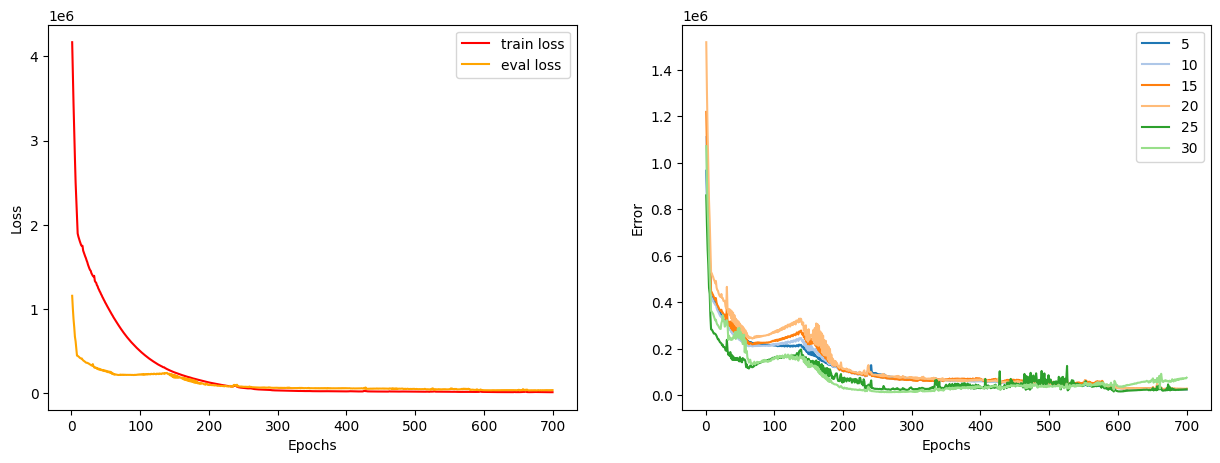

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 2, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 700, 'early_stopping' : 100, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/10/2024, 16:08:04",214050,195370,349666,0.005,32,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4600246.146381579, 4172647.755756579, 3780432...","[1243113.1310471755, 1094469.6147273136, 96192...","{5: [tensor(1044193.0625), tensor(932709.3125)...","{5: tensor(214050.9531), 10: tensor(195370.062..."
1,"04/10/2024, 16:51:44",25951,24926,25643,0.010,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4167401.966282895, 3774465.2976973685, 342633...","[1156171.3317307692, 1002759.4519230769, 87645...","{5: [tensor(966874.6875), tensor(850389.), ten...","{5: tensor(25951.9375), 10: tensor(24926.3535)..."


In [ ]:
# date_time_ = str(date_time).replace("/","_")
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder']  + date_time_

with open(results_path , 'wb') as f:
  pickle.dump(exp_record, f)

100%|██████████| 7/7 [00:00<00:00, 17.84it/s]


epoch 0: train loss = 4246248.975, eval loss = 1238016.1964285714


100%|██████████| 7/7 [00:00<00:00, 17.81it/s]


epoch 1: train loss = 3992137.15, eval loss = 1145974.049107143


100%|██████████| 7/7 [00:00<00:00, 13.28it/s]


epoch 2: train loss = 3741896.675, eval loss = 1048622.9464285714


100%|██████████| 7/7 [00:00<00:00, 11.64it/s]


epoch 3: train loss = 3525284.3125, eval loss = 966530.7433035715


100%|██████████| 7/7 [00:00<00:00, 19.44it/s]


epoch 4: train loss = 3286654.5125, eval loss = 916903.6785714285


100%|██████████| 7/7 [00:00<00:00, 18.98it/s]


epoch 5: train loss = 3226633.2125, eval loss = 875561.3303571428


100%|██████████| 7/7 [00:00<00:00, 18.49it/s]


epoch 6: train loss = 3126850.1375, eval loss = 869399.390625


100%|██████████| 7/7 [00:00<00:00, 18.74it/s]


epoch 7: train loss = 3112447.6875, eval loss = 862367.2790178572


100%|██████████| 7/7 [00:00<00:00, 11.91it/s]


epoch 8: train loss = 3083779.61875, eval loss = 855464.1651785715


100%|██████████| 7/7 [00:00<00:00, 17.24it/s]


epoch 9: train loss = 3055418.08125, eval loss = 847472.1674107143


100%|██████████| 7/7 [00:00<00:00, 17.98it/s]


epoch 10: train loss = 3033224.10625, eval loss = 838756.2678571428


100%|██████████| 7/7 [00:00<00:00, 17.70it/s]


epoch 11: train loss = 3010946.05, eval loss = 831077.8080357143


100%|██████████| 7/7 [00:00<00:00, 17.84it/s]


epoch 12: train loss = 2989493.55625, eval loss = 824373.0401785715


100%|██████████| 7/7 [00:00<00:00, 12.44it/s]


epoch 13: train loss = 2968171.24375, eval loss = 817449.203125


100%|██████████| 7/7 [00:00<00:00, 17.41it/s]


epoch 14: train loss = 2946762.625, eval loss = 809830.2008928572


100%|██████████| 7/7 [00:00<00:00, 18.24it/s]


epoch 15: train loss = 2925451.41875, eval loss = 802241.4196428572


100%|██████████| 7/7 [00:00<00:00, 17.21it/s]


epoch 16: train loss = 2904175.00625, eval loss = 795205.9866071428


100%|██████████| 7/7 [00:00<00:00, 17.80it/s]


epoch 17: train loss = 2882787.05625, eval loss = 788491.375


100%|██████████| 7/7 [00:00<00:00, 12.55it/s]


epoch 18: train loss = 2861180.59375, eval loss = 781951.390625


100%|██████████| 7/7 [00:00<00:00, 17.41it/s]


epoch 19: train loss = 2839212.74375, eval loss = 776218.2276785715


100%|██████████| 7/7 [00:00<00:00, 18.79it/s]


epoch 20: train loss = 2816904.1, eval loss = 771238.1026785715


100%|██████████| 7/7 [00:00<00:00, 16.69it/s]


epoch 21: train loss = 2794613.5, eval loss = 765551.0200892857


100%|██████████| 7/7 [00:00<00:00, 17.92it/s]


epoch 22: train loss = 2772323.55625, eval loss = 758979.6383928572


100%|██████████| 7/7 [00:00<00:00, 12.37it/s]


epoch 23: train loss = 2750318.275, eval loss = 751713.6004464285


100%|██████████| 7/7 [00:00<00:00, 18.40it/s]


epoch 24: train loss = 2728580.79375, eval loss = 743783.8236607143


100%|██████████| 7/7 [00:00<00:00, 17.38it/s]


epoch 25: train loss = 2707047.7125, eval loss = 735554.734375


100%|██████████| 7/7 [00:00<00:00, 10.41it/s]


epoch 26: train loss = 2685596.49375, eval loss = 727253.5066964285


100%|██████████| 7/7 [00:00<00:00, 17.50it/s]


epoch 27: train loss = 2664054.41875, eval loss = 718472.2823660715


100%|██████████| 7/7 [00:00<00:00, 17.67it/s]


epoch 28: train loss = 2642292.99375, eval loss = 709775.8995535715


100%|██████████| 7/7 [00:00<00:00, 18.54it/s]


epoch 29: train loss = 2620217.6125, eval loss = 701798.3984375


100%|██████████| 7/7 [00:00<00:00, 17.75it/s]


epoch 30: train loss = 2598125.09375, eval loss = 693806.5669642857


100%|██████████| 7/7 [00:00<00:00, 13.45it/s]


epoch 31: train loss = 2576016.24375, eval loss = 686300.0345982143


100%|██████████| 7/7 [00:00<00:00, 18.14it/s]


epoch 32: train loss = 2555779.53125, eval loss = 680597.8805803572


100%|██████████| 7/7 [00:00<00:00, 17.91it/s]


epoch 33: train loss = 2535596.7125, eval loss = 672897.2700892857


100%|██████████| 7/7 [00:00<00:00, 17.82it/s]


epoch 34: train loss = 2515844.8375, eval loss = 666595.5424107143


100%|██████████| 7/7 [00:00<00:00, 17.00it/s]


epoch 35: train loss = 2496363.375, eval loss = 660321.5558035715


100%|██████████| 7/7 [00:00<00:00, 12.82it/s]


epoch 36: train loss = 2477156.5125, eval loss = 654048.3616071428


100%|██████████| 7/7 [00:00<00:00, 18.33it/s]


epoch 37: train loss = 2458078.41875, eval loss = 647876.0479910715


100%|██████████| 7/7 [00:00<00:00, 17.94it/s]


epoch 38: train loss = 2439206.3375, eval loss = 641935.9341517857


100%|██████████| 7/7 [00:00<00:00, 17.28it/s]


epoch 39: train loss = 2420499.4875, eval loss = 636051.5167410715


100%|██████████| 7/7 [00:00<00:00, 17.45it/s]


epoch 40: train loss = 2401927.76875, eval loss = 630214.2455357143


100%|██████████| 7/7 [00:00<00:00, 12.99it/s]


epoch 41: train loss = 2383503.675, eval loss = 624557.9084821428


100%|██████████| 7/7 [00:00<00:00, 18.59it/s]


epoch 42: train loss = 2365218.40625, eval loss = 619031.1997767857


100%|██████████| 7/7 [00:00<00:00, 17.91it/s]


epoch 43: train loss = 2347072.46875, eval loss = 613732.6473214285


100%|██████████| 7/7 [00:00<00:00, 14.84it/s]


epoch 44: train loss = 2329065.8625, eval loss = 608692.0100446428


100%|██████████| 7/7 [00:00<00:00, 18.60it/s]


epoch 45: train loss = 2311204.38125, eval loss = 603887.9609375


100%|██████████| 7/7 [00:00<00:00, 12.68it/s]


epoch 46: train loss = 2293493.225, eval loss = 599030.8225446428


100%|██████████| 7/7 [00:00<00:00, 17.24it/s]


epoch 47: train loss = 2275910.34375, eval loss = 593262.4430803572


100%|██████████| 7/7 [00:00<00:00, 18.40it/s]


epoch 48: train loss = 2258254.4, eval loss = 586645.9966517857


100%|██████████| 7/7 [00:00<00:00, 10.51it/s]


epoch 49: train loss = 2240265.525, eval loss = 581016.9910714285


100%|██████████| 7/7 [00:00<00:00, 17.58it/s]


epoch 50: train loss = 2222286.11875, eval loss = 576844.0133928572


100%|██████████| 7/7 [00:00<00:00, 16.96it/s]


epoch 51: train loss = 2204663.48125, eval loss = 573498.4899553572


100%|██████████| 7/7 [00:00<00:00, 17.59it/s]


epoch 52: train loss = 2187400.3875, eval loss = 570329.9631696428


100%|██████████| 7/7 [00:00<00:00, 17.09it/s]


epoch 53: train loss = 2170453.44375, eval loss = 566552.9542410715


100%|██████████| 7/7 [00:00<00:00, 13.36it/s]


epoch 54: train loss = 2153726.275, eval loss = 561901.1428571428


100%|██████████| 7/7 [00:00<00:00, 18.04it/s]


epoch 55: train loss = 2137126.53125, eval loss = 556714.8214285715


100%|██████████| 7/7 [00:00<00:00, 18.72it/s]


epoch 56: train loss = 2120564.95625, eval loss = 551330.7879464285


100%|██████████| 7/7 [00:00<00:00, 18.59it/s]


epoch 57: train loss = 2103979.225, eval loss = 546065.8616071428


100%|██████████| 7/7 [00:00<00:00, 18.00it/s]


epoch 58: train loss = 2087360.81875, eval loss = 541171.7410714285


100%|██████████| 7/7 [00:00<00:00, 11.47it/s]


epoch 59: train loss = 2070778.875, eval loss = 536738.4330357143


100%|██████████| 7/7 [00:00<00:00, 16.82it/s]


epoch 60: train loss = 2054327.99375, eval loss = 532630.3236607143


100%|██████████| 7/7 [00:00<00:00, 18.09it/s]


epoch 61: train loss = 2038063.96875, eval loss = 528632.9676339285


100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


epoch 62: train loss = 2021994.2375, eval loss = 524582.5758928572


100%|██████████| 7/7 [00:00<00:00, 17.52it/s]


epoch 63: train loss = 2006092.63125, eval loss = 520450.96875


100%|██████████| 7/7 [00:00<00:00, 11.23it/s]


epoch 64: train loss = 1990330.46875, eval loss = 516305.76897321426


100%|██████████| 7/7 [00:00<00:00, 18.29it/s]


epoch 65: train loss = 1974694.14375, eval loss = 512153.45089285716


100%|██████████| 7/7 [00:00<00:00, 16.99it/s]


epoch 66: train loss = 1959157.25625, eval loss = 507897.125


100%|██████████| 7/7 [00:00<00:00, 18.70it/s]


epoch 67: train loss = 1943637.61875, eval loss = 503558.38616071426


100%|██████████| 7/7 [00:00<00:00, 17.91it/s]


epoch 68: train loss = 1928065.1875, eval loss = 499321.71316964284


100%|██████████| 7/7 [00:00<00:00, 12.64it/s]


epoch 69: train loss = 1912507.6125, eval loss = 495282.83035714284


100%|██████████| 7/7 [00:00<00:00, 17.57it/s]


epoch 70: train loss = 1897067.15, eval loss = 491386.3917410714


100%|██████████| 7/7 [00:00<00:00, 18.08it/s]


epoch 71: train loss = 1881774.6375, eval loss = 487593.9609375


100%|██████████| 7/7 [00:00<00:00, 11.54it/s]


epoch 72: train loss = 1866632.1375, eval loss = 483907.23772321426


100%|██████████| 7/7 [00:00<00:00, 18.26it/s]


epoch 73: train loss = 1851640.8375, eval loss = 480273.9520089286


100%|██████████| 7/7 [00:00<00:00, 15.87it/s]


epoch 74: train loss = 1836793.55, eval loss = 476622.45535714284


100%|██████████| 7/7 [00:00<00:00, 17.71it/s]


epoch 75: train loss = 1822071.70625, eval loss = 472830.3660714286


100%|██████████| 7/7 [00:00<00:00, 18.31it/s]


epoch 76: train loss = 1807455.76875, eval loss = 468829.37946428574


100%|██████████| 7/7 [00:00<00:00, 11.18it/s]


epoch 77: train loss = 1792937.1375, eval loss = 464653.89397321426


100%|██████████| 7/7 [00:00<00:00, 19.17it/s]


epoch 78: train loss = 1778533.05625, eval loss = 460372.87834821426


100%|██████████| 7/7 [00:00<00:00, 18.73it/s]


epoch 79: train loss = 1764279.934375, eval loss = 456030.515625


100%|██████████| 7/7 [00:00<00:00, 18.02it/s]


epoch 80: train loss = 1750070.29375, eval loss = 451670.73660714284


100%|██████████| 7/7 [00:00<00:00, 18.88it/s]


epoch 81: train loss = 1735593.409375, eval loss = 447794.8214285714


100%|██████████| 7/7 [00:00<00:00, 12.34it/s]


epoch 82: train loss = 1721113.371875, eval loss = 444376.6808035714


100%|██████████| 7/7 [00:00<00:00, 17.95it/s]


epoch 83: train loss = 1706990.021875, eval loss = 440500.7098214286


100%|██████████| 7/7 [00:00<00:00, 16.62it/s]


epoch 84: train loss = 1693009.46875, eval loss = 436138.9620535714


100%|██████████| 7/7 [00:00<00:00, 18.05it/s]


epoch 85: train loss = 1679095.578125, eval loss = 432292.16964285716


100%|██████████| 7/7 [00:00<00:00, 18.46it/s]


epoch 86: train loss = 1665297.25, eval loss = 428483.15066964284


100%|██████████| 7/7 [00:00<00:00, 12.47it/s]


epoch 87: train loss = 1651601.771875, eval loss = 424557.69196428574


100%|██████████| 7/7 [00:00<00:00, 17.89it/s]


epoch 88: train loss = 1637989.428125, eval loss = 420500.09821428574


100%|██████████| 7/7 [00:00<00:00, 17.87it/s]


epoch 89: train loss = 1624433.8375, eval loss = 416230.7589285714


100%|██████████| 7/7 [00:00<00:00, 18.50it/s]


epoch 90: train loss = 1610920.01875, eval loss = 412066.859375


100%|██████████| 7/7 [00:00<00:00, 18.33it/s]


epoch 91: train loss = 1597464.96875, eval loss = 408063.9698660714


100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


epoch 92: train loss = 1584135.059375, eval loss = 404387.63504464284


100%|██████████| 7/7 [00:00<00:00, 17.80it/s]


epoch 93: train loss = 1570995.603125, eval loss = 400868.90848214284


100%|██████████| 7/7 [00:00<00:00, 17.68it/s]


epoch 94: train loss = 1558044.91875, eval loss = 397251.5926339286


100%|██████████| 7/7 [00:00<00:00, 16.23it/s]


epoch 95: train loss = 1545041.621875, eval loss = 393203.4207589286


100%|██████████| 7/7 [00:00<00:00, 18.48it/s]


epoch 96: train loss = 1531786.75625, eval loss = 389001.8917410714


100%|██████████| 7/7 [00:00<00:00, 12.76it/s]


epoch 97: train loss = 1518605.225, eval loss = 385122.7645089286


100%|██████████| 7/7 [00:00<00:00, 17.25it/s]


epoch 98: train loss = 1505681.103125, eval loss = 381676.1573660714


100%|██████████| 7/7 [00:00<00:00, 16.64it/s]


epoch 99: train loss = 1492923.871875, eval loss = 378783.87723214284


100%|██████████| 7/7 [00:00<00:00, 10.66it/s]


epoch 100: train loss = 1480196.30625, eval loss = 376676.48995535716


100%|██████████| 7/7 [00:00<00:00, 17.62it/s]


epoch 101: train loss = 1467527.734375, eval loss = 374740.37053571426


100%|██████████| 7/7 [00:00<00:00, 18.15it/s]


epoch 102: train loss = 1455376.44375, eval loss = 372535.72991071426


100%|██████████| 7/7 [00:00<00:00, 18.12it/s]


epoch 103: train loss = 1444257.19375, eval loss = 369006.6104910714


100%|██████████| 7/7 [00:00<00:00, 17.56it/s]


epoch 104: train loss = 1432399.06875, eval loss = 362757.83147321426


100%|██████████| 7/7 [00:00<00:00, 13.22it/s]


epoch 105: train loss = 1419152.696875, eval loss = 361533.75223214284


100%|██████████| 7/7 [00:00<00:00, 17.31it/s]


epoch 106: train loss = 1406585.91875, eval loss = 357657.2042410714


100%|██████████| 7/7 [00:00<00:00, 18.52it/s]


epoch 107: train loss = 1394030.178125, eval loss = 355500.11941964284


100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


epoch 108: train loss = 1381940.34375, eval loss = 357288.7421875


100%|██████████| 7/7 [00:00<00:00, 16.96it/s]


epoch 109: train loss = 1370098.14375, eval loss = 356020.99665178574


100%|██████████| 7/7 [00:00<00:00, 12.29it/s]


epoch 110: train loss = 1358602.459375, eval loss = 356351.88058035716


100%|██████████| 7/7 [00:00<00:00, 17.86it/s]


epoch 111: train loss = 1347299.5625, eval loss = 356875.4051339286


100%|██████████| 7/7 [00:00<00:00, 17.42it/s]


epoch 112: train loss = 1335813.753125, eval loss = 353683.26227678574


100%|██████████| 7/7 [00:00<00:00, 18.08it/s]


epoch 113: train loss = 1324094.134375, eval loss = 350590.30022321426


100%|██████████| 7/7 [00:00<00:00, 17.67it/s]


epoch 114: train loss = 1312499.33125, eval loss = 348022.66629464284


100%|██████████| 7/7 [00:00<00:00, 12.09it/s]


epoch 115: train loss = 1301142.940625, eval loss = 347518.43973214284


100%|██████████| 7/7 [00:00<00:00, 17.89it/s]


epoch 116: train loss = 1289971.496875, eval loss = 347615.6261160714


100%|██████████| 7/7 [00:00<00:00, 17.78it/s]


epoch 117: train loss = 1278953.9875, eval loss = 348970.1651785714


100%|██████████| 7/7 [00:00<00:00, 17.77it/s]


epoch 118: train loss = 1268252.55, eval loss = 349524.8370535714


100%|██████████| 7/7 [00:00<00:00, 17.11it/s]


epoch 119: train loss = 1257704.771875, eval loss = 347947.2020089286


100%|██████████| 7/7 [00:00<00:00, 12.61it/s]


epoch 120: train loss = 1246598.896875, eval loss = 344540.98102678574


100%|██████████| 7/7 [00:00<00:00, 18.81it/s]


epoch 121: train loss = 1235432.540625, eval loss = 343517.84821428574


100%|██████████| 7/7 [00:00<00:00, 17.80it/s]


epoch 122: train loss = 1224577.49375, eval loss = 342296.9933035714


100%|██████████| 7/7 [00:00<00:00, 10.86it/s]


epoch 123: train loss = 1213934.50625, eval loss = 341609.2511160714


100%|██████████| 7/7 [00:00<00:00, 17.37it/s]


epoch 124: train loss = 1203442.446875, eval loss = 340500.17633928574


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


epoch 125: train loss = 1193114.296875, eval loss = 339649.9921875


100%|██████████| 7/7 [00:00<00:00, 11.71it/s]


epoch 126: train loss = 1182877.79375, eval loss = 337580.42522321426


100%|██████████| 7/7 [00:00<00:00, 11.35it/s]


epoch 127: train loss = 1172621.04375, eval loss = 335563.828125


100%|██████████| 7/7 [00:00<00:00, 18.26it/s]


epoch 128: train loss = 1162357.478125, eval loss = 334087.3984375


100%|██████████| 7/7 [00:00<00:00, 18.79it/s]


epoch 129: train loss = 1152169.0, eval loss = 332894.265625


100%|██████████| 7/7 [00:00<00:00, 17.65it/s]


epoch 130: train loss = 1142107.69375, eval loss = 331272.70758928574


100%|██████████| 7/7 [00:00<00:00, 18.11it/s]


epoch 131: train loss = 1132180.23125, eval loss = 329499.63058035716


100%|██████████| 7/7 [00:00<00:00, 11.71it/s]


epoch 132: train loss = 1122378.390625, eval loss = 327725.19977678574


100%|██████████| 7/7 [00:00<00:00, 17.43it/s]


epoch 133: train loss = 1112667.215625, eval loss = 326566.81473214284


100%|██████████| 7/7 [00:00<00:00, 17.16it/s]


epoch 134: train loss = 1103021.5, eval loss = 325522.1238839286


100%|██████████| 7/7 [00:00<00:00, 17.61it/s]


epoch 135: train loss = 1093377.059375, eval loss = 324625.9073660714


100%|██████████| 7/7 [00:00<00:00, 17.89it/s]


epoch 136: train loss = 1083748.090625, eval loss = 323567.5479910714


100%|██████████| 7/7 [00:00<00:00, 13.43it/s]


epoch 137: train loss = 1074197.39375, eval loss = 322322.70870535716


100%|██████████| 7/7 [00:00<00:00, 17.27it/s]


epoch 138: train loss = 1064760.3890625, eval loss = 320974.34933035716


100%|██████████| 7/7 [00:00<00:00, 17.89it/s]


epoch 139: train loss = 1055436.18125, eval loss = 319832.98995535716


100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


epoch 140: train loss = 1046215.84375, eval loss = 319015.12834821426


100%|██████████| 7/7 [00:00<00:00, 18.21it/s]


epoch 141: train loss = 1037081.246875, eval loss = 318361.7578125


100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


epoch 142: train loss = 1028004.6625, eval loss = 317721.00558035716


100%|██████████| 7/7 [00:00<00:00, 18.38it/s]


epoch 143: train loss = 1018958.521875, eval loss = 317084.94977678574


100%|██████████| 7/7 [00:00<00:00, 18.33it/s]


epoch 144: train loss = 1009947.3234375, eval loss = 316474.5457589286


100%|██████████| 7/7 [00:00<00:00, 15.16it/s]


epoch 145: train loss = 1001001.578125, eval loss = 315774.79129464284


100%|██████████| 7/7 [00:00<00:00, 18.13it/s]


epoch 146: train loss = 992145.2171875, eval loss = 314936.87946428574


100%|██████████| 7/7 [00:00<00:00, 12.87it/s]


epoch 147: train loss = 983382.8328125, eval loss = 314055.0870535714


100%|██████████| 7/7 [00:00<00:00, 17.05it/s]


epoch 148: train loss = 974710.7984375, eval loss = 313273.62834821426


100%|██████████| 7/7 [00:00<00:00, 17.70it/s]


epoch 149: train loss = 966118.8421875, eval loss = 312455.47991071426


100%|██████████| 7/7 [00:00<00:00, 10.13it/s]


epoch 150: train loss = 957592.9359375, eval loss = 312119.16071428574


100%|██████████| 7/7 [00:00<00:00, 17.22it/s]


epoch 151: train loss = 949114.2015625, eval loss = 311973.9285714286


100%|██████████| 7/7 [00:00<00:00, 16.90it/s]


epoch 152: train loss = 940678.33125, eval loss = 311484.7734375


100%|██████████| 7/7 [00:00<00:00, 18.15it/s]


epoch 153: train loss = 932296.5234375, eval loss = 310664.80691964284


100%|██████████| 7/7 [00:00<00:00, 16.72it/s]


epoch 154: train loss = 923984.5421875, eval loss = 309746.0703125


100%|██████████| 7/7 [00:00<00:00, 12.79it/s]


epoch 155: train loss = 915751.9515625, eval loss = 308808.3203125


100%|██████████| 7/7 [00:00<00:00, 18.38it/s]


epoch 156: train loss = 907600.671875, eval loss = 307869.99665178574


100%|██████████| 7/7 [00:00<00:00, 17.02it/s]


epoch 157: train loss = 899526.4140625, eval loss = 306993.8984375


100%|██████████| 7/7 [00:00<00:00, 17.98it/s]


epoch 158: train loss = 891521.1796875, eval loss = 306216.42745535716


100%|██████████| 7/7 [00:00<00:00, 16.59it/s]


epoch 159: train loss = 883575.6859375, eval loss = 305475.93973214284


100%|██████████| 7/7 [00:00<00:00, 11.92it/s]


epoch 160: train loss = 875682.590625, eval loss = 304679.54352678574


100%|██████████| 7/7 [00:00<00:00, 18.74it/s]


epoch 161: train loss = 867841.090625, eval loss = 303792.0011160714


100%|██████████| 7/7 [00:00<00:00, 18.22it/s]


epoch 162: train loss = 860057.4515625, eval loss = 302827.56584821426


100%|██████████| 7/7 [00:00<00:00, 18.34it/s]


epoch 163: train loss = 852339.03125, eval loss = 301823.34375


100%|██████████| 7/7 [00:00<00:00, 18.45it/s]


epoch 164: train loss = 844691.2875, eval loss = 300823.2979910714


100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


epoch 165: train loss = 837115.2, eval loss = 299858.52120535716


100%|██████████| 7/7 [00:00<00:00, 18.49it/s]


epoch 166: train loss = 829609.8109375, eval loss = 298920.21875


100%|██████████| 7/7 [00:00<00:00, 18.00it/s]


epoch 167: train loss = 822172.9015625, eval loss = 297965.22098214284


100%|██████████| 7/7 [00:00<00:00, 16.49it/s]


epoch 168: train loss = 814800.1390625, eval loss = 296946.55691964284


100%|██████████| 7/7 [00:00<00:00, 18.39it/s]


epoch 169: train loss = 807485.6515625, eval loss = 295852.7488839286


100%|██████████| 7/7 [00:00<00:00, 12.14it/s]


epoch 170: train loss = 800218.8484375, eval loss = 294746.44308035716


100%|██████████| 7/7 [00:00<00:00, 18.21it/s]


epoch 171: train loss = 792988.2921875, eval loss = 293786.3348214286


100%|██████████| 7/7 [00:00<00:00, 18.27it/s]


epoch 172: train loss = 785799.5765625, eval loss = 293139.70758928574


100%|██████████| 7/7 [00:00<00:00, 10.13it/s]


epoch 173: train loss = 778689.425, eval loss = 292786.75


100%|██████████| 7/7 [00:00<00:00, 17.81it/s]


epoch 174: train loss = 771709.10625, eval loss = 292514.0558035714


100%|██████████| 7/7 [00:00<00:00, 15.96it/s]


epoch 175: train loss = 764947.7171875, eval loss = 292315.7979910714


100%|██████████| 7/7 [00:00<00:00, 17.32it/s]


epoch 176: train loss = 758423.53125, eval loss = 293338.7645089286


100%|██████████| 7/7 [00:00<00:00, 16.83it/s]


epoch 177: train loss = 751351.6140625, eval loss = 297518.2198660714


100%|██████████| 7/7 [00:00<00:00, 12.39it/s]


epoch 178: train loss = 744123.925, eval loss = 293751.6551339286


100%|██████████| 7/7 [00:00<00:00, 17.20it/s]


epoch 179: train loss = 737452.1015625, eval loss = 281272.18526785716


100%|██████████| 7/7 [00:00<00:00, 18.58it/s]


epoch 180: train loss = 730713.7296875, eval loss = 281719.3917410714


100%|██████████| 7/7 [00:00<00:00, 18.20it/s]


epoch 181: train loss = 724050.6046875, eval loss = 288673.703125


100%|██████████| 7/7 [00:00<00:00, 18.10it/s]


epoch 182: train loss = 717383.490625, eval loss = 288683.4363839286


100%|██████████| 7/7 [00:00<00:00, 12.16it/s]


epoch 183: train loss = 710883.50625, eval loss = 283222.00558035716


100%|██████████| 7/7 [00:00<00:00, 17.74it/s]


epoch 184: train loss = 704456.534375, eval loss = 280003.63504464284


100%|██████████| 7/7 [00:00<00:00, 18.52it/s]


epoch 185: train loss = 698098.42734375, eval loss = 281794.62723214284


100%|██████████| 7/7 [00:00<00:00, 18.67it/s]


epoch 186: train loss = 691750.64453125, eval loss = 282922.6875


100%|██████████| 7/7 [00:00<00:00, 17.70it/s]


epoch 187: train loss = 685420.63125, eval loss = 281927.98660714284


100%|██████████| 7/7 [00:00<00:00, 11.60it/s]


epoch 188: train loss = 679127.38515625, eval loss = 279208.4375


100%|██████████| 7/7 [00:00<00:00, 17.23it/s]


epoch 189: train loss = 672884.978125, eval loss = 277532.18973214284


100%|██████████| 7/7 [00:00<00:00, 18.16it/s]


epoch 190: train loss = 666710.03359375, eval loss = 276534.73214285716


100%|██████████| 7/7 [00:00<00:00, 17.82it/s]


epoch 191: train loss = 660603.88203125, eval loss = 276023.27790178574


100%|██████████| 7/7 [00:00<00:00, 17.75it/s]


epoch 192: train loss = 654567.86640625, eval loss = 275573.625


100%|██████████| 7/7 [00:00<00:00, 12.22it/s]


epoch 193: train loss = 648604.6328125, eval loss = 275510.77790178574


100%|██████████| 7/7 [00:00<00:00, 16.41it/s]


epoch 194: train loss = 642718.6109375, eval loss = 275345.80245535716


100%|██████████| 7/7 [00:00<00:00, 17.17it/s]


epoch 195: train loss = 636913.02734375, eval loss = 275190.32254464284


100%|██████████| 7/7 [00:00<00:00, 17.96it/s]


epoch 196: train loss = 631166.76328125, eval loss = 274719.6875


100%|██████████| 7/7 [00:00<00:00, 16.96it/s]


epoch 197: train loss = 625414.690625, eval loss = 273920.3722098214


100%|██████████| 7/7 [00:00<00:00, 11.68it/s]


epoch 198: train loss = 619615.3640625, eval loss = 272802.18582589284


100%|██████████| 7/7 [00:00<00:00, 17.91it/s]


epoch 199: train loss = 613834.89140625, eval loss = 271378.04854910716


100%|██████████| 7/7 [00:00<00:00, 17.35it/s]


epoch 200: train loss = 608153.31953125, eval loss = 269593.70145089284


100%|██████████| 7/7 [00:00<00:00, 10.51it/s]


epoch 201: train loss = 602589.77734375, eval loss = 267316.33426339284


100%|██████████| 7/7 [00:00<00:00, 18.36it/s]


epoch 202: train loss = 597140.34296875, eval loss = 265156.2606026786


100%|██████████| 7/7 [00:00<00:00, 16.53it/s]


epoch 203: train loss = 591725.96328125, eval loss = 264237.20368303574


100%|██████████| 7/7 [00:00<00:00, 17.06it/s]


epoch 204: train loss = 586224.8140625, eval loss = 265223.70926339284


100%|██████████| 7/7 [00:00<00:00, 18.26it/s]


epoch 205: train loss = 580867.4140625, eval loss = 267777.9559151786


100%|██████████| 7/7 [00:00<00:00, 12.54it/s]


epoch 206: train loss = 575866.384375, eval loss = 269923.17745535716


100%|██████████| 7/7 [00:00<00:00, 18.09it/s]


epoch 207: train loss = 571056.9875, eval loss = 273362.68526785716


100%|██████████| 7/7 [00:00<00:00, 17.60it/s]


epoch 208: train loss = 565739.675, eval loss = 277065.11941964284


100%|██████████| 7/7 [00:00<00:00, 18.23it/s]


epoch 209: train loss = 560089.7484375, eval loss = 264624.1925223214


100%|██████████| 7/7 [00:00<00:00, 17.55it/s]


epoch 210: train loss = 554741.1625, eval loss = 259864.11439732142


100%|██████████| 7/7 [00:00<00:00, 12.53it/s]


epoch 211: train loss = 549593.19296875, eval loss = 262092.9642857143


100%|██████████| 7/7 [00:00<00:00, 16.19it/s]


epoch 212: train loss = 544473.55390625, eval loss = 264844.67243303574


100%|██████████| 7/7 [00:00<00:00, 17.57it/s]


epoch 213: train loss = 539376.04453125, eval loss = 262384.67801339284


100%|██████████| 7/7 [00:00<00:00, 16.65it/s]


epoch 214: train loss = 534425.7625, eval loss = 260376.4107142857


100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


epoch 215: train loss = 529555.5203125, eval loss = 260674.18638392858


100%|██████████| 7/7 [00:00<00:00, 12.19it/s]


epoch 216: train loss = 524738.52109375, eval loss = 263328.765625


100%|██████████| 7/7 [00:00<00:00, 17.30it/s]


epoch 217: train loss = 519946.77578125, eval loss = 263630.6551339286


100%|██████████| 7/7 [00:00<00:00, 17.19it/s]


epoch 218: train loss = 515181.23125, eval loss = 262913.29910714284


100%|██████████| 7/7 [00:00<00:00, 16.42it/s]


epoch 219: train loss = 510461.09609375, eval loss = 261479.7505580357


100%|██████████| 7/7 [00:00<00:00, 16.57it/s]


epoch 220: train loss = 505757.546875, eval loss = 261324.0708705357


100%|██████████| 7/7 [00:00<00:00, 12.91it/s]


epoch 221: train loss = 501084.57265625, eval loss = 260692.1841517857


100%|██████████| 7/7 [00:00<00:00, 16.88it/s]


epoch 222: train loss = 496452.02734375, eval loss = 260803.9056919643


100%|██████████| 7/7 [00:00<00:00, 17.73it/s]


epoch 223: train loss = 491878.8046875, eval loss = 259988.0708705357


100%|██████████| 7/7 [00:00<00:00, 10.71it/s]


epoch 224: train loss = 487365.425, eval loss = 260216.9609375


100%|██████████| 7/7 [00:00<00:00, 18.22it/s]


epoch 225: train loss = 482922.9375, eval loss = 259194.0318080357


100%|██████████| 7/7 [00:00<00:00, 17.80it/s]


epoch 226: train loss = 478550.625, eval loss = 259382.05859375


100%|██████████| 7/7 [00:00<00:00, 18.04it/s]


epoch 227: train loss = 474261.4625, eval loss = 258596.046875


100%|██████████| 7/7 [00:00<00:00, 17.77it/s]


epoch 228: train loss = 470021.19609375, eval loss = 258763.6060267857


100%|██████████| 7/7 [00:00<00:00, 12.37it/s]


epoch 229: train loss = 465810.3296875, eval loss = 258800.9575892857


100%|██████████| 7/7 [00:00<00:00, 18.36it/s]


epoch 230: train loss = 461554.753515625, eval loss = 258323.77622767858


100%|██████████| 7/7 [00:00<00:00, 17.30it/s]


epoch 231: train loss = 457202.8953125, eval loss = 259408.34877232142

Early stoping after 231 epochs. eval loss did not imporve for more than 20 epochs

Finished Training:
Best metrics are:
Best loss = 195828.203125
Best train loss = 549593.19296875
Best eval loss = 262092.9642857143
Best 5sec eval = 282335.875
Best 10sec eval = 195828.203125
Best 15sec eval = 215593.953125
Best 20sec eval = 248199.59375
Best 25sec eval = 125232.3671875
Best 30sec eval = 127120.0625


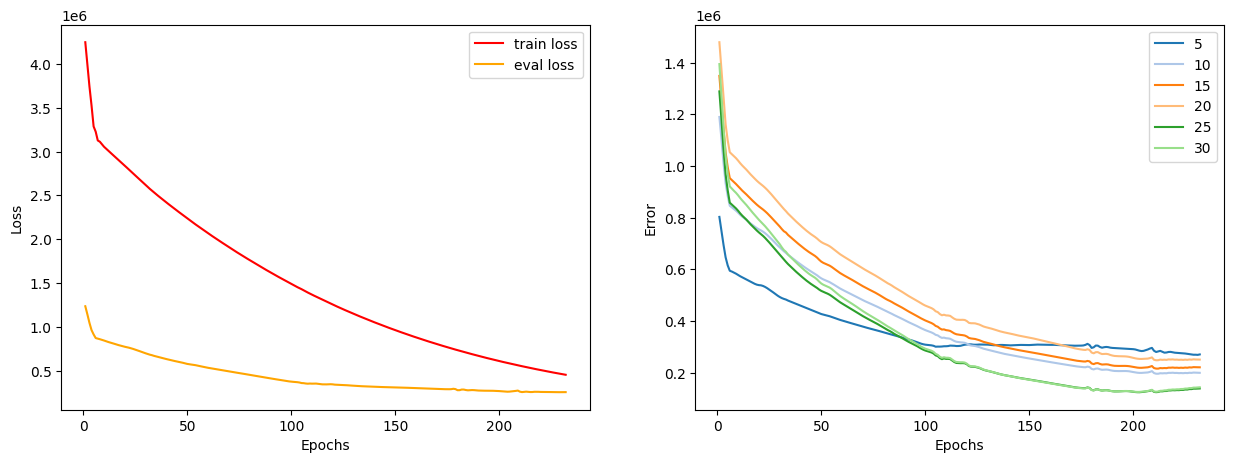

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 64, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 20, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/04/2024, 09:56:52",560425,203240,235425,0.05,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4225843.947368421, 3766551.3799342103, 336935...","[1372629.9775015025, 1187492.4270770734, 10263...","{5: [tensor(2009134.6250), tensor(1775395.), t...","{5: tensor(560425.7500), 10: tensor(203240.312..."
1,"04/04/2024, 10:17:14",282335,195828,248199,0.01,64,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 64, 'optimizer_type': <class 't...","[4246248.975, 3992137.15, 3741896.675, 3525284...","[1238016.1964285714, 1145974.049107143, 104862...","{5: [tensor(802754.0625), tensor(749276.8750),...","{5: tensor(282335.8750), 10: tensor(195828.203..."


In [ ]:
# date_time_ = str(date_time).replace("/","_")
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder']  + date_time_

with open(results_path , 'wb') as f:
  pickle.dump(exp_record, f)

100%|██████████| 18/18 [00:00<00:00, 19.93it/s]


epoch 0: train loss = 3953798.0241815476, eval loss = 5097635.592881944


100%|██████████| 18/18 [00:00<00:00, 20.47it/s]


epoch 1: train loss = 3587440.045014881, eval loss = 4814700.728298611


100%|██████████| 18/18 [00:00<00:00, 20.75it/s]


epoch 2: train loss = 3252307.004092262, eval loss = 4542583.380208333


100%|██████████| 18/18 [00:01<00:00, 16.37it/s]


epoch 3: train loss = 2934933.1279761903, eval loss = 4294022.776041667


100%|██████████| 18/18 [00:01<00:00, 13.96it/s]


epoch 4: train loss = 2644446.2079613097, eval loss = 4047389.017361111


100%|██████████| 18/18 [00:01<00:00, 14.41it/s]


epoch 5: train loss = 2373144.5617559524, eval loss = 3823885.4383680555


100%|██████████| 18/18 [00:01<00:00, 14.72it/s]


epoch 6: train loss = 2125295.6901041665, eval loss = 3607447.4969618055


100%|██████████| 18/18 [00:01<00:00, 13.75it/s]


epoch 7: train loss = 1901119.373139881, eval loss = 3420389.640190972


100%|██████████| 18/18 [00:00<00:00, 18.92it/s]


epoch 8: train loss = 1699466.7101934524, eval loss = 3227440.056857639


100%|██████████| 18/18 [00:00<00:00, 20.13it/s]


epoch 9: train loss = 1510524.5561755951, eval loss = 3052486.4227430555


100%|██████████| 18/18 [00:00<00:00, 21.38it/s]


epoch 10: train loss = 1379448.6313244049, eval loss = 2894097.9641927085


100%|██████████| 18/18 [00:00<00:00, 20.93it/s]


epoch 11: train loss = 1247677.2299107143, eval loss = 2754966.230685764


100%|██████████| 18/18 [00:00<00:00, 20.61it/s]


epoch 12: train loss = 1110535.3603050595, eval loss = 2620768.246527778


100%|██████████| 18/18 [00:00<00:00, 20.60it/s]


epoch 13: train loss = 1014667.1331845238, eval loss = 2491815.867621528


100%|██████████| 18/18 [00:00<00:00, 20.78it/s]


epoch 14: train loss = 878744.2717633928, eval loss = 2375389.411892361


100%|██████████| 18/18 [00:00<00:00, 20.58it/s]


epoch 15: train loss = 792963.1214657738, eval loss = 2270387.054904514


100%|██████████| 18/18 [00:00<00:00, 20.89it/s]


epoch 16: train loss = 705834.0856584822, eval loss = 2172781.329861111


100%|██████████| 18/18 [00:00<00:00, 20.58it/s]


epoch 17: train loss = 637320.6858258928, eval loss = 2087918.8020833333


100%|██████████| 18/18 [00:00<00:00, 21.49it/s]


epoch 18: train loss = 575758.2537202381, eval loss = 2001843.5658637153


100%|██████████| 18/18 [00:00<00:00, 21.25it/s]


epoch 19: train loss = 521743.00055803574, eval loss = 1925758.5066189235


100%|██████████| 18/18 [00:00<00:00, 20.56it/s]


epoch 20: train loss = 477021.095703125, eval loss = 1857522.958875868


100%|██████████| 18/18 [00:00<00:00, 20.38it/s]


epoch 21: train loss = 434893.177734375, eval loss = 1794602.7940538195


100%|██████████| 18/18 [00:01<00:00, 17.29it/s]


epoch 22: train loss = 398547.44573102676, eval loss = 1736591.4193793403


100%|██████████| 18/18 [00:01<00:00, 13.28it/s]


epoch 23: train loss = 368684.6716889881, eval loss = 1682723.232313368


100%|██████████| 18/18 [00:01<00:00, 14.48it/s]


epoch 24: train loss = 339938.201125372, eval loss = 1635612.326388889


100%|██████████| 18/18 [00:01<00:00, 14.09it/s]


epoch 25: train loss = 313895.8570963542, eval loss = 1586690.7899305555


100%|██████████| 18/18 [00:00<00:00, 18.24it/s]


epoch 26: train loss = 290046.45949590777, eval loss = 1541133.6963975695


100%|██████████| 18/18 [00:00<00:00, 20.58it/s]


epoch 27: train loss = 273496.26223028277, eval loss = 1509801.222547743


100%|██████████| 18/18 [00:00<00:00, 20.16it/s]


epoch 28: train loss = 256145.75558035713, eval loss = 1465057.8828125


100%|██████████| 18/18 [00:00<00:00, 20.65it/s]


epoch 29: train loss = 233779.30880301338, eval loss = 1427507.772298177


100%|██████████| 18/18 [00:00<00:00, 20.86it/s]


epoch 30: train loss = 217226.23351469493, eval loss = 1394183.2109917535


100%|██████████| 18/18 [00:00<00:00, 20.58it/s]


epoch 31: train loss = 200500.44421968007, eval loss = 1362531.640407986


100%|██████████| 18/18 [00:00<00:00, 20.82it/s]


epoch 32: train loss = 186948.670921689, eval loss = 1333193.7645399305


100%|██████████| 18/18 [00:00<00:00, 21.01it/s]


epoch 33: train loss = 175639.64346168155, eval loss = 1301239.7692599827


100%|██████████| 18/18 [00:00<00:00, 21.32it/s]


epoch 34: train loss = 169056.5089750744, eval loss = 1276093.9421115452


100%|██████████| 18/18 [00:00<00:00, 20.72it/s]


epoch 35: train loss = 159168.5855422247, eval loss = 1246967.4890407985


100%|██████████| 18/18 [00:00<00:00, 20.78it/s]


epoch 36: train loss = 151882.6908249628, eval loss = 1260204.802734375


100%|██████████| 18/18 [00:00<00:00, 20.96it/s]


epoch 37: train loss = 144791.47319103422, eval loss = 1211267.0074327257


100%|██████████| 18/18 [00:00<00:00, 20.28it/s]


epoch 38: train loss = 136164.33191499257, eval loss = 1231523.3933376735


100%|██████████| 18/18 [00:00<00:00, 20.84it/s]


epoch 39: train loss = 130253.69089471726, eval loss = 1210785.142361111


100%|██████████| 18/18 [00:01<00:00, 14.32it/s]


epoch 40: train loss = 125121.39421735491, eval loss = 1155926.418782552


100%|██████████| 18/18 [00:01<00:00, 13.87it/s]


epoch 41: train loss = 197391.67359561013, eval loss = 1257008.47265625


100%|██████████| 18/18 [00:01<00:00, 14.26it/s]


epoch 42: train loss = 137237.57219587054, eval loss = 1099254.6383463542


100%|██████████| 18/18 [00:01<00:00, 16.57it/s]


epoch 43: train loss = 138618.1512044271, eval loss = 1122805.5942925347


100%|██████████| 18/18 [00:00<00:00, 19.64it/s]


epoch 44: train loss = 130643.70407831101, eval loss = 1084801.188639323


100%|██████████| 18/18 [00:00<00:00, 19.60it/s]


epoch 45: train loss = 111667.31531343007, eval loss = 1094138.7720811632


100%|██████████| 18/18 [00:00<00:00, 20.73it/s]


epoch 46: train loss = 101584.68901134672, eval loss = 1070611.8483615452


100%|██████████| 18/18 [00:00<00:00, 20.71it/s]


epoch 47: train loss = 93050.34574962797, eval loss = 1025507.094672309


100%|██████████| 18/18 [00:00<00:00, 20.14it/s]


epoch 48: train loss = 81636.17740885417, eval loss = 1038319.9155815972


100%|██████████| 18/18 [00:00<00:00, 20.61it/s]


epoch 49: train loss = 77149.58521670387, eval loss = 1025713.8417426215


100%|██████████| 18/18 [00:00<00:00, 20.21it/s]


epoch 50: train loss = 70471.61637369792, eval loss = 1003599.9653862847


100%|██████████| 18/18 [00:01<00:00, 16.86it/s]


epoch 51: train loss = 67444.43765113468, eval loss = 976223.771592882


100%|██████████| 18/18 [00:00<00:00, 20.08it/s]


epoch 52: train loss = 65049.12016369047, eval loss = 962882.239203559


100%|██████████| 18/18 [00:00<00:00, 20.01it/s]


epoch 53: train loss = 63492.92088681176, eval loss = 957186.0993381076


100%|██████████| 18/18 [00:00<00:00, 20.28it/s]


epoch 54: train loss = 58334.90436662947, eval loss = 949839.827094184


100%|██████████| 18/18 [00:00<00:00, 21.10it/s]


epoch 55: train loss = 54472.37010556176, eval loss = 934945.2664659289


100%|██████████| 18/18 [00:00<00:00, 20.49it/s]


epoch 56: train loss = 52194.97652762277, eval loss = 918073.6725802951


100%|██████████| 18/18 [00:01<00:00, 17.18it/s]


epoch 57: train loss = 51011.485514322914, eval loss = 898941.8696831597


100%|██████████| 18/18 [00:01<00:00, 14.60it/s]


epoch 58: train loss = 52322.75845191592, eval loss = 877772.81640625


100%|██████████| 18/18 [00:01<00:00, 13.14it/s]


epoch 59: train loss = 51549.3037109375, eval loss = 862318.846218533


100%|██████████| 18/18 [00:01<00:00, 12.54it/s]


epoch 60: train loss = 47400.82986304873, eval loss = 866658.9230957031


100%|██████████| 18/18 [00:01<00:00, 13.11it/s]


epoch 61: train loss = 44888.67420014881, eval loss = 865085.377360026


100%|██████████| 18/18 [00:01<00:00, 14.05it/s]


epoch 62: train loss = 44313.28930082775, eval loss = 858033.5521918403


100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


epoch 63: train loss = 44240.044788178944, eval loss = 855452.726671007


100%|██████████| 18/18 [00:01<00:00, 13.78it/s]


epoch 64: train loss = 44053.70486304873, eval loss = 854168.3879665799


100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


epoch 65: train loss = 43349.280442010786, eval loss = 851318.9298502604


100%|██████████| 18/18 [00:01<00:00, 13.70it/s]


epoch 66: train loss = 42882.42344447545, eval loss = 847791.9090169271


100%|██████████| 18/18 [00:01<00:00, 13.21it/s]


epoch 67: train loss = 42374.07713681176, eval loss = 845412.9336751302


100%|██████████| 18/18 [00:01<00:00, 14.65it/s]


epoch 68: train loss = 41306.37375604539, eval loss = 840164.9439561632


100%|██████████| 18/18 [00:01<00:00, 15.31it/s]


epoch 69: train loss = 40929.685192289806, eval loss = 836564.3735080295


100%|██████████| 18/18 [00:01<00:00, 17.61it/s]


epoch 70: train loss = 40456.39070056734, eval loss = 832591.0658365885


100%|██████████| 18/18 [00:00<00:00, 18.57it/s]


epoch 71: train loss = 39234.04504394531, eval loss = 829173.6574435764


100%|██████████| 18/18 [00:00<00:00, 19.90it/s]


epoch 72: train loss = 38398.40869721912, eval loss = 824318.4324544271


100%|██████████| 18/18 [00:00<00:00, 19.79it/s]


epoch 73: train loss = 37515.8123953683, eval loss = 820147.5861545139


100%|██████████| 18/18 [00:00<00:00, 19.59it/s]


epoch 74: train loss = 36499.351951962424, eval loss = 812440.7706434461


100%|██████████| 18/18 [00:00<00:00, 19.60it/s]


epoch 75: train loss = 36083.60970633371, eval loss = 812429.0858561198


100%|██████████| 18/18 [00:00<00:00, 19.94it/s]


epoch 76: train loss = 35816.74219331287, eval loss = 805006.4372016059


100%|██████████| 18/18 [00:00<00:00, 19.73it/s]


epoch 77: train loss = 35515.87071881975, eval loss = 804197.6754828559


100%|██████████| 18/18 [00:00<00:00, 18.88it/s]


epoch 78: train loss = 34803.89508637928, eval loss = 790322.8579644097


100%|██████████| 18/18 [00:00<00:00, 18.99it/s]


epoch 79: train loss = 34364.31884765625, eval loss = 785495.6386447483


100%|██████████| 18/18 [00:00<00:00, 18.76it/s]


epoch 80: train loss = 33717.55796305338, eval loss = 765769.4175075955


100%|██████████| 18/18 [00:00<00:00, 19.43it/s]


epoch 81: train loss = 33474.523196265814, eval loss = 772642.9961480035


100%|██████████| 18/18 [00:00<00:00, 19.10it/s]


epoch 82: train loss = 32908.17104666574, eval loss = 758230.4789496528


100%|██████████| 18/18 [00:00<00:00, 19.20it/s]


epoch 83: train loss = 33474.672944568454, eval loss = 779242.1486545139


100%|██████████| 18/18 [00:00<00:00, 20.98it/s]


epoch 84: train loss = 36566.499154227124, eval loss = 753634.5290256076


100%|██████████| 18/18 [00:00<00:00, 21.28it/s]


epoch 85: train loss = 33615.30867658342, eval loss = 749056.7472059461


100%|██████████| 18/18 [00:00<00:00, 20.59it/s]


epoch 86: train loss = 33369.56131998698, eval loss = 697572.424235026


100%|██████████| 18/18 [00:00<00:00, 20.62it/s]


epoch 87: train loss = 32116.91482979911, eval loss = 717838.9779188368


100%|██████████| 18/18 [00:00<00:00, 19.92it/s]


epoch 88: train loss = 31304.40162876674, eval loss = 710688.9107801649


100%|██████████| 18/18 [00:00<00:00, 20.77it/s]


epoch 89: train loss = 30953.39561680385, eval loss = 708817.4745822483


100%|██████████| 18/18 [00:00<00:00, 21.20it/s]


epoch 90: train loss = 30683.125665573847, eval loss = 708608.0218370226


100%|██████████| 18/18 [00:00<00:00, 20.31it/s]


epoch 91: train loss = 30412.946983700705, eval loss = 718999.2233072916


100%|██████████| 18/18 [00:00<00:00, 19.87it/s]


epoch 92: train loss = 32335.497868129187, eval loss = 696412.4195692274


100%|██████████| 18/18 [00:00<00:00, 20.41it/s]


epoch 93: train loss = 36035.82605271113, eval loss = 716776.4196234809


100%|██████████| 18/18 [00:00<00:00, 19.92it/s]


epoch 94: train loss = 56696.22426641555, eval loss = 747945.8824327257


100%|██████████| 18/18 [00:00<00:00, 20.43it/s]


epoch 95: train loss = 766500.119187128, eval loss = 1699982.5672743055


100%|██████████| 18/18 [00:01<00:00, 14.70it/s]


epoch 96: train loss = 557235.693405878, eval loss = 2062523.3129340278


100%|██████████| 18/18 [00:01<00:00, 14.45it/s]


epoch 97: train loss = 152230.1396484375, eval loss = 1788082.49609375


100%|██████████| 18/18 [00:01<00:00, 14.30it/s]


epoch 98: train loss = 112692.12544177828, eval loss = 1768677.8761935765


100%|██████████| 18/18 [00:00<00:00, 18.27it/s]


epoch 99: train loss = 96147.4406389509, eval loss = 1766198.6334635417


100%|██████████| 18/18 [00:00<00:00, 21.21it/s]


epoch 100: train loss = 90775.50206938243, eval loss = 1753282.248263889


100%|██████████| 18/18 [00:00<00:00, 20.75it/s]


epoch 101: train loss = 92594.07631138393, eval loss = 1746728.6665581597


100%|██████████| 18/18 [00:00<00:00, 20.98it/s]


epoch 102: train loss = 85660.16164434524, eval loss = 1727587.510687934


100%|██████████| 18/18 [00:00<00:00, 20.24it/s]


epoch 103: train loss = 86034.93684314546, eval loss = 1721384.2922092015


100%|██████████| 18/18 [00:00<00:00, 20.71it/s]


epoch 104: train loss = 86762.20296223958, eval loss = 1718877.218967014


100%|██████████| 18/18 [00:00<00:00, 21.02it/s]


epoch 105: train loss = 83618.65011160714, eval loss = 1711112.7203776042


100%|██████████| 18/18 [00:00<00:00, 20.82it/s]


epoch 106: train loss = 81797.44144112723, eval loss = 1705491.6930338542

Early stoping after 106 epochs. eval loss did not imporve for more than 20 epochs

Finished Training:
Best metrics are:
Best loss = 599848.75
Best train loss = 33369.56131998698
Best eval loss = 697572.424235026
Best 5sec eval = 606050.6875
Best 10sec eval = 599848.75
Best 15sec eval = 831991.5
Best 20sec eval = 583681.4375
Best 25sec eval = 909794.75
Best 30sec eval = 803004.625


100%|██████████| 18/18 [00:00<00:00, 20.25it/s]


epoch 0: train loss = 3990228.407738095, eval loss = 5688982.555040147


100%|██████████| 18/18 [00:00<00:00, 20.77it/s]


epoch 1: train loss = 3899658.2589285714, eval loss = 5619698.291693794


100%|██████████| 18/18 [00:00<00:00, 19.96it/s]


epoch 2: train loss = 3830274.059151786, eval loss = 5561430.913221572


100%|██████████| 18/18 [00:00<00:00, 20.75it/s]


epoch 3: train loss = 3748442.415550595, eval loss = 5495396.021918403


100%|██████████| 18/18 [00:00<00:00, 20.32it/s]


epoch 4: train loss = 3671940.7570684524, eval loss = 5435894.485161675


100%|██████████| 18/18 [00:00<00:00, 20.78it/s]


epoch 5: train loss = 3601258.939360119, eval loss = 5373397.688151042


100%|██████████| 18/18 [00:00<00:00, 20.13it/s]


epoch 6: train loss = 3529920.601934524, eval loss = 5314298.149034288


100%|██████████| 18/18 [00:01<00:00, 16.37it/s]


epoch 7: train loss = 3459420.273065476, eval loss = 5254416.444227431


100%|██████████| 18/18 [00:01<00:00, 13.80it/s]


epoch 8: train loss = 3391007.007440476, eval loss = 5192905.562662761


100%|██████████| 18/18 [00:01<00:00, 14.11it/s]


epoch 9: train loss = 3325195.515252976, eval loss = 5131155.97414822


100%|██████████| 18/18 [00:01<00:00, 14.28it/s]


epoch 10: train loss = 3255934.710565476, eval loss = 5074372.47007921


100%|██████████| 18/18 [00:01<00:00, 15.64it/s]


epoch 11: train loss = 3189479.2678571427, eval loss = 5014850.115749783


100%|██████████| 18/18 [00:00<00:00, 18.48it/s]


epoch 12: train loss = 3123751.896949405, eval loss = 4955664.09524197


100%|██████████| 18/18 [00:00<00:00, 20.94it/s]


epoch 13: train loss = 3059052.3649553573, eval loss = 4899273.2726779515


100%|██████████| 18/18 [00:00<00:00, 20.54it/s]


epoch 14: train loss = 2995678.4352678573, eval loss = 4839706.5263671875


100%|██████████| 18/18 [00:00<00:00, 21.49it/s]


epoch 15: train loss = 2932015.725074405, eval loss = 4781843.995307075


100%|██████████| 18/18 [00:00<00:00, 21.11it/s]


epoch 16: train loss = 2870311.189360119, eval loss = 4726000.844102647


100%|██████████| 18/18 [00:00<00:00, 20.67it/s]


epoch 17: train loss = 2810751.322172619, eval loss = 4677086.694173177


100%|██████████| 18/18 [00:00<00:00, 20.93it/s]


epoch 18: train loss = 2757115.6662946427, eval loss = 4613794.052490234


100%|██████████| 18/18 [00:00<00:00, 20.47it/s]


epoch 19: train loss = 2695473.879092262, eval loss = 4557812.730929905


100%|██████████| 18/18 [00:00<00:00, 20.18it/s]


epoch 20: train loss = 2635879.015625, eval loss = 4513980.996826172


100%|██████████| 18/18 [00:00<00:00, 20.66it/s]


epoch 21: train loss = 2581638.597842262, eval loss = 4453865.180094401


100%|██████████| 18/18 [00:00<00:00, 20.78it/s]


epoch 22: train loss = 2524729.3232886903, eval loss = 4404900.770209419


100%|██████████| 18/18 [00:00<00:00, 20.64it/s]


epoch 23: train loss = 2471900.3545386903, eval loss = 4352545.018215603


100%|██████████| 18/18 [00:00<00:00, 20.81it/s]


epoch 24: train loss = 2419215.8623511903, eval loss = 4298876.658203125


100%|██████████| 18/18 [00:00<00:00, 20.18it/s]


epoch 25: train loss = 2367113.65625, eval loss = 4249344.698621962


100%|██████████| 18/18 [00:00<00:00, 18.41it/s]


epoch 26: train loss = 2314592.257440476, eval loss = 4200008.26566569


100%|██████████| 18/18 [00:01<00:00, 13.79it/s]


epoch 27: train loss = 2264362.7008928573, eval loss = 4153018.9633382163


100%|██████████| 18/18 [00:01<00:00, 13.74it/s]


epoch 28: train loss = 2216136.2429315476, eval loss = 4101423.780463325


100%|██████████| 18/18 [00:01<00:00, 14.18it/s]


epoch 29: train loss = 2166202.6201636903, eval loss = 4054966.958034939


100%|██████████| 18/18 [00:01<00:00, 16.82it/s]


epoch 30: train loss = 2121426.3195684524, eval loss = 4007150.1062282985


100%|██████████| 18/18 [00:00<00:00, 21.21it/s]


epoch 31: train loss = 2073416.8645833333, eval loss = 3959603.2970377603


100%|██████████| 18/18 [00:00<00:00, 20.99it/s]


epoch 32: train loss = 2024519.7161458333, eval loss = 3913016.385023329


100%|██████████| 18/18 [00:00<00:00, 21.19it/s]


epoch 33: train loss = 1980079.3511904762, eval loss = 3870832.7206488717


100%|██████████| 18/18 [00:00<00:00, 20.42it/s]


epoch 34: train loss = 1936337.466889881, eval loss = 3823518.249484592


100%|██████████| 18/18 [00:00<00:00, 19.71it/s]


epoch 35: train loss = 1891948.090029762, eval loss = 3780187.5196940103


100%|██████████| 18/18 [00:00<00:00, 20.45it/s]


epoch 36: train loss = 1850507.3976934524, eval loss = 3736570.536702474


100%|██████████| 18/18 [00:00<00:00, 20.11it/s]


epoch 37: train loss = 1807631.7250744049, eval loss = 3692224.4067382812


100%|██████████| 18/18 [00:00<00:00, 20.75it/s]


epoch 38: train loss = 1769102.0691964286, eval loss = 3648506.6737060547


100%|██████████| 18/18 [00:00<00:00, 20.80it/s]


epoch 39: train loss = 1727698.8636532738, eval loss = 3607171.010755751


100%|██████████| 18/18 [00:00<00:00, 21.09it/s]


epoch 40: train loss = 1689157.8043154762, eval loss = 3568390.362426758


100%|██████████| 18/18 [00:00<00:00, 20.46it/s]


epoch 41: train loss = 1649751.939360119, eval loss = 3524433.839260525


100%|██████████| 18/18 [00:00<00:00, 19.90it/s]


epoch 42: train loss = 1613654.7646949405, eval loss = 3482362.092949761


100%|██████████| 18/18 [00:00<00:00, 20.05it/s]


epoch 43: train loss = 1586105.534970238, eval loss = 3443851.3017985024


100%|██████████| 18/18 [00:00<00:00, 20.80it/s]


epoch 44: train loss = 1545408.031063988, eval loss = 3414314.173095703


100%|██████████| 18/18 [00:01<00:00, 16.75it/s]


epoch 45: train loss = 1503568.7252604167, eval loss = 3366414.646552192


100%|██████████| 18/18 [00:01<00:00, 14.39it/s]


epoch 46: train loss = 1468452.0890997024, eval loss = 3327821.507446289


100%|██████████| 18/18 [00:01<00:00, 13.71it/s]


epoch 47: train loss = 1434180.836123512, eval loss = 3290604.467230903


100%|██████████| 18/18 [00:01<00:00, 14.14it/s]


epoch 48: train loss = 1400926.9540550595, eval loss = 3253877.5530463327


100%|██████████| 18/18 [00:01<00:00, 16.12it/s]


epoch 49: train loss = 1368300.5159970238, eval loss = 3216954.172878689


100%|██████████| 18/18 [00:00<00:00, 19.88it/s]


epoch 50: train loss = 1336539.1925223214, eval loss = 3181364.6556396484


100%|██████████| 18/18 [00:00<00:00, 20.81it/s]


epoch 51: train loss = 1305529.161830357, eval loss = 3145964.0208808053


100%|██████████| 18/18 [00:00<00:00, 20.08it/s]


epoch 52: train loss = 1275265.3266369049, eval loss = 3111258.2946912977


100%|██████████| 18/18 [00:00<00:00, 20.64it/s]


epoch 53: train loss = 1245377.673921131, eval loss = 3075045.7189331055


100%|██████████| 18/18 [00:00<00:00, 19.92it/s]


epoch 54: train loss = 1215753.904389881, eval loss = 3038105.3249308267


100%|██████████| 18/18 [00:00<00:00, 19.75it/s]


epoch 55: train loss = 1187903.2042410714, eval loss = 3008257.067152235


100%|██████████| 18/18 [00:00<00:00, 20.88it/s]


epoch 56: train loss = 1159528.0130208333, eval loss = 2971230.7532280814


100%|██████████| 18/18 [00:00<00:00, 20.95it/s]


epoch 57: train loss = 1132390.449404762, eval loss = 2939576.990729438


100%|██████████| 18/18 [00:00<00:00, 20.39it/s]


epoch 58: train loss = 1105733.8663504464, eval loss = 2906007.513631185


100%|██████████| 18/18 [00:00<00:00, 20.14it/s]


epoch 59: train loss = 1079977.619047619, eval loss = 2875677.3388468423


100%|██████████| 18/18 [00:00<00:00, 20.29it/s]


epoch 60: train loss = 1054071.7394903274, eval loss = 2841054.8765055337


100%|██████████| 18/18 [00:00<00:00, 20.44it/s]


epoch 61: train loss = 1029661.2215401785, eval loss = 2813054.0809258353


100%|██████████| 18/18 [00:00<00:00, 20.68it/s]


epoch 62: train loss = 1005139.820219494, eval loss = 2776060.06966824


100%|██████████| 18/18 [00:00<00:00, 21.29it/s]


epoch 63: train loss = 982104.0846354166, eval loss = 2751864.348809136


100%|██████████| 18/18 [00:00<00:00, 21.30it/s]


epoch 64: train loss = 959289.525297619, eval loss = 2716550.5532904733


100%|██████████| 18/18 [00:01<00:00, 14.50it/s]


epoch 65: train loss = 935223.3579799107, eval loss = 2686683.734653049


100%|██████████| 18/18 [00:01<00:00, 14.54it/s]


epoch 66: train loss = 913147.1904761905, eval loss = 2662314.9672376844


100%|██████████| 18/18 [00:01<00:00, 13.16it/s]


epoch 67: train loss = 891599.0003720238, eval loss = 2632256.216864692


100%|██████████| 18/18 [00:01<00:00, 17.30it/s]


epoch 68: train loss = 870208.9831659226, eval loss = 2602232.669989692


100%|██████████| 18/18 [00:00<00:00, 21.23it/s]


epoch 69: train loss = 850547.4343377976, eval loss = 2576479.8224283853


100%|██████████| 18/18 [00:00<00:00, 20.46it/s]


epoch 70: train loss = 829645.0711495535, eval loss = 2546070.4824761283


100%|██████████| 18/18 [00:00<00:00, 20.95it/s]


epoch 71: train loss = 810369.5378534226, eval loss = 2521005.7691311305


100%|██████████| 18/18 [00:00<00:00, 20.67it/s]


epoch 72: train loss = 791703.2756696428, eval loss = 2492275.5756632485


100%|██████████| 18/18 [00:00<00:00, 21.03it/s]


epoch 73: train loss = 772775.6181175595, eval loss = 2467827.8661905923


100%|██████████| 18/18 [00:00<00:00, 20.77it/s]


epoch 74: train loss = 759680.8745349703, eval loss = 2454569.8217095267


100%|██████████| 18/18 [00:00<00:00, 20.72it/s]


epoch 75: train loss = 752463.595796131, eval loss = 2417933.8361002603


100%|██████████| 18/18 [00:00<00:00, 20.67it/s]


epoch 76: train loss = 724564.279343378, eval loss = 2390702.3625691733


100%|██████████| 18/18 [00:00<00:00, 20.64it/s]


epoch 77: train loss = 704284.271623884, eval loss = 2366181.411010742


100%|██████████| 18/18 [00:00<00:00, 20.49it/s]


epoch 78: train loss = 686420.5036272322, eval loss = 2342054.7848103843


100%|██████████| 18/18 [00:00<00:00, 20.54it/s]


epoch 79: train loss = 670136.681687128, eval loss = 2317911.9885253906


100%|██████████| 18/18 [00:00<00:00, 19.45it/s]


epoch 80: train loss = 654238.2999441965, eval loss = 2294104.210828993


100%|██████████| 18/18 [00:00<00:00, 20.32it/s]


epoch 81: train loss = 639025.1040271578, eval loss = 2270779.9164767796


100%|██████████| 18/18 [00:00<00:00, 20.43it/s]


epoch 82: train loss = 624324.4195963541, eval loss = 2247874.0946790907


100%|██████████| 18/18 [00:00<00:00, 19.53it/s]


epoch 83: train loss = 610165.2426990328, eval loss = 2225253.2338189017


100%|██████████| 18/18 [00:01<00:00, 13.90it/s]


epoch 84: train loss = 595868.9917689732, eval loss = 2203057.425889757


100%|██████████| 18/18 [00:01<00:00, 12.82it/s]


epoch 85: train loss = 582211.111467634, eval loss = 2181296.5780707467


100%|██████████| 18/18 [00:01<00:00, 13.82it/s]


epoch 86: train loss = 569284.1456938244, eval loss = 2159693.921142578


100%|██████████| 18/18 [00:01<00:00, 13.29it/s]


epoch 87: train loss = 556223.8915550595, eval loss = 2138650.010186089


100%|██████████| 18/18 [00:01<00:00, 16.57it/s]


epoch 88: train loss = 543464.0726841518, eval loss = 2117924.141099718


100%|██████████| 18/18 [00:00<00:00, 20.06it/s]


epoch 89: train loss = 531577.9953497024, eval loss = 2097096.215508355


100%|██████████| 18/18 [00:00<00:00, 20.70it/s]


epoch 90: train loss = 520053.11551339284, eval loss = 2077223.9845648871


100%|██████████| 18/18 [00:00<00:00, 20.56it/s]


epoch 91: train loss = 507789.43629092263, eval loss = 2057853.9228651258


100%|██████████| 18/18 [00:00<00:00, 20.41it/s]


epoch 92: train loss = 496544.43777901784, eval loss = 2038498.3471679688


100%|██████████| 18/18 [00:00<00:00, 20.81it/s]


epoch 93: train loss = 485650.9240141369, eval loss = 2019730.6760932074


100%|██████████| 18/18 [00:00<00:00, 20.99it/s]


epoch 94: train loss = 474151.4705171131, eval loss = 2000693.9354790582


100%|██████████| 18/18 [00:00<00:00, 20.36it/s]


epoch 95: train loss = 462763.2994791667, eval loss = 1986738.5387234157


100%|██████████| 18/18 [00:00<00:00, 20.49it/s]


epoch 96: train loss = 451815.63671875, eval loss = 1967251.5864664714


100%|██████████| 18/18 [00:00<00:00, 20.63it/s]


epoch 97: train loss = 442013.078171503, eval loss = 1950574.7233072917


100%|██████████| 18/18 [00:00<00:00, 20.91it/s]


epoch 98: train loss = 431354.61374627973, eval loss = 1925440.1998155382


100%|██████████| 18/18 [00:00<00:00, 20.13it/s]


epoch 99: train loss = 420490.5248558408, eval loss = 1905214.5869276258


100%|██████████| 18/18 [00:00<00:00, 20.10it/s]


epoch 100: train loss = 410593.8933454241, eval loss = 1886905.2291124132


100%|██████████| 18/18 [00:00<00:00, 20.66it/s]


epoch 101: train loss = 401560.69387090777, eval loss = 1868969.7818739149


100%|██████████| 18/18 [00:00<00:00, 20.53it/s]


epoch 102: train loss = 391963.3429129464, eval loss = 1852093.6149902344


100%|██████████| 18/18 [00:00<00:00, 21.11it/s]


epoch 103: train loss = 382974.0588030134, eval loss = 1835167.7195773656


100%|██████████| 18/18 [00:01<00:00, 15.15it/s]


epoch 104: train loss = 374476.4430338542, eval loss = 1818227.0588378906


100%|██████████| 18/18 [00:01<00:00, 12.83it/s]


epoch 105: train loss = 367311.65301804314, eval loss = 1802999.7038845485


100%|██████████| 18/18 [00:01<00:00, 13.88it/s]


epoch 106: train loss = 358156.7654854911, eval loss = 1788324.3969997829


100%|██████████| 18/18 [00:01<00:00, 13.13it/s]


epoch 107: train loss = 349699.9275483631, eval loss = 1770603.6528049046


100%|██████████| 18/18 [00:01<00:00, 15.69it/s]


epoch 108: train loss = 341897.641531808, eval loss = 1755432.4639485676


100%|██████████| 18/18 [00:00<00:00, 20.60it/s]


epoch 109: train loss = 334233.94084821426, eval loss = 1739858.8712700738


100%|██████████| 18/18 [00:00<00:00, 19.88it/s]


epoch 110: train loss = 326673.9666573661, eval loss = 1725189.8875189887


100%|██████████| 18/18 [00:00<00:00, 20.14it/s]


epoch 111: train loss = 319353.35495721723, eval loss = 1710176.1963840062


100%|██████████| 18/18 [00:00<00:00, 20.69it/s]


epoch 112: train loss = 312175.1406947545, eval loss = 1695811.589952257


100%|██████████| 18/18 [00:00<00:00, 21.32it/s]


epoch 113: train loss = 305401.94587053574, eval loss = 1681785.4498426649


100%|██████████| 18/18 [00:00<00:00, 20.32it/s]


epoch 114: train loss = 298939.92157273064, eval loss = 1667526.7870415582


100%|██████████| 18/18 [00:00<00:00, 19.79it/s]


epoch 115: train loss = 292517.52371651784, eval loss = 1654361.3156467015


100%|██████████| 18/18 [00:00<00:00, 20.34it/s]


epoch 116: train loss = 285914.1458333333, eval loss = 1642013.1166720921


100%|██████████| 18/18 [00:00<00:00, 19.73it/s]


epoch 117: train loss = 279547.96226283483, eval loss = 1628912.096516927


100%|██████████| 18/18 [00:00<00:00, 20.48it/s]


epoch 118: train loss = 273782.52255394345, eval loss = 1615814.4982096355


100%|██████████| 18/18 [00:00<00:00, 19.84it/s]


epoch 119: train loss = 268543.7034505208, eval loss = 1608731.7663574219


100%|██████████| 18/18 [00:00<00:00, 20.40it/s]


epoch 120: train loss = 262640.4590076265, eval loss = 1607777.1312120226


100%|██████████| 18/18 [00:00<00:00, 20.21it/s]


epoch 121: train loss = 256841.53845796132, eval loss = 1602519.177842882


100%|██████████| 18/18 [00:00<00:00, 20.53it/s]


epoch 122: train loss = 250963.50009300595, eval loss = 1616920.8928900824


100%|██████████| 18/18 [00:00<00:00, 19.90it/s]


epoch 123: train loss = 244862.12325613838, eval loss = 1655616.723578559


100%|██████████| 18/18 [00:00<00:00, 20.68it/s]


epoch 124: train loss = 239229.20082310267, eval loss = 1646762.0837131077


100%|██████████| 18/18 [00:00<00:00, 20.10it/s]


epoch 125: train loss = 242250.10395740328, eval loss = 1664519.5301784938


100%|██████████| 18/18 [00:01<00:00, 14.15it/s]


epoch 126: train loss = 236347.16117931547, eval loss = 1526437.7893880208


100%|██████████| 18/18 [00:01<00:00, 14.12it/s]


epoch 127: train loss = 227959.7749720982, eval loss = 1544227.6751573351


100%|██████████| 18/18 [00:01<00:00, 13.82it/s]


epoch 128: train loss = 219807.93315197172, eval loss = 1554905.0602925618


100%|██████████| 18/18 [00:01<00:00, 15.42it/s]


epoch 129: train loss = 220675.92413039436, eval loss = 1667211.7481146918


100%|██████████| 18/18 [00:00<00:00, 19.60it/s]


epoch 130: train loss = 232424.56398809524, eval loss = 1592157.8208143446


100%|██████████| 18/18 [00:00<00:00, 20.43it/s]


epoch 131: train loss = 213678.10772414436, eval loss = 1611124.3180677625


100%|██████████| 18/18 [00:00<00:00, 20.03it/s]


epoch 132: train loss = 206466.61411830358, eval loss = 1604988.882707384


100%|██████████| 18/18 [00:00<00:00, 19.98it/s]


epoch 133: train loss = 201143.41222563243, eval loss = 1591656.9422675238


100%|██████████| 18/18 [00:00<00:00, 20.93it/s]


epoch 134: train loss = 196281.84012276787, eval loss = 1599550.5226881239


100%|██████████| 18/18 [00:00<00:00, 20.61it/s]


epoch 135: train loss = 192114.12155877976, eval loss = 1562679.5534362793


100%|██████████| 18/18 [00:00<00:00, 20.39it/s]


epoch 136: train loss = 187493.21254185267, eval loss = 1588591.8698967828


100%|██████████| 18/18 [00:00<00:00, 20.58it/s]


epoch 137: train loss = 182897.4181547619, eval loss = 1585618.0401679145


100%|██████████| 18/18 [00:00<00:00, 19.37it/s]


epoch 138: train loss = 178097.44261532737, eval loss = 1573607.7736612957


100%|██████████| 18/18 [00:00<00:00, 20.27it/s]


epoch 139: train loss = 173796.26418340774, eval loss = 1579997.842569987


100%|██████████| 18/18 [00:00<00:00, 20.29it/s]


epoch 140: train loss = 170928.93396577382, eval loss = 1533386.607638889


100%|██████████| 18/18 [00:00<00:00, 20.60it/s]


epoch 141: train loss = 169880.46998232888, eval loss = 1610213.3830362957


100%|██████████| 18/18 [00:00<00:00, 19.88it/s]


epoch 142: train loss = 163974.12019856772, eval loss = 1609644.1066691082


100%|██████████| 18/18 [00:00<00:00, 20.91it/s]


epoch 143: train loss = 159432.311500186, eval loss = 1575381.193576389


100%|██████████| 18/18 [00:00<00:00, 20.33it/s]


epoch 144: train loss = 155207.54954892112, eval loss = 1550536.3460828993


100%|██████████| 18/18 [00:00<00:00, 20.64it/s]


epoch 145: train loss = 151250.30251348586, eval loss = 1541797.2666965062


100%|██████████| 18/18 [00:00<00:00, 19.97it/s]


epoch 146: train loss = 147279.24751209078, eval loss = 1547715.9551255968

Early stoping after 146 epochs. eval loss did not imporve for more than 20 epochs

Finished Training:
Best metrics are:
Best loss = 1211193.625
Best train loss = 236347.16117931547
Best eval loss = 1526437.7893880208
Best 5sec eval = 1603885.75
Best 10sec eval = 1211193.625
Best 15sec eval = 1703848.5
Best 20sec eval = 1223657.5
Best 25sec eval = 2101201.5
Best 30sec eval = 1720833.0


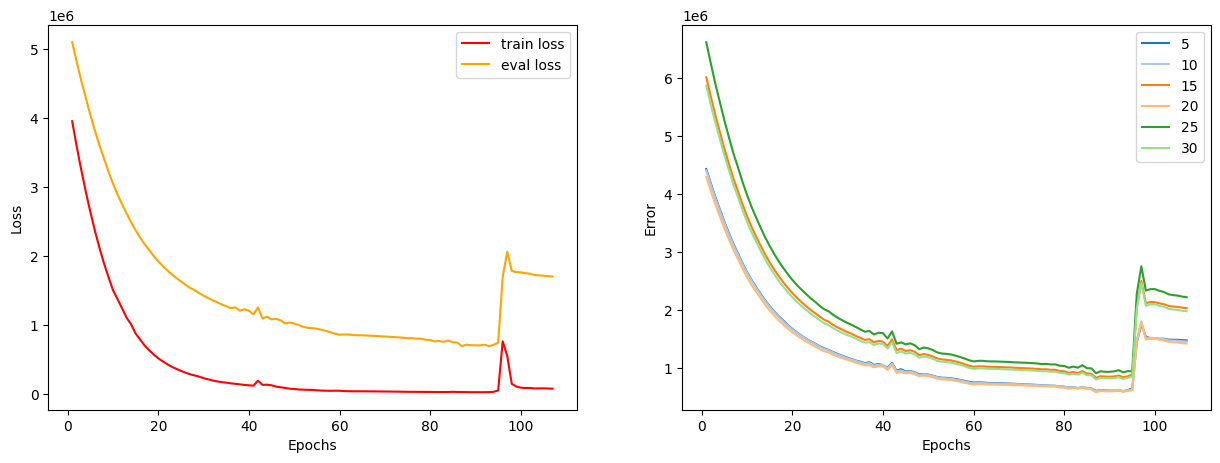

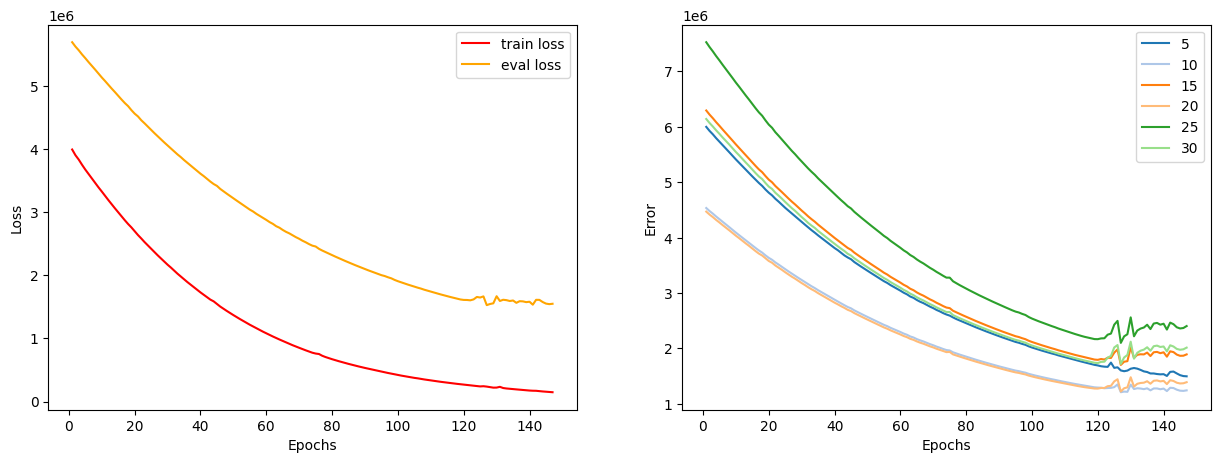

In [ ]:
learning_rates = [0.05, 0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 20, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

100%|██████████| 14/14 [00:00<00:00, 21.97it/s]


epoch 0: train loss = 3691976.34375, eval loss = 4570303.519042969


100%|██████████| 14/14 [00:00<00:00, 21.52it/s]


epoch 1: train loss = 3125740.60546875, eval loss = 4172886.142403739


100%|██████████| 14/14 [00:00<00:00, 21.17it/s]


epoch 2: train loss = 2669021.0771484375, eval loss = 3805460.0700683594


100%|██████████| 14/14 [00:00<00:00, 20.14it/s]


epoch 3: train loss = 2256957.0048828125, eval loss = 3473479.1480189734


100%|██████████| 14/14 [00:00<00:00, 21.45it/s]


epoch 4: train loss = 1985597.8374023438, eval loss = 3198549.0532226562


100%|██████████| 14/14 [00:00<00:00, 21.63it/s]


epoch 5: train loss = 2235215.3515625, eval loss = 3470311.6853376115


100%|██████████| 14/14 [00:00<00:00, 22.29it/s]


epoch 6: train loss = 1746152.060546875, eval loss = 2951226.056780134


100%|██████████| 14/14 [00:00<00:00, 22.04it/s]


epoch 7: train loss = 1363585.4223632812, eval loss = 2819649.84891183


100%|██████████| 14/14 [00:00<00:00, 14.99it/s]


epoch 8: train loss = 1118888.6989746094, eval loss = 2518573.945975167


100%|██████████| 14/14 [00:00<00:00, 22.27it/s]


epoch 9: train loss = 885619.7971191406, eval loss = 2173722.7152273995


100%|██████████| 14/14 [00:00<00:00, 22.32it/s]


epoch 10: train loss = 761274.9409179688, eval loss = 2191888.6675851005


100%|██████████| 14/14 [00:00<00:00, 15.26it/s]


epoch 11: train loss = 739482.8305664062, eval loss = 2149035.546875


100%|██████████| 14/14 [00:00<00:00, 22.20it/s]


epoch 12: train loss = 724357.3969726562, eval loss = 2128247.9626813615


100%|██████████| 14/14 [00:00<00:00, 22.03it/s]


epoch 13: train loss = 709863.2585449219, eval loss = 2108334.566545759


100%|██████████| 14/14 [00:00<00:00, 21.32it/s]


epoch 14: train loss = 695863.1435546875, eval loss = 2089615.5628487724


100%|██████████| 14/14 [00:00<00:00, 22.42it/s]


epoch 15: train loss = 682151.4248046875, eval loss = 2071343.1241629464


100%|██████████| 14/14 [00:00<00:00, 22.29it/s]


epoch 16: train loss = 668687.3471679688, eval loss = 2053348.0448172432


100%|██████████| 14/14 [00:00<00:00, 21.68it/s]


epoch 17: train loss = 655449.1042480469, eval loss = 2035568.2924455914


100%|██████████| 14/14 [00:00<00:00, 22.02it/s]


epoch 18: train loss = 642427.2548828125, eval loss = 2017983.9230957031


100%|██████████| 14/14 [00:00<00:00, 22.11it/s]


epoch 19: train loss = 629619.9943847656, eval loss = 2000593.6666782924


100%|██████████| 14/14 [00:00<00:00, 21.61it/s]


epoch 20: train loss = 617027.4599609375, eval loss = 1983399.0176478794


100%|██████████| 14/14 [00:00<00:00, 14.65it/s]


epoch 21: train loss = 604652.5798339844, eval loss = 1966409.9132952008


100%|██████████| 14/14 [00:00<00:00, 22.12it/s]


epoch 22: train loss = 592496.8801269531, eval loss = 1949634.4523228237


100%|██████████| 14/14 [00:00<00:00, 22.41it/s]


epoch 23: train loss = 580564.015625, eval loss = 1933078.830705915


100%|██████████| 14/14 [00:00<00:00, 14.49it/s]


epoch 24: train loss = 568858.5422363281, eval loss = 1916752.611049107


100%|██████████| 14/14 [00:00<00:00, 21.95it/s]


epoch 25: train loss = 557385.0222167969, eval loss = 1900662.3115583148


100%|██████████| 14/14 [00:00<00:00, 14.86it/s]


epoch 26: train loss = 546148.4116210938, eval loss = 1884813.5773925781


100%|██████████| 14/14 [00:00<00:00, 21.96it/s]


epoch 27: train loss = 535154.2485351562, eval loss = 1869210.5021972656


100%|██████████| 14/14 [00:00<00:00, 15.16it/s]


epoch 28: train loss = 524408.7229003906, eval loss = 1853855.6765834263


100%|██████████| 14/14 [00:00<00:00, 22.17it/s]


epoch 29: train loss = 513918.4016113281, eval loss = 1838749.600237165


100%|██████████| 14/14 [00:00<00:00, 22.64it/s]


epoch 30: train loss = 503691.88708496094, eval loss = 1823892.9426967076


100%|██████████| 14/14 [00:00<00:00, 15.91it/s]


epoch 31: train loss = 493748.79150390625, eval loss = 1809287.55695452


100%|██████████| 14/14 [00:00<00:00, 22.65it/s]


epoch 32: train loss = 484098.8894042969, eval loss = 1794942.1622140068


100%|██████████| 14/14 [00:00<00:00, 22.21it/s]


epoch 33: train loss = 474743.33544921875, eval loss = 1780866.7958984375


100%|██████████| 14/14 [00:00<00:00, 20.37it/s]


epoch 34: train loss = 465682.31103515625, eval loss = 1767030.28125


100%|██████████| 14/14 [00:00<00:00, 22.21it/s]


epoch 35: train loss = 456845.8720703125, eval loss = 1753472.3437848773


100%|██████████| 14/14 [00:00<00:00, 21.97it/s]


epoch 36: train loss = 448294.4650878906, eval loss = 1740161.3464704242


100%|██████████| 14/14 [00:00<00:00, 21.64it/s]


epoch 37: train loss = 439997.8571777344, eval loss = 1727106.6961146763


100%|██████████| 14/14 [00:00<00:00, 22.44it/s]


epoch 38: train loss = 431945.90966796875, eval loss = 1714301.6184430805


100%|██████████| 14/14 [00:00<00:00, 22.24it/s]


epoch 39: train loss = 424136.1926269531, eval loss = 1701742.1179547992


100%|██████████| 14/14 [00:00<00:00, 22.04it/s]


epoch 40: train loss = 416559.4061279297, eval loss = 1689423.5974121094


100%|██████████| 14/14 [00:00<00:00, 14.19it/s]


epoch 41: train loss = 409212.6815185547, eval loss = 1677331.6006208148


100%|██████████| 14/14 [00:00<00:00, 21.33it/s]


epoch 42: train loss = 402104.4481201172, eval loss = 1665558.59148298


100%|██████████| 14/14 [00:00<00:00, 21.63it/s]


epoch 43: train loss = 395345.2490234375, eval loss = 1653862.5783691406


100%|██████████| 14/14 [00:00<00:00, 17.45it/s]


epoch 44: train loss = 388488.1130371094, eval loss = 1642521.100969587


100%|██████████| 14/14 [00:00<00:00, 21.47it/s]


epoch 45: train loss = 382057.0583496094, eval loss = 1631379.8455984932


100%|██████████| 14/14 [00:00<00:00, 21.32it/s]


epoch 46: train loss = 376131.01696777344, eval loss = 1620398.7365722656


100%|██████████| 14/14 [00:00<00:00, 21.42it/s]


epoch 47: train loss = 369649.5270996094, eval loss = 1609746.14390346


100%|██████████| 14/14 [00:00<00:00, 17.84it/s]


epoch 48: train loss = 363767.5830078125, eval loss = 1599174.0139160156


100%|██████████| 14/14 [00:00<00:00, 22.03it/s]


epoch 49: train loss = 358061.5137939453, eval loss = 1588849.0516531807


100%|██████████| 14/14 [00:00<00:00, 21.63it/s]


epoch 50: train loss = 352541.81604003906, eval loss = 1578765.4476841518


100%|██████████| 14/14 [00:00<00:00, 15.13it/s]


epoch 51: train loss = 347201.57763671875, eval loss = 1568905.5898786273


100%|██████████| 14/14 [00:00<00:00, 21.54it/s]


epoch 52: train loss = 342032.6843261719, eval loss = 1559262.7373395648


100%|██████████| 14/14 [00:00<00:00, 21.46it/s]


epoch 53: train loss = 337029.2596435547, eval loss = 1549835.2997000557


100%|██████████| 14/14 [00:00<00:00, 21.16it/s]


epoch 54: train loss = 332185.833984375, eval loss = 1540617.7697405133


100%|██████████| 14/14 [00:00<00:00, 18.11it/s]


epoch 55: train loss = 327497.9630126953, eval loss = 1531607.7921316964


100%|██████████| 14/14 [00:00<00:00, 21.56it/s]


epoch 56: train loss = 322960.97595214844, eval loss = 1522803.6920689174


100%|██████████| 14/14 [00:00<00:00, 21.85it/s]


epoch 57: train loss = 318569.9826660156, eval loss = 1514202.6694161552


100%|██████████| 14/14 [00:00<00:00, 15.80it/s]


epoch 58: train loss = 314321.0698852539, eval loss = 1505803.9983956474


100%|██████████| 14/14 [00:00<00:00, 21.32it/s]


epoch 59: train loss = 310212.4535522461, eval loss = 1497603.4825962612


100%|██████████| 14/14 [00:00<00:00, 21.55it/s]


epoch 60: train loss = 306239.5057373047, eval loss = 1489595.0397600445


100%|██████████| 14/14 [00:00<00:00, 20.90it/s]


epoch 61: train loss = 302395.2989501953, eval loss = 1481781.765345982


100%|██████████| 14/14 [00:00<00:00, 22.14it/s]


epoch 62: train loss = 298673.1918334961, eval loss = 1474174.9381626674


100%|██████████| 14/14 [00:00<00:00, 21.60it/s]


epoch 63: train loss = 295071.1633300781, eval loss = 1466797.674874442


100%|██████████| 14/14 [00:00<00:00, 21.68it/s]


epoch 64: train loss = 291581.41369628906, eval loss = 1459687.9834856305


100%|██████████| 14/14 [00:00<00:00, 14.65it/s]


epoch 65: train loss = 288198.2550048828, eval loss = 1452954.9854910714


100%|██████████| 14/14 [00:00<00:00, 21.43it/s]


epoch 66: train loss = 284911.24841308594, eval loss = 1446855.0656563896


100%|██████████| 14/14 [00:00<00:00, 21.31it/s]


epoch 67: train loss = 281697.25299072266, eval loss = 1442038.3074428013


100%|██████████| 14/14 [00:00<00:00, 14.29it/s]


epoch 68: train loss = 278504.0700073242, eval loss = 1439987.63835798


100%|██████████| 14/14 [00:00<00:00, 21.30it/s]


epoch 69: train loss = 275229.30364990234, eval loss = 1443019.2735421318


100%|██████████| 14/14 [00:00<00:00, 21.47it/s]


epoch 70: train loss = 271751.9723510742, eval loss = 1452565.6514195034


100%|██████████| 14/14 [00:00<00:00, 21.71it/s]


epoch 71: train loss = 268056.2121582031, eval loss = 1467175.411150251


100%|██████████| 14/14 [00:00<00:00, 21.78it/s]


epoch 72: train loss = 264273.75329589844, eval loss = 1483462.5064174107


100%|██████████| 14/14 [00:00<00:00, 21.49it/s]


epoch 73: train loss = 260553.39532470703, eval loss = 1498577.533848354


100%|██████████| 14/14 [00:00<00:00, 20.95it/s]


epoch 74: train loss = 256952.52423095703, eval loss = 1511350.968296596


100%|██████████| 14/14 [00:00<00:00, 14.55it/s]


epoch 75: train loss = 253459.2378540039, eval loss = 1521817.2934570312


100%|██████████| 14/14 [00:00<00:00, 21.53it/s]


epoch 76: train loss = 250047.58514404297, eval loss = 1530444.1077706474

Early stoping after 76 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 1329228.25
Best train loss = 278504.0700073242
Best eval loss = 1439987.63835798
Best 5sec eval = 1729822.375
Best 10sec eval = 1329228.25
Best 15sec eval = 1287088.125
Best 20sec eval = 1506531.0
Best 25sec eval = 1298538.875
Best 30sec eval = 1474293.0


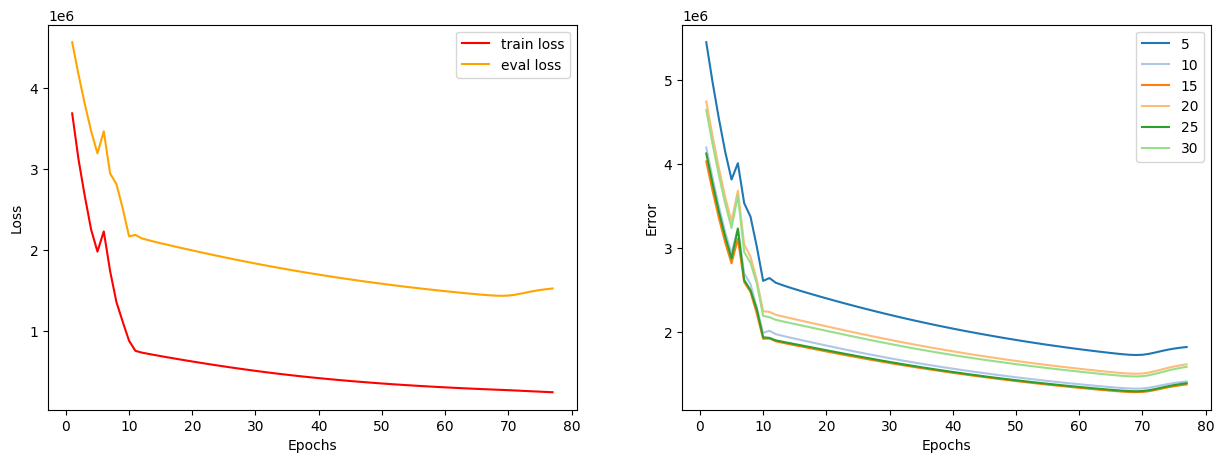

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 8, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

100%|██████████| 14/14 [00:03<00:00,  4.22it/s]


epoch 0: train loss = 3704351.8759765625, eval loss = 8419636.32700893


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 1: train loss = 3182324.1611328125, eval loss = 7699116.970982143


100%|██████████| 14/14 [00:02<00:00,  5.29it/s]


epoch 2: train loss = 2729055.3193359375, eval loss = 7053654.319196428


100%|██████████| 14/14 [00:01<00:00,  9.57it/s]


epoch 3: train loss = 2346650.0517578125, eval loss = 6477944.440848215


100%|██████████| 14/14 [00:01<00:00,  8.71it/s]


epoch 4: train loss = 2011965.662109375, eval loss = 5962874.892857143


100%|██████████| 14/14 [00:01<00:00,  9.32it/s]


epoch 5: train loss = 1806556.8500976562, eval loss = 5890155.71875


100%|██████████| 14/14 [00:01<00:00,  9.34it/s]


epoch 6: train loss = 1757148.31640625, eval loss = 5852076.388950893


100%|██████████| 14/14 [00:01<00:00,  9.36it/s]


epoch 7: train loss = 1751971.255859375, eval loss = 5791282.351004465


100%|██████████| 14/14 [00:01<00:00,  9.37it/s]


epoch 8: train loss = 1694046.8881835938, eval loss = 5739824.48046875


100%|██████████| 14/14 [00:01<00:00,  9.22it/s]


epoch 9: train loss = 1647191.2934570312, eval loss = 5694269.106584822


100%|██████████| 14/14 [00:01<00:00,  9.34it/s]


epoch 10: train loss = 1607698.6025390625, eval loss = 5648123.10546875


100%|██████████| 14/14 [00:01<00:00,  9.59it/s]


epoch 11: train loss = 1579268.552734375, eval loss = 5590893.28515625


100%|██████████| 14/14 [00:01<00:00,  9.48it/s]


epoch 12: train loss = 1547559.3515625, eval loss = 5545582.661830357


100%|██████████| 14/14 [00:01<00:00,  9.49it/s]


epoch 13: train loss = 1516229.1513671875, eval loss = 5499013.688616072


100%|██████████| 14/14 [00:01<00:00,  9.33it/s]


epoch 14: train loss = 1485748.2939453125, eval loss = 5449533.493861607


100%|██████████| 14/14 [00:01<00:00,  7.29it/s]


epoch 15: train loss = 1457016.4086914062, eval loss = 5400768.239955357


100%|██████████| 14/14 [00:01<00:00,  9.12it/s]


epoch 16: train loss = 1428591.3852539062, eval loss = 5352147.384486607


100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


epoch 17: train loss = 1401029.5356445312, eval loss = 5303907.279575893


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 18: train loss = 1373676.0986328125, eval loss = 5256065.325334822


100%|██████████| 14/14 [00:01<00:00,  7.20it/s]


epoch 19: train loss = 1347016.2290039062, eval loss = 5208746.6953125


100%|██████████| 14/14 [00:01<00:00,  9.28it/s]


epoch 20: train loss = 1320476.7963867188, eval loss = 5161658.114955357


100%|██████████| 14/14 [00:01<00:00,  7.44it/s]


epoch 21: train loss = 1295365.498046875, eval loss = 5115136.250558035


100%|██████████| 14/14 [00:01<00:00,  9.67it/s]


epoch 22: train loss = 1269196.7709960938, eval loss = 5069212.26171875


100%|██████████| 14/14 [00:01<00:00,  7.32it/s]


epoch 23: train loss = 1245212.4013671875, eval loss = 5023018.837611607


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 24: train loss = 1220270.7475585938, eval loss = 4977522.0078125


100%|██████████| 14/14 [00:02<00:00,  6.80it/s]


epoch 25: train loss = 1197422.2492675781, eval loss = 4933311.798549107


100%|██████████| 14/14 [00:01<00:00, 10.15it/s]


epoch 26: train loss = 1172568.1066894531, eval loss = 4888999.877790178


100%|██████████| 14/14 [00:01<00:00,  7.90it/s]


epoch 27: train loss = 1150739.2683105469, eval loss = 4842935.892857143


100%|██████████| 14/14 [00:01<00:00, 10.52it/s]


epoch 28: train loss = 1125081.9040527344, eval loss = 4800803.324776785


100%|██████████| 14/14 [00:01<00:00,  9.93it/s]


epoch 29: train loss = 1101708.6142578125, eval loss = 4758325.013392857


100%|██████████| 14/14 [00:01<00:00,  9.66it/s]


epoch 30: train loss = 1080784.2028808594, eval loss = 4714882.803013393


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


epoch 31: train loss = 1059370.9226074219, eval loss = 4673540.424107143


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 32: train loss = 1036730.4499511719, eval loss = 4628783.392299107


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 33: train loss = 1015429.2436523438, eval loss = 4585422.822544643


100%|██████████| 14/14 [00:01<00:00, 10.22it/s]


epoch 34: train loss = 994532.5949707031, eval loss = 4546085.036830357


100%|██████████| 14/14 [00:01<00:00,  9.75it/s]


epoch 35: train loss = 975244.3442382812, eval loss = 4506033.84123884


100%|██████████| 14/14 [00:01<00:00,  8.11it/s]


epoch 36: train loss = 954751.9582519531, eval loss = 4466514.642299107


100%|██████████| 14/14 [00:01<00:00,  9.76it/s]


epoch 37: train loss = 936039.2758789062, eval loss = 4428114.757254465


100%|██████████| 14/14 [00:01<00:00,  7.11it/s]


epoch 38: train loss = 916344.4099121094, eval loss = 4389408.310825893


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 39: train loss = 898135.7109375, eval loss = 4351480.76311384


100%|██████████| 14/14 [00:01<00:00,  7.33it/s]


epoch 40: train loss = 880306.7214355469, eval loss = 4314562.975446428


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


epoch 41: train loss = 862793.6298828125, eval loss = 4278331.86077009


100%|██████████| 14/14 [00:01<00:00,  8.66it/s]


epoch 42: train loss = 845274.8393554688, eval loss = 4241557.298549107


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 43: train loss = 828355.6179199219, eval loss = 4203972.792131697


100%|██████████| 14/14 [00:01<00:00, 10.32it/s]


epoch 44: train loss = 811750.1931152344, eval loss = 4168607.500558036


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


epoch 45: train loss = 795891.4970703125, eval loss = 4133200.9397321427


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 46: train loss = 780437.6987304688, eval loss = 4098120.390625


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 47: train loss = 765770.705078125, eval loss = 4063839.701171875


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 48: train loss = 749494.2192382812, eval loss = 4030925.814453125


100%|██████████| 14/14 [00:01<00:00,  9.18it/s]


epoch 49: train loss = 735432.5522460938, eval loss = 3995643.5993303573


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 50: train loss = 721013.30078125, eval loss = 3962919.218191964


100%|██████████| 14/14 [00:01<00:00,  7.09it/s]


epoch 51: train loss = 707315.9560546875, eval loss = 3930156.444754464


100%|██████████| 14/14 [00:01<00:00, 10.36it/s]


epoch 52: train loss = 693483.8952636719, eval loss = 3898557.0075334823


100%|██████████| 14/14 [00:01<00:00,  7.38it/s]


epoch 53: train loss = 679505.7775878906, eval loss = 3866116.3683035714


100%|██████████| 14/14 [00:01<00:00, 10.30it/s]


epoch 54: train loss = 667959.8463134766, eval loss = 3830650.4743303573


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 55: train loss = 655668.0260009766, eval loss = 3800936.354910714


100%|██████████| 14/14 [00:01<00:00, 10.26it/s]


epoch 56: train loss = 643727.1240234375, eval loss = 3770177.044363839


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 57: train loss = 630814.7430419922, eval loss = 3742211.270089286


100%|██████████| 14/14 [00:01<00:00,  9.21it/s]


epoch 58: train loss = 618476.1685791016, eval loss = 3712112.7229352677


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


epoch 59: train loss = 605829.6490478516, eval loss = 3685427.860770089


100%|██████████| 14/14 [00:01<00:00, 10.28it/s]


epoch 60: train loss = 594383.1353759766, eval loss = 3655369.0842633927


100%|██████████| 14/14 [00:01<00:00, 10.33it/s]


epoch 61: train loss = 583006.0628662109, eval loss = 3626042.5145089286


100%|██████████| 14/14 [00:01<00:00,  7.40it/s]


epoch 62: train loss = 573931.0615234375, eval loss = 3597994.271484375


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 63: train loss = 562058.2150878906, eval loss = 3569746.3660714286


100%|██████████| 14/14 [00:02<00:00,  6.93it/s]


epoch 64: train loss = 553797.4114990234, eval loss = 3543039.590401786


100%|██████████| 14/14 [00:01<00:00, 10.33it/s]


epoch 65: train loss = 542691.3785400391, eval loss = 3512446.892020089


100%|██████████| 14/14 [00:01<00:00,  8.18it/s]


epoch 66: train loss = 533624.8732910156, eval loss = 3489356.8289620536


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


epoch 67: train loss = 522309.82421875, eval loss = 3460827.15234375


100%|██████████| 14/14 [00:01<00:00,  8.79it/s]


epoch 68: train loss = 512756.41650390625, eval loss = 3434144.54296875


100%|██████████| 14/14 [00:01<00:00,  9.56it/s]


epoch 69: train loss = 502784.25231933594, eval loss = 3403496.9006696427


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


epoch 70: train loss = 494315.9931640625, eval loss = 3381687.0108816964


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 71: train loss = 482292.97790527344, eval loss = 3360426.3370535714


100%|██████████| 14/14 [00:01<00:00,  8.16it/s]


epoch 72: train loss = 473043.22717285156, eval loss = 3333190.092354911


100%|██████████| 14/14 [00:01<00:00, 10.21it/s]


epoch 73: train loss = 464522.34509277344, eval loss = 3309181.8186383927


100%|██████████| 14/14 [00:01<00:00,  8.89it/s]


epoch 74: train loss = 456399.7165527344, eval loss = 3282244.114676339


100%|██████████| 14/14 [00:01<00:00,  9.55it/s]


epoch 75: train loss = 446888.8566894531, eval loss = 3258278.4148995536


100%|██████████| 14/14 [00:01<00:00,  7.93it/s]


epoch 76: train loss = 438809.2628173828, eval loss = 3232395.8148716516


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


epoch 77: train loss = 430291.5178222656, eval loss = 3207147.4984654016


100%|██████████| 14/14 [00:01<00:00,  9.33it/s]


epoch 78: train loss = 421881.1403808594, eval loss = 3180758.297433036


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 79: train loss = 415478.1552734375, eval loss = 3160287.240373884


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 80: train loss = 405389.1760253906, eval loss = 3133834.4917689734


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


epoch 81: train loss = 399655.6624145508, eval loss = 3109906.940708705


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 82: train loss = 392588.9719238281, eval loss = 3088527.23172433


100%|██████████| 14/14 [00:01<00:00,  9.61it/s]


epoch 83: train loss = 384547.0322265625, eval loss = 3063053.049386161


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


epoch 84: train loss = 376043.8698730469, eval loss = 3039699.4111328125


100%|██████████| 14/14 [00:01<00:00,  8.74it/s]


epoch 85: train loss = 368682.4602050781, eval loss = 3016834.389927455


100%|██████████| 14/14 [00:01<00:00,  9.57it/s]


epoch 86: train loss = 364501.3869628906, eval loss = 2994175.873604911


100%|██████████| 14/14 [00:01<00:00,  9.47it/s]


epoch 87: train loss = 367939.57696533203, eval loss = 2984704.501953125


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


epoch 88: train loss = 365690.22521972656, eval loss = 2951168.873604911


100%|██████████| 14/14 [00:01<00:00,  7.84it/s]


epoch 89: train loss = 348652.6862792969, eval loss = 2930112.3914620536


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 90: train loss = 340402.30084228516, eval loss = 2910194.85421317


100%|██████████| 14/14 [00:02<00:00,  6.73it/s]


epoch 91: train loss = 332789.84466552734, eval loss = 2888304.4807477677


100%|██████████| 14/14 [00:01<00:00, 10.18it/s]


epoch 92: train loss = 325448.3596801758, eval loss = 2868349.280691964


100%|██████████| 14/14 [00:01<00:00,  7.34it/s]


epoch 93: train loss = 318578.9328613281, eval loss = 2847070.375139509


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


epoch 94: train loss = 311785.2152709961, eval loss = 2827851.7932477677


100%|██████████| 14/14 [00:01<00:00,  8.21it/s]


epoch 95: train loss = 304517.8746948242, eval loss = 2808337.1241629464


100%|██████████| 14/14 [00:01<00:00, 10.62it/s]


epoch 96: train loss = 298051.76959228516, eval loss = 2789799.3005022323


100%|██████████| 14/14 [00:01<00:00, 10.48it/s]


epoch 97: train loss = 292174.56341552734, eval loss = 2771486.4235491073


100%|██████████| 14/14 [00:01<00:00,  9.46it/s]


epoch 98: train loss = 286090.6436767578, eval loss = 2753542.8272879464


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


epoch 99: train loss = 280385.9635620117, eval loss = 2737065.509626116


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


epoch 100: train loss = 275047.60693359375, eval loss = 2722152.3317522323


100%|██████████| 14/14 [00:01<00:00, 10.18it/s]


epoch 101: train loss = 270242.3473510742, eval loss = 2706806.8094308036


100%|██████████| 14/14 [00:01<00:00,  7.79it/s]


epoch 102: train loss = 266961.8288574219, eval loss = 2695250.7419084823


100%|██████████| 14/14 [00:01<00:00, 10.24it/s]


epoch 103: train loss = 264713.2680053711, eval loss = 2661515.7449776786


100%|██████████| 14/14 [00:01<00:00,  7.23it/s]


epoch 104: train loss = 256776.36102294922, eval loss = 2647482.836077009


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 105: train loss = 251470.08575439453, eval loss = 2637517.8461216516


100%|██████████| 14/14 [00:01<00:00,  8.41it/s]


epoch 106: train loss = 246147.93463134766, eval loss = 2629092.5778459823


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 107: train loss = 242295.24758911133, eval loss = 2606929.672433036


100%|██████████| 14/14 [00:01<00:00, 10.30it/s]


epoch 108: train loss = 236766.22650146484, eval loss = 2590370.1547154016


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


epoch 109: train loss = 232221.61526489258, eval loss = 2574880.6746651786


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


epoch 110: train loss = 227764.13549804688, eval loss = 2562859.3984375


100%|██████████| 14/14 [00:01<00:00,  9.62it/s]


epoch 111: train loss = 223899.05038452148, eval loss = 2543046.1065848214


100%|██████████| 14/14 [00:01<00:00,  9.49it/s]


epoch 112: train loss = 219748.66235351562, eval loss = 2528019.314313616


100%|██████████| 14/14 [00:01<00:00,  9.90it/s]


epoch 113: train loss = 215721.92840576172, eval loss = 2507746.4137834823


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 114: train loss = 211710.78228759766, eval loss = 2491211.3122209823


100%|██████████| 14/14 [00:01<00:00,  9.50it/s]


epoch 115: train loss = 207757.86645507812, eval loss = 2471624.444614955


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


epoch 116: train loss = 204021.32162475586, eval loss = 2455288.06375558


100%|██████████| 14/14 [00:01<00:00,  8.51it/s]


epoch 117: train loss = 200427.16751098633, eval loss = 2436866.4581473214


100%|██████████| 14/14 [00:01<00:00,  9.56it/s]


epoch 118: train loss = 196868.62536621094, eval loss = 2419989.3897879464


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 119: train loss = 193168.58352661133, eval loss = 2400915.884626116


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


epoch 120: train loss = 189513.02514648438, eval loss = 2384103.3830915177


100%|██████████| 14/14 [00:01<00:00,  9.69it/s]


epoch 121: train loss = 186048.12716674805, eval loss = 2366550.040457589


100%|██████████| 14/14 [00:01<00:00,  9.84it/s]


epoch 122: train loss = 182763.10870361328, eval loss = 2350090.4327566964


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


epoch 123: train loss = 179601.60244750977, eval loss = 2332332.1469029016


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 124: train loss = 176565.62365722656, eval loss = 2314966.45703125


100%|██████████| 14/14 [00:01<00:00,  8.97it/s]


epoch 125: train loss = 173544.2509765625, eval loss = 2298276.6026785714


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 126: train loss = 170255.74728393555, eval loss = 2282627.309988839


100%|██████████| 14/14 [00:01<00:00,  9.53it/s]


epoch 127: train loss = 166471.8807067871, eval loss = 2266619.0323660714


100%|██████████| 14/14 [00:01<00:00,  8.71it/s]


epoch 128: train loss = 163091.51861572266, eval loss = 2251890.6936383927


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


epoch 129: train loss = 160400.04064941406, eval loss = 2236288.770228795


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 130: train loss = 158093.2723388672, eval loss = 2221402.8473074776


100%|██████████| 14/14 [00:01<00:00,  7.35it/s]


epoch 131: train loss = 155090.90393066406, eval loss = 2205295.0140206474


100%|██████████| 14/14 [00:01<00:00, 10.33it/s]


epoch 132: train loss = 151289.53927612305, eval loss = 2190277.7093331474


100%|██████████| 14/14 [00:01<00:00,  7.57it/s]


epoch 133: train loss = 148135.4111328125, eval loss = 2175785.139718192


100%|██████████| 14/14 [00:01<00:00, 10.36it/s]


epoch 134: train loss = 145328.48599243164, eval loss = 2161416.05203683


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


epoch 135: train loss = 142614.30477905273, eval loss = 2146464.2965262276


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


epoch 136: train loss = 139858.27224731445, eval loss = 2132096.0965401786


100%|██████████| 14/14 [00:01<00:00, 10.32it/s]


epoch 137: train loss = 137334.21646118164, eval loss = 2116952.8812779016


100%|██████████| 14/14 [00:01<00:00,  9.36it/s]


epoch 138: train loss = 134356.74853515625, eval loss = 2104209.1344866073


100%|██████████| 14/14 [00:01<00:00, 10.49it/s]


epoch 139: train loss = 132031.18035888672, eval loss = 2089513.4840262276


100%|██████████| 14/14 [00:02<00:00,  6.86it/s]


epoch 140: train loss = 130316.80825805664, eval loss = 2076080.6575055805


100%|██████████| 14/14 [00:01<00:00, 10.55it/s]


epoch 141: train loss = 128020.10159301758, eval loss = 2061836.449497768


100%|██████████| 14/14 [00:01<00:00,  8.80it/s]


epoch 142: train loss = 125051.40487670898, eval loss = 2048921.0515485492


100%|██████████| 14/14 [00:01<00:00, 10.22it/s]


epoch 143: train loss = 124854.25244140625, eval loss = 2037688.307686942


100%|██████████| 14/14 [00:01<00:00, 10.55it/s]


epoch 144: train loss = 122907.42102050781, eval loss = 2021665.1935686383


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 145: train loss = 118141.14044189453, eval loss = 2007870.754813058


100%|██████████| 14/14 [00:01<00:00, 10.20it/s]


epoch 146: train loss = 115932.11193847656, eval loss = 1996287.3416573661


100%|██████████| 14/14 [00:01<00:00, 10.06it/s]


epoch 147: train loss = 118977.35571289062, eval loss = 1988925.9178292411


100%|██████████| 14/14 [00:01<00:00, 10.44it/s]


epoch 148: train loss = 113743.7692565918, eval loss = 1972107.3062918526


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


epoch 149: train loss = 110219.62292480469, eval loss = 1960365.2885742188


100%|██████████| 14/14 [00:01<00:00, 10.30it/s]


epoch 150: train loss = 107240.57614135742, eval loss = 1947392.5348074776


100%|██████████| 14/14 [00:01<00:00,  9.44it/s]


epoch 151: train loss = 104833.13092041016, eval loss = 1933883.6008649555


100%|██████████| 14/14 [00:01<00:00, 10.50it/s]


epoch 152: train loss = 102915.86309814453, eval loss = 1922428.2679966518


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 153: train loss = 100626.50210571289, eval loss = 1908036.4990234375


100%|██████████| 14/14 [00:01<00:00, 10.38it/s]


epoch 154: train loss = 98396.10119628906, eval loss = 1895969.6070033482


100%|██████████| 14/14 [00:01<00:00, 10.25it/s]


epoch 155: train loss = 96862.2991027832, eval loss = 1885376.9367327008


100%|██████████| 14/14 [00:02<00:00,  6.78it/s]


epoch 156: train loss = 94160.19772338867, eval loss = 1872286.5239955357


100%|██████████| 14/14 [00:01<00:00, 10.42it/s]


epoch 157: train loss = 91675.55899047852, eval loss = 1860607.8892299107


100%|██████████| 14/14 [00:01<00:00,  8.44it/s]


epoch 158: train loss = 89878.26861572266, eval loss = 1849471.9167829242


100%|██████████| 14/14 [00:01<00:00, 10.36it/s]


epoch 159: train loss = 87942.06964111328, eval loss = 1837369.577078683


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


epoch 160: train loss = 86031.86331176758, eval loss = 1826253.503627232


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


epoch 161: train loss = 84189.3316040039, eval loss = 1814167.7172154018


100%|██████████| 14/14 [00:01<00:00, 10.32it/s]


epoch 162: train loss = 82726.69833374023, eval loss = 1799498.584263393


100%|██████████| 14/14 [00:01<00:00,  8.73it/s]


epoch 163: train loss = 80721.31243896484, eval loss = 1790294.7105189732


100%|██████████| 14/14 [00:01<00:00, 10.48it/s]


epoch 164: train loss = 78820.68862915039, eval loss = 1778227.2839704242


100%|██████████| 14/14 [00:02<00:00,  6.96it/s]


epoch 165: train loss = 77333.45556640625, eval loss = 1766090.938825335


100%|██████████| 14/14 [00:01<00:00, 10.39it/s]


epoch 166: train loss = 75435.83892822266, eval loss = 1754382.0378766742


100%|██████████| 14/14 [00:01<00:00,  9.27it/s]


epoch 167: train loss = 73814.10598754883, eval loss = 1744076.7752511161


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


epoch 168: train loss = 72350.04315185547, eval loss = 1732154.840890067


100%|██████████| 14/14 [00:01<00:00, 10.16it/s]


epoch 169: train loss = 71106.1099243164, eval loss = 1722884.7983398438


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 170: train loss = 69689.99642944336, eval loss = 1713000.69594029


100%|██████████| 14/14 [00:01<00:00, 10.37it/s]


epoch 171: train loss = 68207.78857421875, eval loss = 1703744.7613002232


100%|██████████| 14/14 [00:02<00:00,  6.71it/s]


epoch 172: train loss = 66629.6682434082, eval loss = 1692100.5590122768


100%|██████████| 14/14 [00:01<00:00, 10.19it/s]


epoch 173: train loss = 65086.901916503906, eval loss = 1681602.0896344867


100%|██████████| 14/14 [00:01<00:00,  8.67it/s]


epoch 174: train loss = 63719.94467163086, eval loss = 1667675.4112723214


100%|██████████| 14/14 [00:01<00:00, 10.59it/s]


epoch 175: train loss = 62259.289489746094, eval loss = 1658003.789969308


100%|██████████| 14/14 [00:01<00:00, 10.25it/s]


epoch 176: train loss = 61382.683181762695, eval loss = 1644114.9064592633


100%|██████████| 14/14 [00:01<00:00, 10.39it/s]


epoch 177: train loss = 60774.99240112305, eval loss = 1633762.1863141742


100%|██████████| 14/14 [00:01<00:00, 10.19it/s]


epoch 178: train loss = 58863.689453125, eval loss = 1625692.3896484375


100%|██████████| 14/14 [00:01<00:00,  7.69it/s]


epoch 179: train loss = 57532.30392456055, eval loss = 1614392.7168666294


100%|██████████| 14/14 [00:01<00:00, 10.33it/s]


epoch 180: train loss = 56818.57141113281, eval loss = 1603334.3558872768


100%|██████████| 14/14 [00:01<00:00,  7.16it/s]


epoch 181: train loss = 58433.82196044922, eval loss = 1596508.8599330357


100%|██████████| 14/14 [00:01<00:00, 10.32it/s]


epoch 182: train loss = 58352.23599243164, eval loss = 1601661.0774274555


100%|██████████| 14/14 [00:01<00:00, 10.37it/s]


epoch 183: train loss = 63302.40148925781, eval loss = 1562980.0523856026


100%|██████████| 14/14 [00:01<00:00, 10.34it/s]


epoch 184: train loss = 60706.361236572266, eval loss = 1561731.00718471


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 185: train loss = 54904.14974975586, eval loss = 1556800.159249442


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


epoch 186: train loss = 52045.933364868164, eval loss = 1542733.3862304688


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 187: train loss = 50149.81491088867, eval loss = 1532135.2400251117


100%|██████████| 14/14 [00:01<00:00,  9.08it/s]


epoch 188: train loss = 48538.109298706055, eval loss = 1519050.3826729911


100%|██████████| 14/14 [00:01<00:00,  9.60it/s]


epoch 189: train loss = 47489.21896362305, eval loss = 1511576.4380580357


100%|██████████| 14/14 [00:01<00:00,  9.02it/s]


epoch 190: train loss = 46439.185974121094, eval loss = 1501240.61655971


100%|██████████| 14/14 [00:01<00:00,  9.82it/s]


epoch 191: train loss = 45441.72134399414, eval loss = 1491699.1982421875


100%|██████████| 14/14 [00:01<00:00,  8.46it/s]


epoch 192: train loss = 44577.56483459473, eval loss = 1483146.9091796875


100%|██████████| 14/14 [00:01<00:00,  9.08it/s]


epoch 193: train loss = 43790.95960998535, eval loss = 1474479.7266322544


100%|██████████| 14/14 [00:01<00:00,  8.83it/s]


epoch 194: train loss = 43001.36929321289, eval loss = 1466289.862234933


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 195: train loss = 42206.49240112305, eval loss = 1457295.6750837055


100%|██████████| 14/14 [00:01<00:00,  8.44it/s]


epoch 196: train loss = 41452.17964172363, eval loss = 1448869.1620396206


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


epoch 197: train loss = 40841.29084777832, eval loss = 1439633.1866629464


100%|██████████| 14/14 [00:01<00:00,  7.75it/s]


epoch 198: train loss = 40033.05311584473, eval loss = 1431574.9571010044


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 199: train loss = 39393.780838012695, eval loss = 1422763.01234654


100%|██████████| 14/14 [00:01<00:00,  7.04it/s]


epoch 200: train loss = 38690.00685119629, eval loss = 1414766.1375906807


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 201: train loss = 38243.9762878418, eval loss = 1406943.3851143974


100%|██████████| 14/14 [00:02<00:00,  6.48it/s]


epoch 202: train loss = 37668.15858459473, eval loss = 1398240.3342285156


100%|██████████| 14/14 [00:01<00:00, 10.26it/s]


epoch 203: train loss = 37061.13639831543, eval loss = 1390175.650844029


100%|██████████| 14/14 [00:01<00:00,  7.31it/s]


epoch 204: train loss = 36541.6667175293, eval loss = 1381657.685546875


100%|██████████| 14/14 [00:01<00:00,  9.90it/s]


epoch 205: train loss = 36439.43885803223, eval loss = 1374230.6511579242


100%|██████████| 14/14 [00:01<00:00,  9.73it/s]


epoch 206: train loss = 35478.028396606445, eval loss = 1364946.3698032924


100%|██████████| 14/14 [00:01<00:00,  9.67it/s]


epoch 207: train loss = 35037.01931762695, eval loss = 1359381.6803850445


100%|██████████| 14/14 [00:01<00:00, 10.41it/s]


epoch 208: train loss = 34834.59492492676, eval loss = 1352297.7794712612


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 209: train loss = 34632.76188659668, eval loss = 1346800.4904436383


100%|██████████| 14/14 [00:01<00:00, 10.52it/s]


epoch 210: train loss = 34271.395767211914, eval loss = 1340125.7141810826


100%|██████████| 14/14 [00:01<00:00,  7.30it/s]


epoch 211: train loss = 33854.20590209961, eval loss = 1335576.9741908482


100%|██████████| 14/14 [00:01<00:00, 10.28it/s]


epoch 212: train loss = 33193.17372131348, eval loss = 1326618.626325335


100%|██████████| 14/14 [00:01<00:00,  7.20it/s]


epoch 213: train loss = 32532.89878845215, eval loss = 1317142.8823242188


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 214: train loss = 32288.561325073242, eval loss = 1307808.3741629464


100%|██████████| 14/14 [00:01<00:00,  7.67it/s]


epoch 215: train loss = 31962.327377319336, eval loss = 1302886.3991001674


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 216: train loss = 31847.127059936523, eval loss = 1293733.2080078125


100%|██████████| 14/14 [00:01<00:00,  8.24it/s]


epoch 217: train loss = 31205.667694091797, eval loss = 1290164.1830357143


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


epoch 218: train loss = 30640.022735595703, eval loss = 1285431.3075125557


100%|██████████| 14/14 [00:01<00:00,  9.88it/s]


epoch 219: train loss = 30392.249114990234, eval loss = 1278887.3985072544


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


epoch 220: train loss = 30433.897033691406, eval loss = 1273116.9089704242


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


epoch 221: train loss = 30148.480499267578, eval loss = 1261517.3466448102


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 222: train loss = 29562.765396118164, eval loss = 1253653.8731515068


100%|██████████| 14/14 [00:01<00:00,  9.42it/s]


epoch 223: train loss = 29061.0684967041, eval loss = 1246801.886265346


100%|██████████| 14/14 [00:01<00:00,  9.25it/s]


epoch 224: train loss = 28724.725997924805, eval loss = 1240434.8513183594


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 225: train loss = 28498.1287689209, eval loss = 1233398.5834960938


100%|██████████| 14/14 [00:01<00:00,  8.64it/s]


epoch 226: train loss = 28330.358917236328, eval loss = 1227672.8382742745


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


epoch 227: train loss = 28079.01206970215, eval loss = 1221580.5154854911


100%|██████████| 14/14 [00:02<00:00,  6.95it/s]


epoch 228: train loss = 27845.888870239258, eval loss = 1217419.5147879464


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 229: train loss = 27865.497650146484, eval loss = 1213203.188546317


100%|██████████| 14/14 [00:01<00:00,  7.06it/s]


epoch 230: train loss = 27901.21466064453, eval loss = 1211363.3692103794


100%|██████████| 14/14 [00:01<00:00, 10.37it/s]


epoch 231: train loss = 28143.764755249023, eval loss = 1211564.665736607


100%|██████████| 14/14 [00:01<00:00,  8.87it/s]


epoch 232: train loss = 28683.542709350586, eval loss = 1215634.06187221


100%|██████████| 14/14 [00:01<00:00, 10.39it/s]


epoch 233: train loss = 28457.005828857422, eval loss = 1209964.6632952008


100%|██████████| 14/14 [00:01<00:00, 10.38it/s]


epoch 234: train loss = 28024.876998901367, eval loss = 1193415.1256975445


100%|██████████| 14/14 [00:01<00:00, 10.14it/s]


epoch 235: train loss = 27432.33659362793, eval loss = 1184384.8613978794


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 236: train loss = 27038.683517456055, eval loss = 1179859.368861607


100%|██████████| 14/14 [00:01<00:00,  7.90it/s]


epoch 237: train loss = 26602.89810180664, eval loss = 1172461.7897949219


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 238: train loss = 26421.42091369629, eval loss = 1162950.608049665


100%|██████████| 14/14 [00:01<00:00,  7.04it/s]


epoch 239: train loss = 26214.626251220703, eval loss = 1158527.3558872768


100%|██████████| 14/14 [00:01<00:00, 10.29it/s]


epoch 240: train loss = 26081.735427856445, eval loss = 1154673.7951660156


100%|██████████| 14/14 [00:01<00:00,  7.75it/s]


epoch 241: train loss = 25867.7996673584, eval loss = 1148190.0656738281


100%|██████████| 14/14 [00:01<00:00, 10.24it/s]


epoch 242: train loss = 25757.84132385254, eval loss = 1144654.683279855


100%|██████████| 14/14 [00:01<00:00, 10.11it/s]


epoch 243: train loss = 25647.114227294922, eval loss = 1139627.3384137836


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 244: train loss = 25618.882873535156, eval loss = 1138169.4638671875


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 245: train loss = 25788.81346130371, eval loss = 1141312.1211635044


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 246: train loss = 25761.010330200195, eval loss = 1135941.0053013393


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 247: train loss = 25558.20245361328, eval loss = 1127814.1354631695


100%|██████████| 14/14 [00:01<00:00,  8.90it/s]


epoch 248: train loss = 25381.21467590332, eval loss = 1119655.9700055805


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 249: train loss = 25307.714096069336, eval loss = 1106678.6189662388


100%|██████████| 14/14 [00:01<00:00,  7.34it/s]


epoch 250: train loss = 25375.401794433594, eval loss = 1107095.7676130023


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 251: train loss = 29226.62045288086, eval loss = 1159756.7330845424


100%|██████████| 14/14 [00:02<00:00,  6.91it/s]


epoch 252: train loss = 40320.90637207031, eval loss = 1231190.9460797992


100%|██████████| 14/14 [00:01<00:00, 10.19it/s]


epoch 253: train loss = 30881.42855834961, eval loss = 1194764.092250279


100%|██████████| 14/14 [00:02<00:00,  6.96it/s]


epoch 254: train loss = 28951.801300048828, eval loss = 1151756.311907087


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 255: train loss = 26503.713485717773, eval loss = 1124479.5186593193


100%|██████████| 14/14 [00:01<00:00,  8.26it/s]


epoch 256: train loss = 25428.633377075195, eval loss = 1096857.3895089286


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


epoch 257: train loss = 25065.719619750977, eval loss = 1081038.2005092076


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 258: train loss = 24520.56007385254, eval loss = 1068641.831752232


100%|██████████| 14/14 [00:01<00:00,  9.94it/s]


epoch 259: train loss = 24234.328323364258, eval loss = 1061408.0680106026


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 260: train loss = 24050.077926635742, eval loss = 1055248.427280971


100%|██████████| 14/14 [00:01<00:00, 10.06it/s]


epoch 261: train loss = 23920.178955078125, eval loss = 1050278.1747698102


100%|██████████| 14/14 [00:01<00:00, 10.23it/s]


epoch 262: train loss = 23914.080101013184, eval loss = 1044369.8378208706


100%|██████████| 14/14 [00:01<00:00,  7.84it/s]


epoch 263: train loss = 23851.87351989746, eval loss = 1043891.3445172991


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


epoch 264: train loss = 23839.2029876709, eval loss = 1037266.8811383928


100%|██████████| 14/14 [00:02<00:00,  6.94it/s]


epoch 265: train loss = 23679.14102935791, eval loss = 1036546.8841378348


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


epoch 266: train loss = 23397.214324951172, eval loss = 1027950.6115722656


100%|██████████| 14/14 [00:01<00:00,  7.10it/s]


epoch 267: train loss = 23092.859733581543, eval loss = 1022447.1400669643


100%|██████████| 14/14 [00:01<00:00, 10.41it/s]


epoch 268: train loss = 23140.74870300293, eval loss = 1017467.4641462053


100%|██████████| 14/14 [00:01<00:00,  8.37it/s]


epoch 269: train loss = 23279.65277862549, eval loss = 1015827.6437290737


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


epoch 270: train loss = 23535.425659179688, eval loss = 1011970.4860491072


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 271: train loss = 23352.64849090576, eval loss = 1005946.3063964844


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 272: train loss = 23353.883415222168, eval loss = 1003794.5183105469


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 273: train loss = 23173.664573669434, eval loss = 1000203.1035505022


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


epoch 274: train loss = 23315.579177856445, eval loss = 995165.6845703125


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 275: train loss = 23841.324897766113, eval loss = 997077.0047084263


100%|██████████| 14/14 [00:01<00:00,  8.07it/s]


epoch 276: train loss = 26944.402069091797, eval loss = 986255.371233259


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 277: train loss = 27771.986694335938, eval loss = 1028873.4359305246


100%|██████████| 14/14 [00:01<00:00,  7.24it/s]


epoch 278: train loss = 37239.695053100586, eval loss = 1018207.5507114956


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 279: train loss = 38248.841888427734, eval loss = 1048735.5791015625


100%|██████████| 14/14 [00:02<00:00,  6.90it/s]


epoch 280: train loss = 31623.93765258789, eval loss = 1114323.1241280693


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 281: train loss = 26619.830993652344, eval loss = 1092511.8128487724


100%|██████████| 14/14 [00:01<00:00,  7.60it/s]


epoch 282: train loss = 23510.6220703125, eval loss = 1045871.1098981585


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 283: train loss = 22830.707260131836, eval loss = 1003038.3915666853


100%|██████████| 14/14 [00:01<00:00,  9.25it/s]


epoch 284: train loss = 22779.273315429688, eval loss = 983771.2894461496


100%|██████████| 14/14 [00:01<00:00, 10.08it/s]


epoch 285: train loss = 22726.551040649414, eval loss = 973687.3839285715


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 286: train loss = 22558.522079467773, eval loss = 960901.4417550223


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


epoch 287: train loss = 22422.719528198242, eval loss = 948482.6804896763


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


epoch 288: train loss = 22404.085662841797, eval loss = 938908.0829031809


100%|██████████| 14/14 [00:01<00:00,  8.69it/s]


epoch 289: train loss = 22553.36654663086, eval loss = 930468.4844273159


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


epoch 290: train loss = 22309.43842315674, eval loss = 924736.722342355


100%|██████████| 14/14 [00:01<00:00,  9.39it/s]


epoch 291: train loss = 22081.77362060547, eval loss = 919377.6387765066


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 292: train loss = 22038.33943939209, eval loss = 910589.1144321987


100%|██████████| 14/14 [00:01<00:00,  9.68it/s]


epoch 293: train loss = 21872.574996948242, eval loss = 907263.7078683035


100%|██████████| 14/14 [00:01<00:00,  9.68it/s]


epoch 294: train loss = 21647.2713470459, eval loss = 896717.8548409598


100%|██████████| 14/14 [00:01<00:00,  9.00it/s]


epoch 295: train loss = 21382.197441101074, eval loss = 892441.1623535156


100%|██████████| 14/14 [00:01<00:00,  9.79it/s]


epoch 296: train loss = 21143.388862609863, eval loss = 886672.7371651785


100%|██████████| 14/14 [00:01<00:00,  7.86it/s]


epoch 297: train loss = 20834.905601501465, eval loss = 879153.1493094309


100%|██████████| 14/14 [00:01<00:00,  9.88it/s]


epoch 298: train loss = 20690.04037475586, eval loss = 872828.3195277622


100%|██████████| 14/14 [00:01<00:00,  9.63it/s]


epoch 299: train loss = 20605.52446746826, eval loss = 866573.4880371094


100%|██████████| 14/14 [00:01<00:00,  9.64it/s]


epoch 300: train loss = 20525.536544799805, eval loss = 860486.1727294922


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


epoch 301: train loss = 20387.433807373047, eval loss = 853474.8477260044


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


epoch 302: train loss = 20242.996772766113, eval loss = 847417.738420759


100%|██████████| 14/14 [00:01<00:00,  7.35it/s]


epoch 303: train loss = 20083.396186828613, eval loss = 841501.6240583147


100%|██████████| 14/14 [00:01<00:00,  9.65it/s]


epoch 304: train loss = 19912.75399017334, eval loss = 836121.5170549665


100%|██████████| 14/14 [00:01<00:00,  7.11it/s]


epoch 305: train loss = 19730.265617370605, eval loss = 829610.6637834822


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 306: train loss = 19567.431213378906, eval loss = 822478.9462716238


100%|██████████| 14/14 [00:02<00:00,  6.84it/s]


epoch 307: train loss = 19440.852897644043, eval loss = 815270.3989955357


100%|██████████| 14/14 [00:01<00:00,  9.57it/s]


epoch 308: train loss = 19375.143272399902, eval loss = 808371.9626988003


100%|██████████| 14/14 [00:02<00:00,  6.74it/s]


epoch 309: train loss = 19241.965660095215, eval loss = 800571.0562918527


100%|██████████| 14/14 [00:01<00:00,  9.76it/s]


epoch 310: train loss = 19014.227462768555, eval loss = 793483.0432128906


100%|██████████| 14/14 [00:02<00:00,  6.39it/s]


epoch 311: train loss = 18851.633476257324, eval loss = 788226.7532087053


100%|██████████| 14/14 [00:01<00:00,  9.62it/s]


epoch 312: train loss = 18580.15199279785, eval loss = 781562.0400739397


100%|██████████| 14/14 [00:01<00:00,  7.83it/s]


epoch 313: train loss = 18588.084350585938, eval loss = 777113.6682477678


100%|██████████| 14/14 [00:01<00:00, 10.06it/s]


epoch 314: train loss = 18473.723426818848, eval loss = 768074.3810686384


100%|██████████| 14/14 [00:01<00:00,  8.80it/s]


epoch 315: train loss = 18711.196083068848, eval loss = 763514.415788923


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 316: train loss = 18422.677238464355, eval loss = 755383.7076590402


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 317: train loss = 18069.16606903076, eval loss = 749290.7062639509


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 318: train loss = 18049.227600097656, eval loss = 746910.6982073103


100%|██████████| 14/14 [00:01<00:00,  9.33it/s]


epoch 319: train loss = 17804.64887237549, eval loss = 738712.179547991


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


epoch 320: train loss = 18236.449951171875, eval loss = 730634.2330845424


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


epoch 321: train loss = 18092.89052581787, eval loss = 728519.837663923


100%|██████████| 14/14 [00:01<00:00,  9.51it/s]


epoch 322: train loss = 18180.80633544922, eval loss = 714680.4360351562


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


epoch 323: train loss = 17726.851081848145, eval loss = 708838.3182896206


100%|██████████| 14/14 [00:01<00:00, 10.06it/s]


epoch 324: train loss = 17863.479301452637, eval loss = 700709.1142229353


100%|██████████| 14/14 [00:01<00:00,  9.39it/s]


epoch 325: train loss = 17598.599517822266, eval loss = 695350.6439208984


100%|██████████| 14/14 [00:01<00:00,  9.13it/s]


epoch 326: train loss = 18163.874961853027, eval loss = 686650.5661969866


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 327: train loss = 19383.47491455078, eval loss = 677474.3377162388


100%|██████████| 14/14 [00:01<00:00,  7.27it/s]


epoch 328: train loss = 18043.241249084473, eval loss = 682652.9077671596


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 329: train loss = 17237.418830871582, eval loss = 668776.0008370535


100%|██████████| 14/14 [00:02<00:00,  6.85it/s]


epoch 330: train loss = 16991.266304016113, eval loss = 665488.8996233259


100%|██████████| 14/14 [00:01<00:00, 10.31it/s]


epoch 331: train loss = 16633.02099609375, eval loss = 658457.2489536831


100%|██████████| 14/14 [00:01<00:00,  7.26it/s]


epoch 332: train loss = 16945.58660888672, eval loss = 657678.3905726841


100%|██████████| 14/14 [00:01<00:00,  9.84it/s]


epoch 333: train loss = 16417.71287918091, eval loss = 645606.8806849888


100%|██████████| 14/14 [00:01<00:00,  9.35it/s]


epoch 334: train loss = 17201.273681640625, eval loss = 647889.5341099331


100%|██████████| 14/14 [00:01<00:00,  9.68it/s]


epoch 335: train loss = 16399.173851013184, eval loss = 631681.4955705915


100%|██████████| 14/14 [00:01<00:00,  8.51it/s]


epoch 336: train loss = 15952.183589935303, eval loss = 625159.313319615


100%|██████████| 14/14 [00:01<00:00, 10.11it/s]


epoch 337: train loss = 15589.353569030762, eval loss = 616010.1397530691


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 338: train loss = 15574.99528503418, eval loss = 609047.0108816965


100%|██████████| 14/14 [00:01<00:00, 10.20it/s]


epoch 339: train loss = 15690.428993225098, eval loss = 603197.7902483259


100%|██████████| 14/14 [00:01<00:00, 10.23it/s]


epoch 340: train loss = 16132.094074249268, eval loss = 598154.8770054409


100%|██████████| 14/14 [00:01<00:00,  9.82it/s]


epoch 341: train loss = 16532.075050354004, eval loss = 599220.389125279


100%|██████████| 14/14 [00:01<00:00, 10.49it/s]


epoch 342: train loss = 17159.94345855713, eval loss = 591331.2245047434


100%|██████████| 14/14 [00:01<00:00,  7.50it/s]


epoch 343: train loss = 18305.888389587402, eval loss = 595427.6179199219


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


epoch 344: train loss = 19786.02353668213, eval loss = 585263.4646693638


100%|██████████| 14/14 [00:02<00:00,  6.83it/s]


epoch 345: train loss = 23628.7021484375, eval loss = 638087.1695033482


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


epoch 346: train loss = 33394.75813293457, eval loss = 805067.7887137277


100%|██████████| 14/14 [00:01<00:00,  7.22it/s]


epoch 347: train loss = 30319.412689208984, eval loss = 766598.4751325335


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


epoch 348: train loss = 21759.85821533203, eval loss = 665512.7821219309


100%|██████████| 14/14 [00:01<00:00,  7.10it/s]


epoch 349: train loss = 19369.032989501953, eval loss = 635989.5509905134


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


epoch 350: train loss = 17523.014709472656, eval loss = 590155.131312779


100%|██████████| 14/14 [00:01<00:00,  8.70it/s]


epoch 351: train loss = 16557.066062927246, eval loss = 586809.0300292969


100%|██████████| 14/14 [00:01<00:00, 10.31it/s]


epoch 352: train loss = 15462.803035736084, eval loss = 555299.5193219866


100%|██████████| 14/14 [00:01<00:00, 10.22it/s]


epoch 353: train loss = 15435.194328308105, eval loss = 548552.2022181919


100%|██████████| 14/14 [00:01<00:00, 10.28it/s]


epoch 354: train loss = 15098.589893341064, eval loss = 540016.336251395


100%|██████████| 14/14 [00:01<00:00, 10.53it/s]


epoch 355: train loss = 14721.098640441895, eval loss = 532191.5744280134


100%|██████████| 14/14 [00:01<00:00,  7.48it/s]


epoch 356: train loss = 14565.536155700684, eval loss = 524847.3742327009


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


epoch 357: train loss = 14527.06867980957, eval loss = 518098.077078683


100%|██████████| 14/14 [00:01<00:00,  7.12it/s]


epoch 358: train loss = 14357.779361724854, eval loss = 510317.43387276784


100%|██████████| 14/14 [00:01<00:00, 10.18it/s]


epoch 359: train loss = 14008.423839569092, eval loss = 503738.38337053574


100%|██████████| 14/14 [00:01<00:00,  8.49it/s]


epoch 360: train loss = 13855.635753631592, eval loss = 496813.14580426895


100%|██████████| 14/14 [00:01<00:00,  9.82it/s]


epoch 361: train loss = 13736.35641860962, eval loss = 491018.77130998886


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 362: train loss = 13521.279682159424, eval loss = 484974.0695800781


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 363: train loss = 13383.61653137207, eval loss = 478977.67431640625


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


epoch 364: train loss = 13536.679290771484, eval loss = 474971.55336216517


100%|██████████| 14/14 [00:01<00:00, 10.36it/s]


epoch 365: train loss = 13613.056484222412, eval loss = 469777.5224260603


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


epoch 366: train loss = 13390.908039093018, eval loss = 463123.10410853795


100%|██████████| 14/14 [00:01<00:00,  7.16it/s]


epoch 367: train loss = 13103.042533874512, eval loss = 456214.0514439174


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 368: train loss = 13159.041328430176, eval loss = 452229.0128871373


100%|██████████| 14/14 [00:02<00:00,  6.94it/s]


epoch 369: train loss = 12796.173965454102, eval loss = 446006.5096261161


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 370: train loss = 12594.010540008545, eval loss = 439549.5061035156


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


epoch 371: train loss = 12692.118690490723, eval loss = 435143.04234095983


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 372: train loss = 12441.815437316895, eval loss = 430076.9088657924


100%|██████████| 14/14 [00:01<00:00,  8.28it/s]


epoch 373: train loss = 12301.528621673584, eval loss = 423894.9167480469


100%|██████████| 14/14 [00:01<00:00,  9.94it/s]


epoch 374: train loss = 12250.275901794434, eval loss = 418734.7275390625


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 375: train loss = 12136.708194732666, eval loss = 413944.6203264509


100%|██████████| 14/14 [00:01<00:00,  9.68it/s]


epoch 376: train loss = 12032.172710418701, eval loss = 408340.3094308036


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


epoch 377: train loss = 11877.901844024658, eval loss = 403205.96341378347


100%|██████████| 14/14 [00:01<00:00, 10.18it/s]


epoch 378: train loss = 11872.19356918335, eval loss = 395865.16041782923


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 379: train loss = 12293.64895248413, eval loss = 395666.3301478795


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


epoch 380: train loss = 13851.830585479736, eval loss = 383963.3096226283


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 381: train loss = 12511.244087219238, eval loss = 387906.71064104355


100%|██████████| 14/14 [00:01<00:00,  7.18it/s]


epoch 382: train loss = 11873.499362945557, eval loss = 378747.34718540736


100%|██████████| 14/14 [00:01<00:00, 10.15it/s]


epoch 383: train loss = 11964.8381690979, eval loss = 379888.77675083705


100%|██████████| 14/14 [00:01<00:00,  7.14it/s]


epoch 384: train loss = 11978.099620819092, eval loss = 367372.19255719864


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


epoch 385: train loss = 11954.386535644531, eval loss = 373975.5714285714


100%|██████████| 14/14 [00:01<00:00,  7.19it/s]


epoch 386: train loss = 11875.703010559082, eval loss = 362571.9781842913


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 387: train loss = 11428.317283630371, eval loss = 356885.1414097377


100%|██████████| 14/14 [00:01<00:00,  8.80it/s]


epoch 388: train loss = 11608.857864379883, eval loss = 350852.5232282366


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 389: train loss = 11273.082626342773, eval loss = 342458.3690708705


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 390: train loss = 11166.274368286133, eval loss = 341225.1821812221


100%|██████████| 14/14 [00:01<00:00,  9.93it/s]


epoch 391: train loss = 11418.875495910645, eval loss = 338653.7643171038


100%|██████████| 14/14 [00:01<00:00,  9.48it/s]


epoch 392: train loss = 11000.643943786621, eval loss = 325710.8796735491


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 393: train loss = 10940.956638336182, eval loss = 323671.5760323661


100%|██████████| 14/14 [00:01<00:00, 10.26it/s]


epoch 394: train loss = 10919.82166671753, eval loss = 319984.8272879464


100%|██████████| 14/14 [00:01<00:00,  7.32it/s]


epoch 395: train loss = 10983.580963134766, eval loss = 320347.5392020089


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


epoch 396: train loss = 11143.555480957031, eval loss = 312366.5568847656


100%|██████████| 14/14 [00:02<00:00,  6.97it/s]


epoch 397: train loss = 11465.851970672607, eval loss = 313072.9826660156


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 398: train loss = 10727.024848937988, eval loss = 304824.3190220424


100%|██████████| 14/14 [00:01<00:00,  8.21it/s]


epoch 399: train loss = 10726.95198059082, eval loss = 295980.97378976


100%|██████████| 14/14 [00:01<00:00, 10.33it/s]


epoch 400: train loss = 10309.579998016357, eval loss = 291208.0685686384


100%|██████████| 14/14 [00:01<00:00, 10.16it/s]


epoch 401: train loss = 9995.038135528564, eval loss = 290130.51796177455


100%|██████████| 14/14 [00:01<00:00, 10.35it/s]


epoch 402: train loss = 9775.439262390137, eval loss = 281495.31417410716


100%|██████████| 14/14 [00:01<00:00, 10.34it/s]


epoch 403: train loss = 9824.964092254639, eval loss = 276469.77092633926


100%|██████████| 14/14 [00:01<00:00,  7.91it/s]


epoch 404: train loss = 10697.639556884766, eval loss = 275571.29146902903


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


epoch 405: train loss = 13323.741989135742, eval loss = 338362.4051688058


100%|██████████| 14/14 [00:01<00:00,  7.19it/s]


epoch 406: train loss = 12303.418869018555, eval loss = 291553.8642578125


100%|██████████| 14/14 [00:01<00:00, 10.42it/s]


epoch 407: train loss = 10924.186737060547, eval loss = 259947.63124302455


100%|██████████| 14/14 [00:01<00:00, 10.19it/s]


epoch 408: train loss = 10415.250659942627, eval loss = 268401.13213239395


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 409: train loss = 10025.662227630615, eval loss = 256558.36235700335


100%|██████████| 14/14 [00:01<00:00, 10.34it/s]


epoch 410: train loss = 9531.543308258057, eval loss = 247593.9580078125


100%|██████████| 14/14 [00:01<00:00, 10.46it/s]


epoch 411: train loss = 9418.411277770996, eval loss = 246764.61945452009


100%|██████████| 14/14 [00:01<00:00, 10.22it/s]


epoch 412: train loss = 9136.169872283936, eval loss = 238423.09748186384


100%|██████████| 14/14 [00:01<00:00,  8.85it/s]


epoch 413: train loss = 9424.798526763916, eval loss = 237967.61650739398


100%|██████████| 14/14 [00:01<00:00, 10.24it/s]


epoch 414: train loss = 9072.667488098145, eval loss = 229765.2925502232


100%|██████████| 14/14 [00:01<00:00,  7.29it/s]


epoch 415: train loss = 9107.711423873901, eval loss = 227273.79781668526


100%|██████████| 14/14 [00:01<00:00, 10.34it/s]


epoch 416: train loss = 9001.433769226074, eval loss = 222998.61003766741


100%|██████████| 14/14 [00:01<00:00,  8.99it/s]


epoch 417: train loss = 9325.035705566406, eval loss = 221638.80137416295


100%|██████████| 14/14 [00:01<00:00, 10.30it/s]


epoch 418: train loss = 9343.190864562988, eval loss = 217950.28236607142


100%|██████████| 14/14 [00:01<00:00, 10.48it/s]


epoch 419: train loss = 10232.780687332153, eval loss = 216592.9614606585


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


epoch 420: train loss = 9967.44094467163, eval loss = 213715.50762067523


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 421: train loss = 10343.335289001465, eval loss = 209812.21292550224


100%|██████████| 14/14 [00:01<00:00,  9.15it/s]


epoch 422: train loss = 8789.69151687622, eval loss = 205268.25861467634


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 423: train loss = 8386.97933959961, eval loss = 202448.84685407366


100%|██████████| 14/14 [00:02<00:00,  6.91it/s]


epoch 424: train loss = 8228.819606781006, eval loss = 196519.61155482702


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


epoch 425: train loss = 8120.0331020355225, eval loss = 193832.5600237165


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


epoch 426: train loss = 8140.452285766602, eval loss = 186535.49354771205


100%|██████████| 14/14 [00:01<00:00, 10.53it/s]


epoch 427: train loss = 8343.131839752197, eval loss = 188722.83803013392


100%|██████████| 14/14 [00:01<00:00, 10.25it/s]


epoch 428: train loss = 9849.868244171143, eval loss = 192931.29173060827


100%|██████████| 14/14 [00:01<00:00, 10.24it/s]


epoch 429: train loss = 17015.360080718994, eval loss = 530568.9193638393


100%|██████████| 14/14 [00:01<00:00, 10.27it/s]


epoch 430: train loss = 73945.72576904297, eval loss = 377309.2879813058


100%|██████████| 14/14 [00:01<00:00,  9.46it/s]


epoch 431: train loss = 41808.654846191406, eval loss = 517190.83433314733


100%|██████████| 14/14 [00:01<00:00,  8.95it/s]


epoch 432: train loss = 18376.867141723633, eval loss = 457215.4432896205


100%|██████████| 14/14 [00:02<00:00,  6.95it/s]


epoch 433: train loss = 13782.486228942871, eval loss = 445321.22150530136


100%|██████████| 14/14 [00:01<00:00,  9.59it/s]


epoch 434: train loss = 12069.606094360352, eval loss = 445996.76213727676

Early stoping after 434 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 91449.4296875
Best train loss = 8140.452285766602
Best eval loss = 186535.49354771205
Best 5sec eval = 97144.3671875
Best 10sec eval = 91449.4296875
Best 15sec eval = 492108.40625
Best 20sec eval = 85594.0078125
Best 25sec eval = 83720.3359375
Best 30sec eval = 95886.5234375


100%|██████████| 14/14 [00:01<00:00,  7.15it/s]


epoch 0: train loss = 3788508.2309570312, eval loss = 5465418.1875


100%|██████████| 14/14 [00:01<00:00, 10.53it/s]


epoch 1: train loss = 3196656.0795898438, eval loss = 4958879.074776785


100%|██████████| 14/14 [00:01<00:00,  9.03it/s]


epoch 2: train loss = 2720940.1625976562, eval loss = 4524034.464285715


100%|██████████| 14/14 [00:01<00:00, 10.11it/s]


epoch 3: train loss = 2294999.8940429688, eval loss = 4133268.4397321427


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


epoch 4: train loss = 1975270.208984375, eval loss = 3810294.6316964286


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


epoch 5: train loss = 1814100.4567871094, eval loss = 3787315.78125


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


epoch 6: train loss = 1786274.1706542969, eval loss = 3769201.1584821427


100%|██████████| 14/14 [00:01<00:00,  8.37it/s]


epoch 7: train loss = 1755678.0153808594, eval loss = 3746227.7991071427


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


epoch 8: train loss = 1743499.1083984375, eval loss = 3724992.2087053573


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


epoch 9: train loss = 1712465.5654296875, eval loss = 3703421.1316964286


100%|██████████| 14/14 [00:01<00:00, 10.28it/s]


epoch 10: train loss = 1689445.3825683594, eval loss = 3684544.5915178573


100%|██████████| 14/14 [00:01<00:00,  8.46it/s]


epoch 11: train loss = 1671561.0241699219, eval loss = 3666593.8180803573


100%|██████████| 14/14 [00:01<00:00, 10.35it/s]


epoch 12: train loss = 1659462.1125488281, eval loss = 3647383.7511160714


100%|██████████| 14/14 [00:01<00:00, 10.21it/s]


epoch 13: train loss = 1636767.0842285156, eval loss = 3627969.1662946427


100%|██████████| 14/14 [00:01<00:00, 10.24it/s]


epoch 14: train loss = 1623534.8654785156, eval loss = 3612113.4754464286


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 15: train loss = 1599425.3518066406, eval loss = 3591399.7008928573


100%|██████████| 14/14 [00:01<00:00, 10.28it/s]


epoch 16: train loss = 1580878.9819335938, eval loss = 3580393.0334821427


100%|██████████| 14/14 [00:01<00:00, 10.13it/s]


epoch 17: train loss = 1562184.0725097656, eval loss = 3555772.1495535714


100%|██████████| 14/14 [00:01<00:00,  7.01it/s]


epoch 18: train loss = 1541915.033203125, eval loss = 3542450.609375


100%|██████████| 14/14 [00:01<00:00, 10.19it/s]


epoch 19: train loss = 1523696.7329101562, eval loss = 3522537.848214286


100%|██████████| 14/14 [00:01<00:00,  8.65it/s]


epoch 20: train loss = 1505334.6867675781, eval loss = 3503512.097098214


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 21: train loss = 1486168.0874023438, eval loss = 3485417.199776786


100%|██████████| 14/14 [00:01<00:00, 10.41it/s]


epoch 22: train loss = 1469252.2966308594, eval loss = 3466977.0390625


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 23: train loss = 1452277.7075195312, eval loss = 3448659.934151786


100%|██████████| 14/14 [00:01<00:00, 10.34it/s]


epoch 24: train loss = 1435770.3642578125, eval loss = 3430416.3856026786


100%|██████████| 14/14 [00:01<00:00, 10.21it/s]


epoch 25: train loss = 1419688.2854003906, eval loss = 3412390.1026785714


100%|██████████| 14/14 [00:01<00:00, 10.25it/s]


epoch 26: train loss = 1403995.5458984375, eval loss = 3394523.722098214


100%|██████████| 14/14 [00:02<00:00,  6.83it/s]


epoch 27: train loss = 1388610.7492675781, eval loss = 3376805.9698660714


100%|██████████| 14/14 [00:01<00:00, 10.38it/s]


epoch 28: train loss = 1373435.0334472656, eval loss = 3359282.7790178573


100%|██████████| 14/14 [00:01<00:00,  8.04it/s]


epoch 29: train loss = 1358416.8291015625, eval loss = 3341953.0675223214


100%|██████████| 14/14 [00:01<00:00, 10.36it/s]


epoch 30: train loss = 1343596.5627441406, eval loss = 3324720.58984375


100%|██████████| 14/14 [00:01<00:00, 10.32it/s]


epoch 31: train loss = 1328916.5864257812, eval loss = 3307672.2399553573


100%|██████████| 14/14 [00:01<00:00, 10.25it/s]


epoch 32: train loss = 1314387.9538574219, eval loss = 3290713.6194196427


100%|██████████| 14/14 [00:01<00:00, 10.43it/s]


epoch 33: train loss = 1299996.6354980469, eval loss = 3273948.581473214


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


epoch 34: train loss = 1285724.693359375, eval loss = 3257326.1238839286


 72%|███████▏  | 23/32 [00:12<00:04,  1.90it/s]


KeyboardInterrupt: 

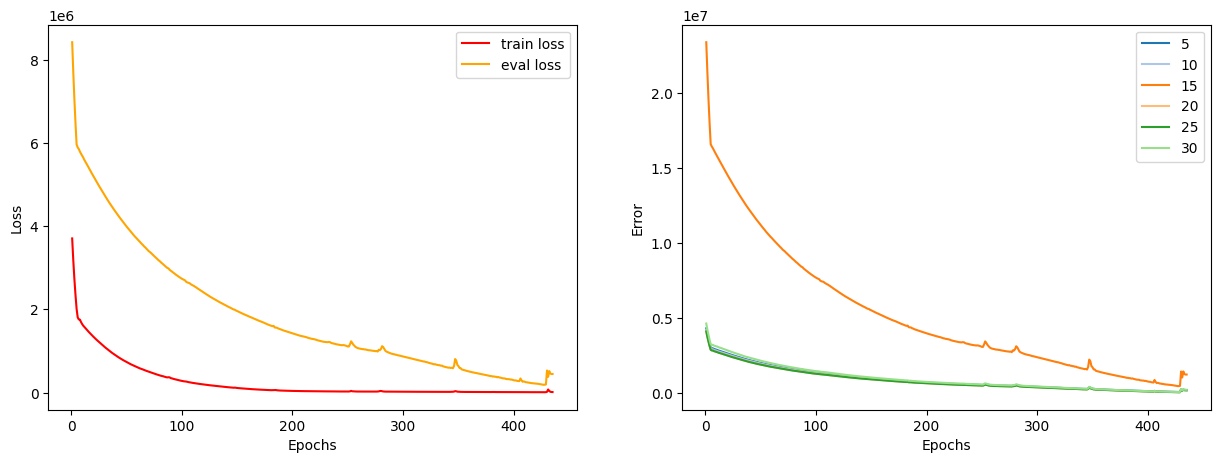

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 8, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/03/2024, 13:46:07",606050,599848,583681,0.05,16,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231025-19054_20231025-062708.j...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[3953798.0241815476, 3587440.045014881, 325230...","[5097635.592881944, 4814700.728298611, 4542583...","{5: [tensor(4426039.5000), tensor(4180875.), t...","{5: tensor(606050.6875), 10: tensor(599848.750..."
1,"04/03/2024, 14:08:21",1603885,1211193,1223657,0.01,16,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231025-19054_20231025-062708.j...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[3990228.407738095, 3899658.2589285714, 383027...","[5688982.555040147, 5619698.291693794, 5561430...","{5: [tensor(5997539.), tensor(5924788.), tenso...","{5: tensor(1603885.7500), 10: tensor(1211193.6..."
2,"04/03/2024, 15:39:31",775201,796999,483548,0.05,32,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231025-19054_20231025-062708.j...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4101759.793154762, 3869534.6116071427, 362385...","[6242430.2984375, 6039071.3578125, 5819104.773...","{5: [tensor(5365298.), tensor(5191150.), tenso...","{5: tensor(775201.7500), 10: tensor(796999.312..."
3,"04/03/2024, 15:59:45",1287306,1435220,853257,0.01,32,1,16,./Models/mamba_model_airplane_dm8nl1ds16dc4rs4...,[VIS_airplane_20231025-19054_20231025-062708.j...,"{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4147489.7321428573, 4104363.5446428573, 40587...","[4838392.9375, 4808153.0984375, 4776533.108593...","{5: [tensor(5108952.), tensor(5077218.), tenso...","{5: tensor(1287306.6250), 10: tensor(1435220.7..."


# New Section

In [ ]:
# date_time_ = str(date_time).replace("/","_")
# results_path = './Features Extraction Results/features_extraction_results_' + date_time_

# with open(results_path , 'wb') as f:
#   pickle.dump(exp_record, f)